# Recession Indicators


In [1]:
library(UsingR)
library(quantmod)
library(ggplot2)
library(grid)
library(gridExtra)
library(knitr)
library(kableExtra)
library(tools)
library(zoo)
library(signal)
library(stringr)
library(corrplot)
library(caret)
library(rpart)
library(rpart.plot)
library(randomForest)
library(Quandl)
library(nnet)
#library(devtools)
#install_github("andrewuhl/RollingWindow")
library(RollingWindow)
library(gtable)
library(data.table)
library(readxl)

Loading required package: MASS

Loading required package: HistData

Loading required package: Hmisc

Loading required package: lattice

Loading required package: survival

Loading required package: Formula

Loading required package: ggplot2


Attaching package: 'Hmisc'


The following objects are masked from 'package:base':

    format.pval, units



Attaching package: 'UsingR'


The following object is masked from 'package:survival':

    cancer


Loading required package: xts

Loading required package: zoo


Attaching package: 'zoo'


The following objects are masked from 'package:base':

    as.Date, as.Date.numeric


Loading required package: TTR

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


Attaching package: 'quantmod'


The following object is masked from 'package:Hmisc':

    Lag



Attaching package: 'signal'


The following objects are masked from 'package:stats':

    filter, poly


corrplot 0.92 loaded


Attaching packa

Call helper functions

In [2]:
source("plotHelper.r")

Define the source of the data (local or web) and whether to update the models.

In [39]:
b.refresh.models = TRUE

Define the plotting ranges

In [4]:
dt.recent = as.Date("2017-01-01")

Load up the off-line data

In [5]:
load("C:/Users/Rainy/OneDrive//RecessionIndicator_Buffer.RData")

This snippet is needed because some of the ticker symbols include are invalid variable names so re-cast those variable names.

In [6]:
df.symbols$string.symbol <-
  str_replace_all(df.symbols$string.symbol, "[^[:alnum:]]", "")

Do the interpolation to daily samples and tidy the data

In [7]:
source("calcInterpolate.r")

In [8]:
df.data <- calcInterpolate(df.symbols)

Warning message in merge.xts(xtsData, get(df.symbols$string.symbol[idx])):
"NAs introduced by coercion"


Create aggreagate data series
Some analysis requires that two or more series be combined. For example, normallizing debt by GDP to get a sense of the proportion of debt to the total economy helps understand the debt cycle.

In [9]:
source("calcAggregateSeries.r")

Calculate the year-over-year, 50 day moving average, and other features in the data

In [10]:
source("calcFeatures.r")

In [11]:
lst.df <- calcFeatures(df.data, df.symbols)
df.data <- lst.df[[1]]
df.symbols <- lst.df[[2]]

[1] "USREC has zero or negative values. Log series will be zero."
[1] "GSFTX.Volume has zero or negative values. Log series will be zero."
[1] "LFMIX.Volume has zero or negative values. Log series will be zero."
[1] "LFMCX.Volume has zero or negative values. Log series will be zero."
[1] "LFMAX.Volume has zero or negative values. Log series will be zero."
[1] "LCSIX.Volume has zero or negative values. Log series will be zero."
[1] "VBIRX.Volume has zero or negative values. Log series will be zero."
[1] "VFSUX.Volume has zero or negative values. Log series will be zero."
[1] "LTUIX.Volume has zero or negative values. Log series will be zero."
[1] "PTTPX.Volume has zero or negative values. Log series will be zero."
[1] "NERYX.Volume has zero or negative values. Log series will be zero."
[1] "STIGX.Volume has zero or negative values. Log series will be zero."
[1] "HLGAX.Volume has zero or negative values. Log series will be zero."
[1] "FTRGX.Volume has zero or negative values. Log series 

These are auxilliary series that use the YoY and smoothed data.

In [12]:
source("calcFeaturesAggregate.r")

Build the recession data frame

In [13]:
source("calcRecession.r")

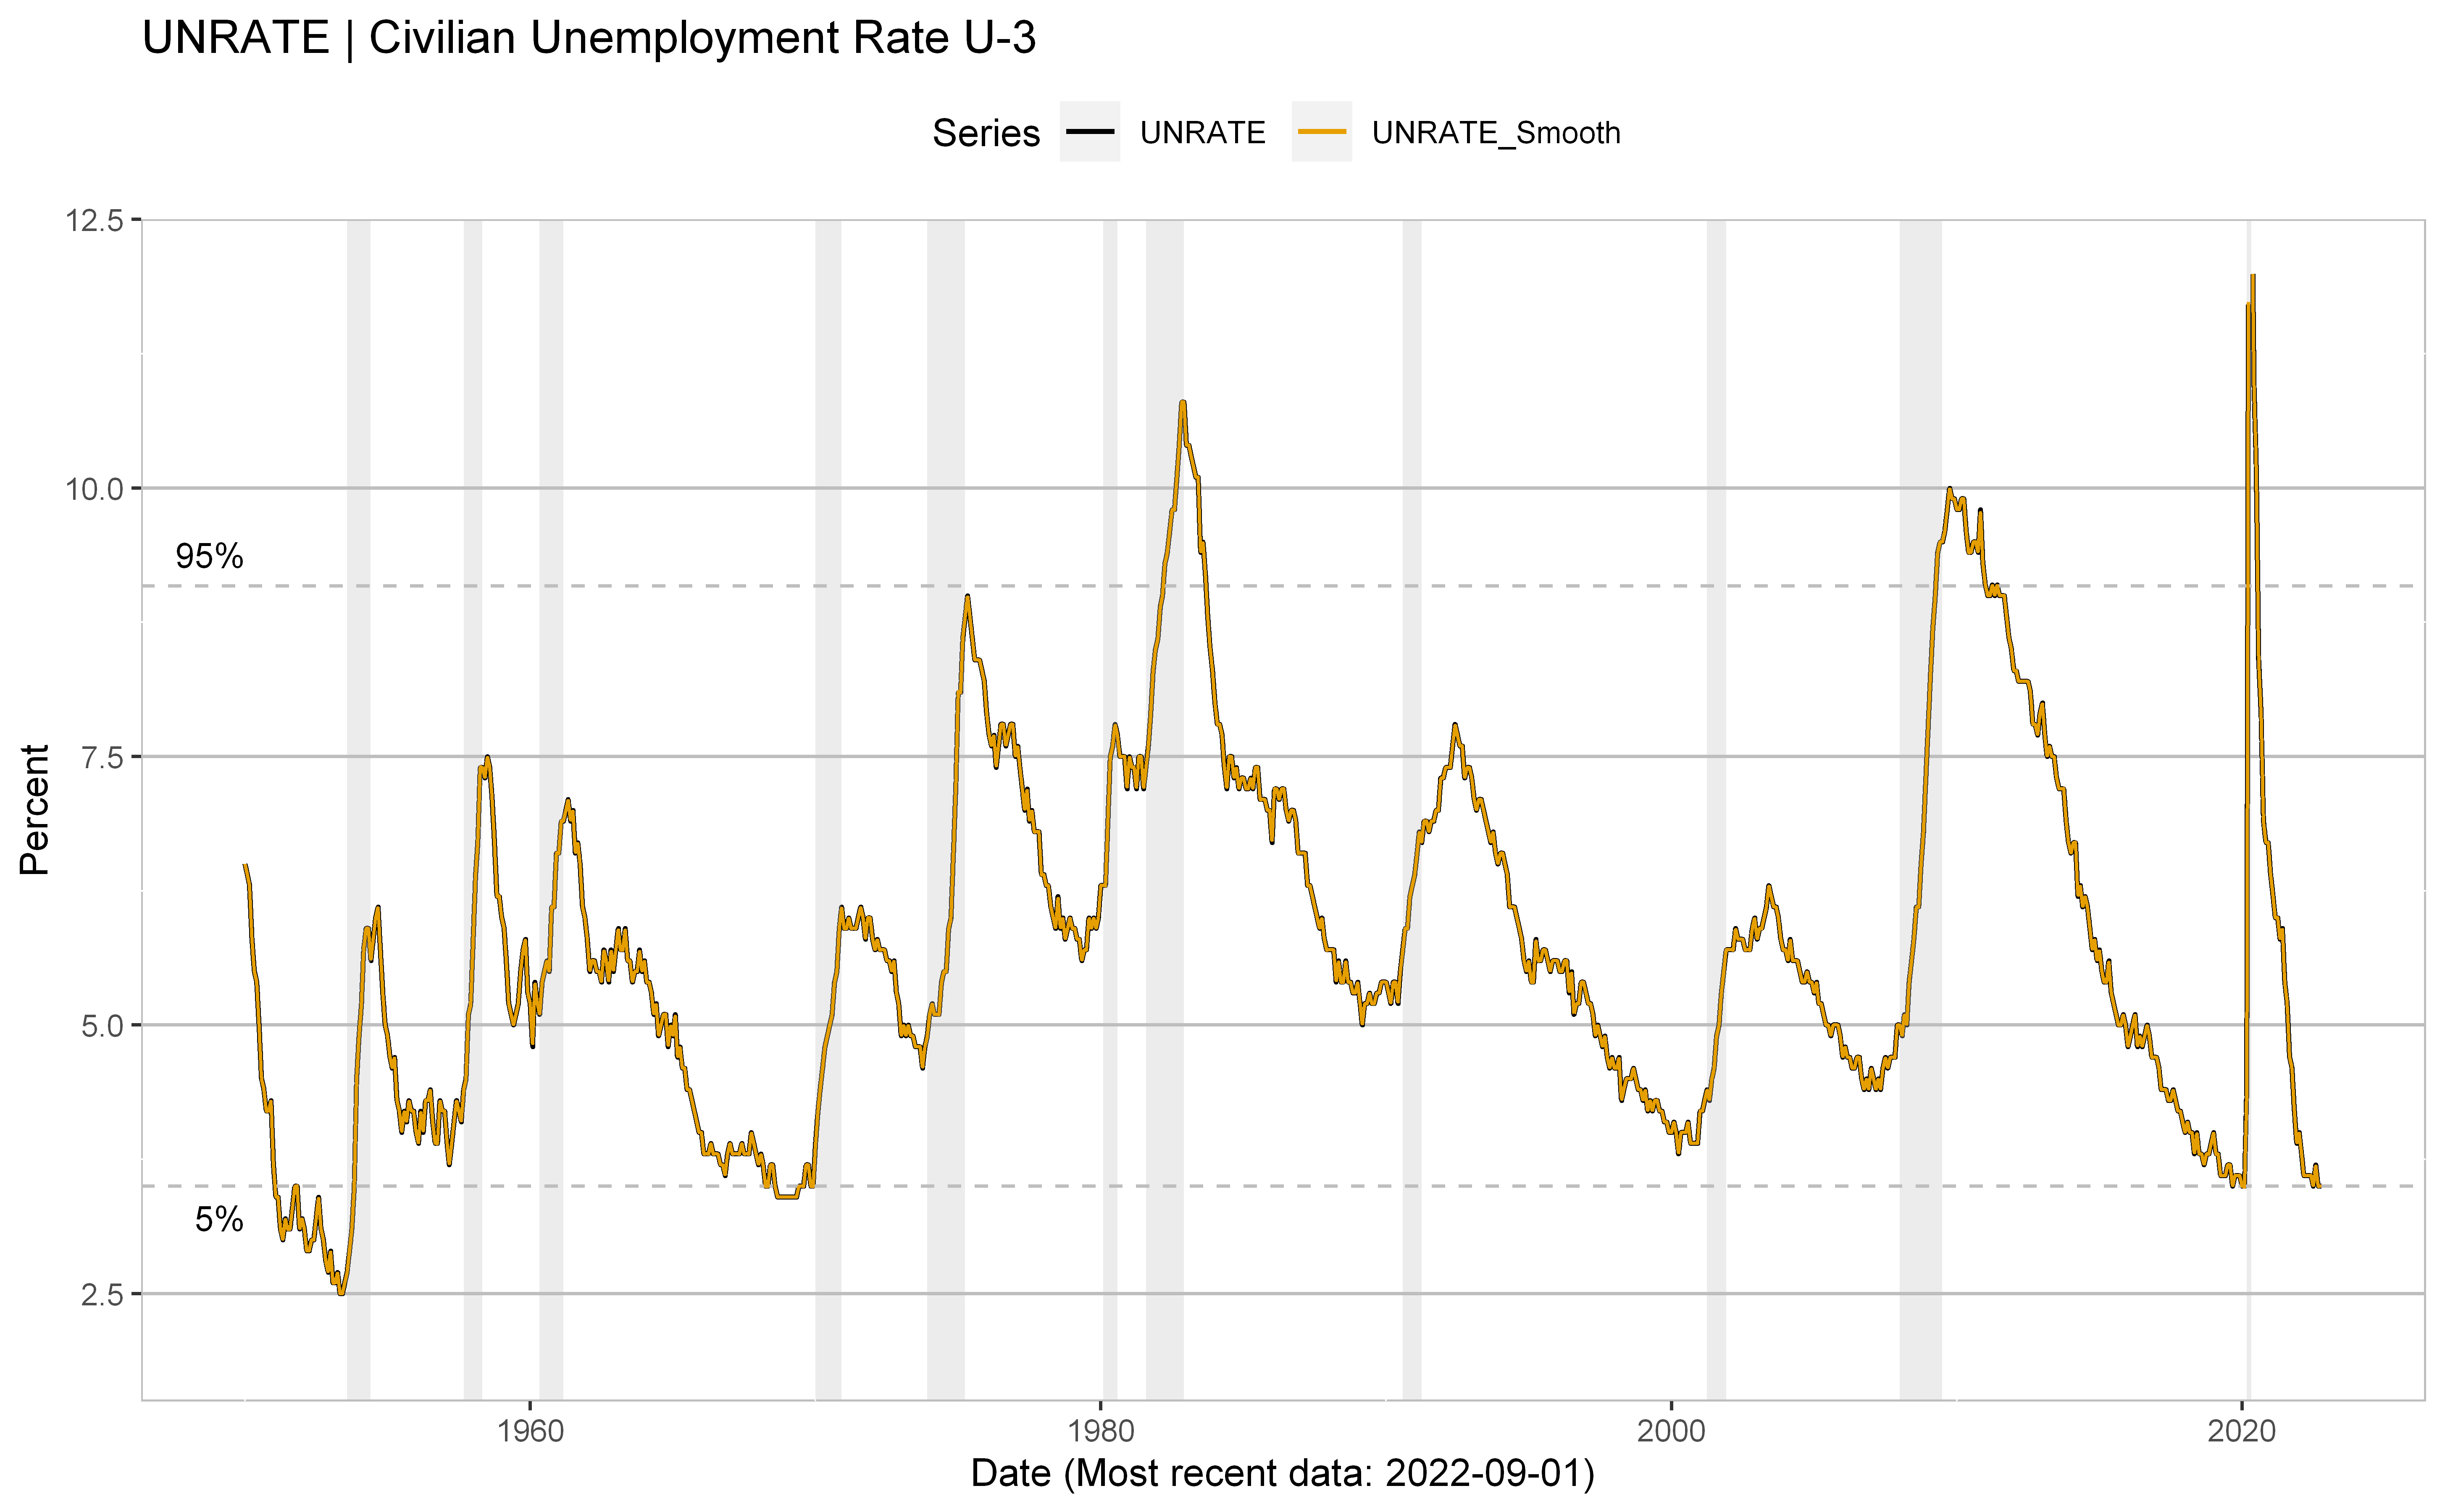

In [14]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "UNRATE"
datay_aux <- "UNRATE_Smooth"
ylim <- c(2, 12)
b.legend <- TRUE
b.percentile <- TRUE
myPlot <- plotSingle(dfRecession, df.data, "date", datay, getPlotTitle(df.symbols, datay), "Date", 
            getPlotYLabel(df.symbols, datay), c(as.Date("1jan1950","%d%b%Y"), Sys.Date()), ylim, b.legend, b.percentile)
myPlot + geom_line(data=df.data, aes_string(x="date", y=datay_aux, colour=shQuote(datay_aux)), na.rm = TRUE)

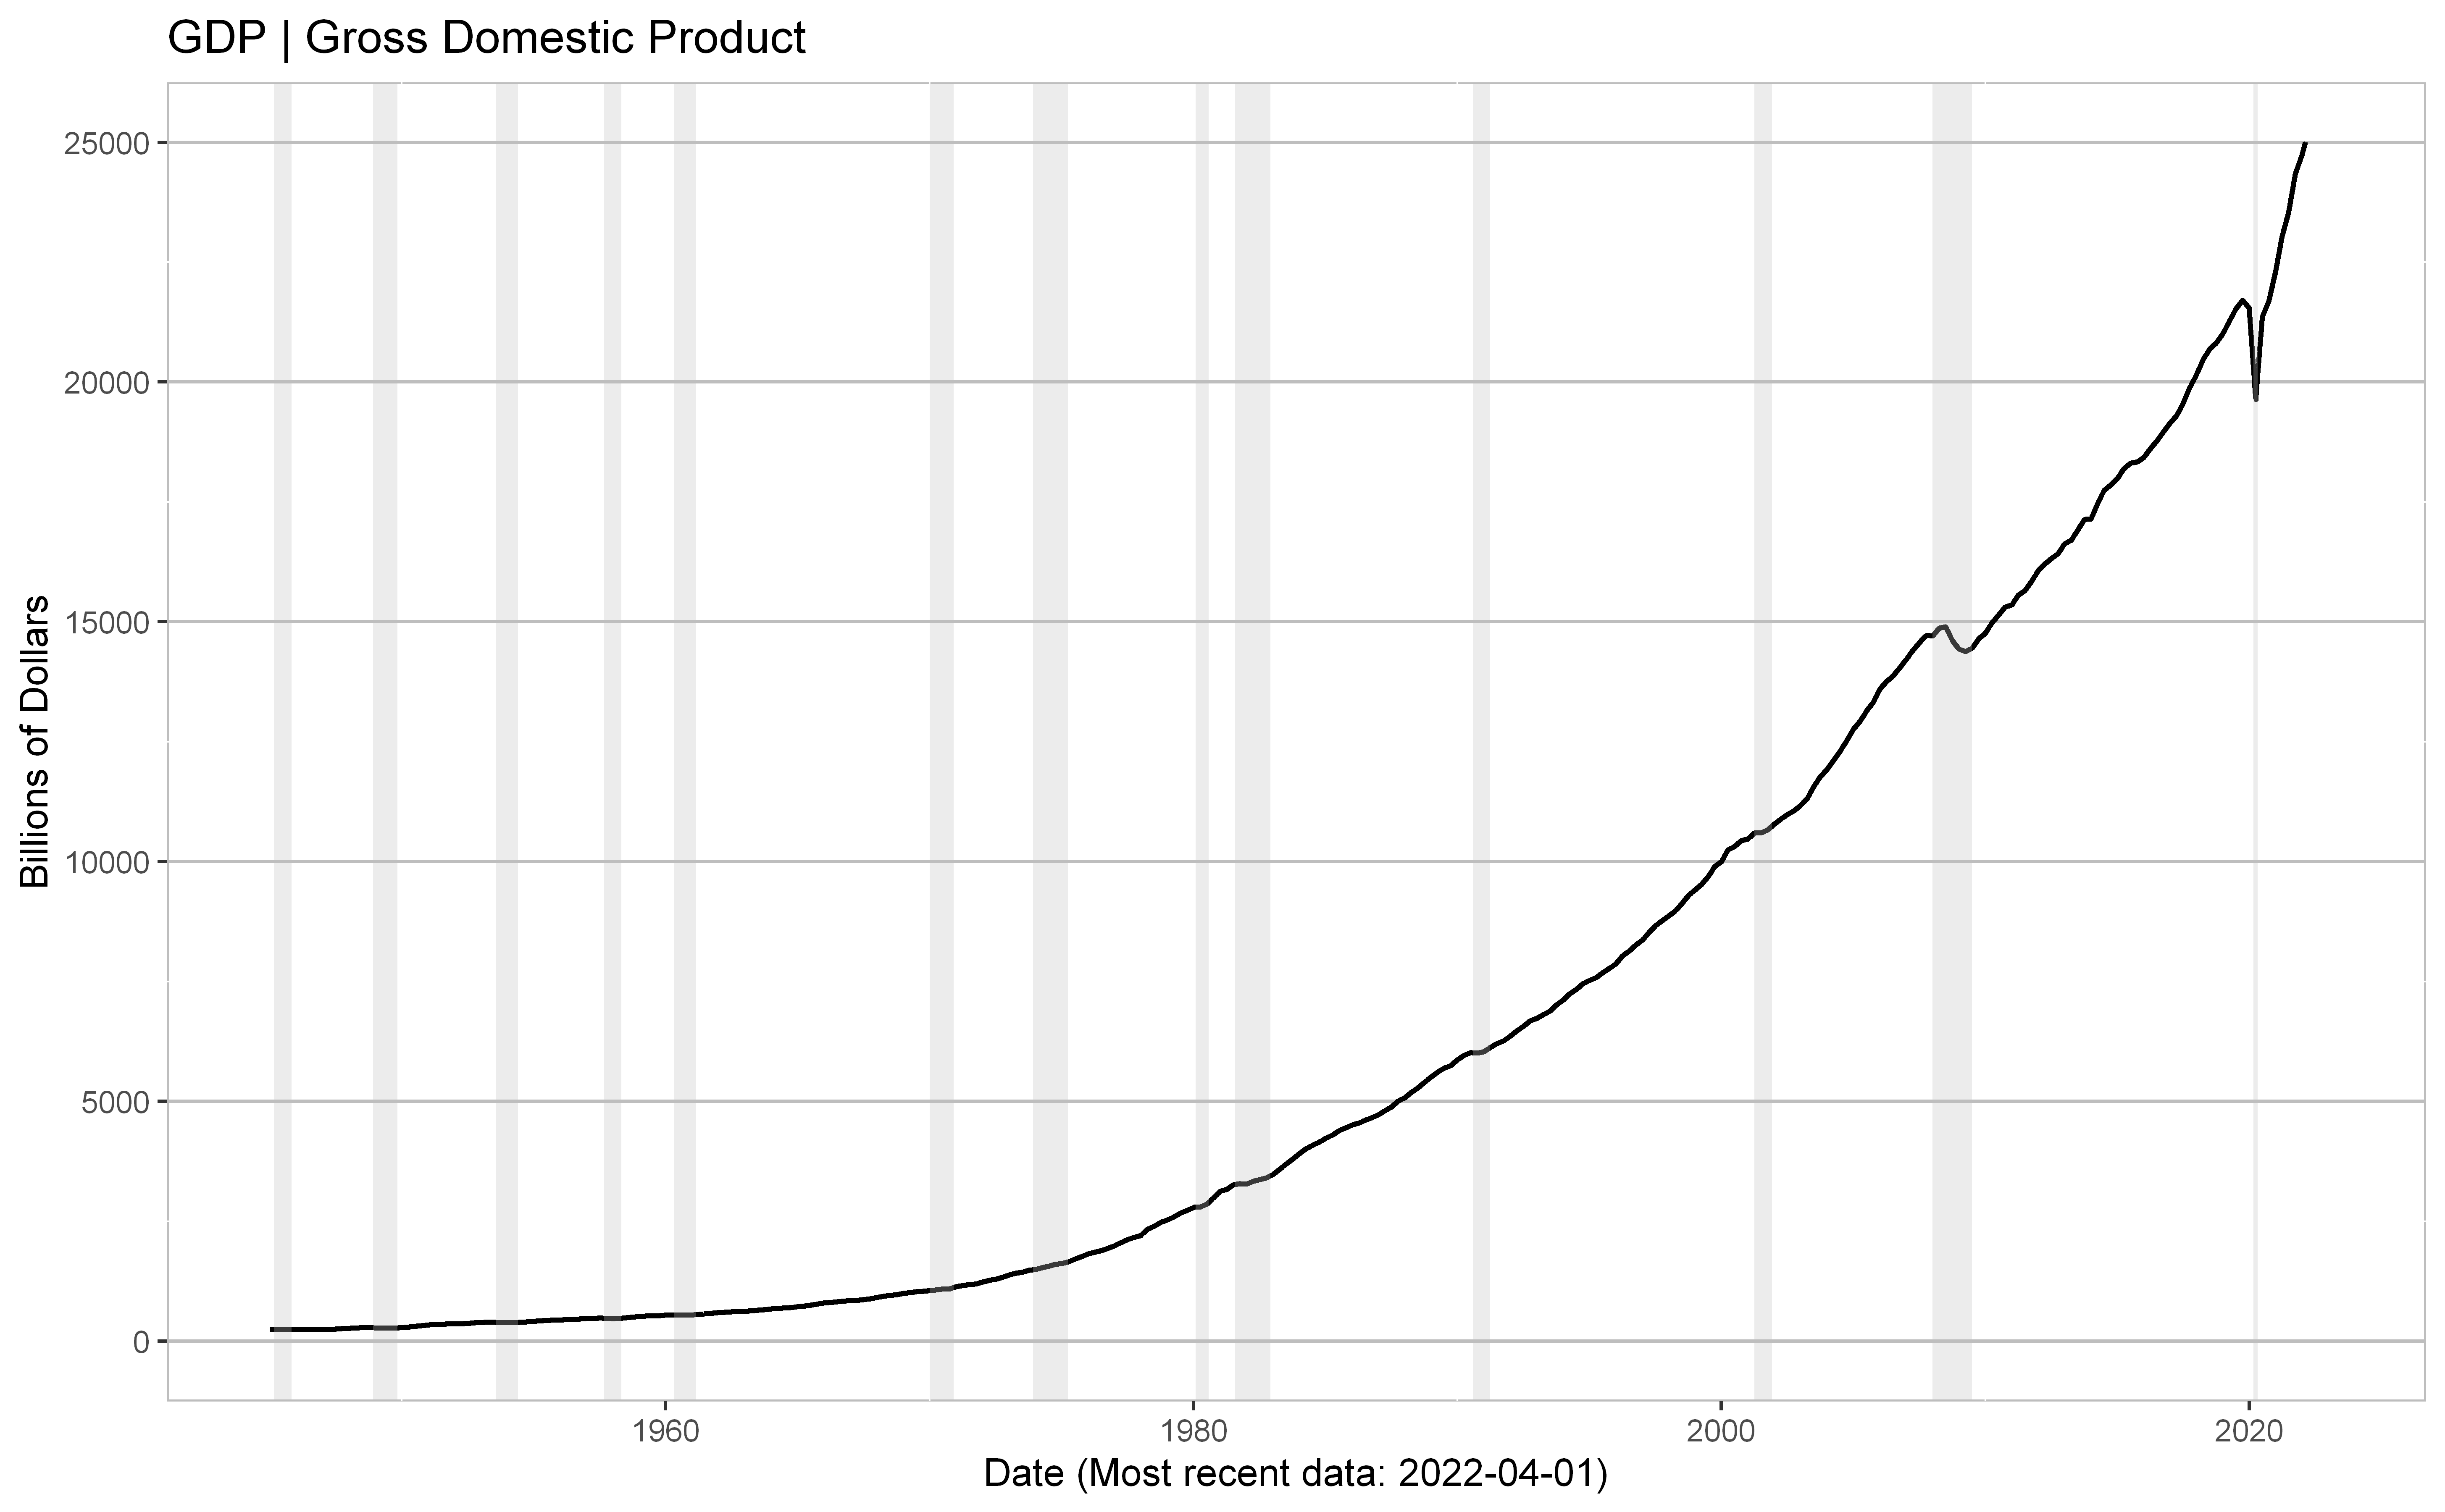

In [15]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "GDP"
ylim <- c(1, 25000)
plotSingleQuick(dfRecession, df.data, datay, ylim)

In [16]:
df.data$CPROFIT.by.GDP <- (df.data$CPROFIT / df.data$GDP) * 100

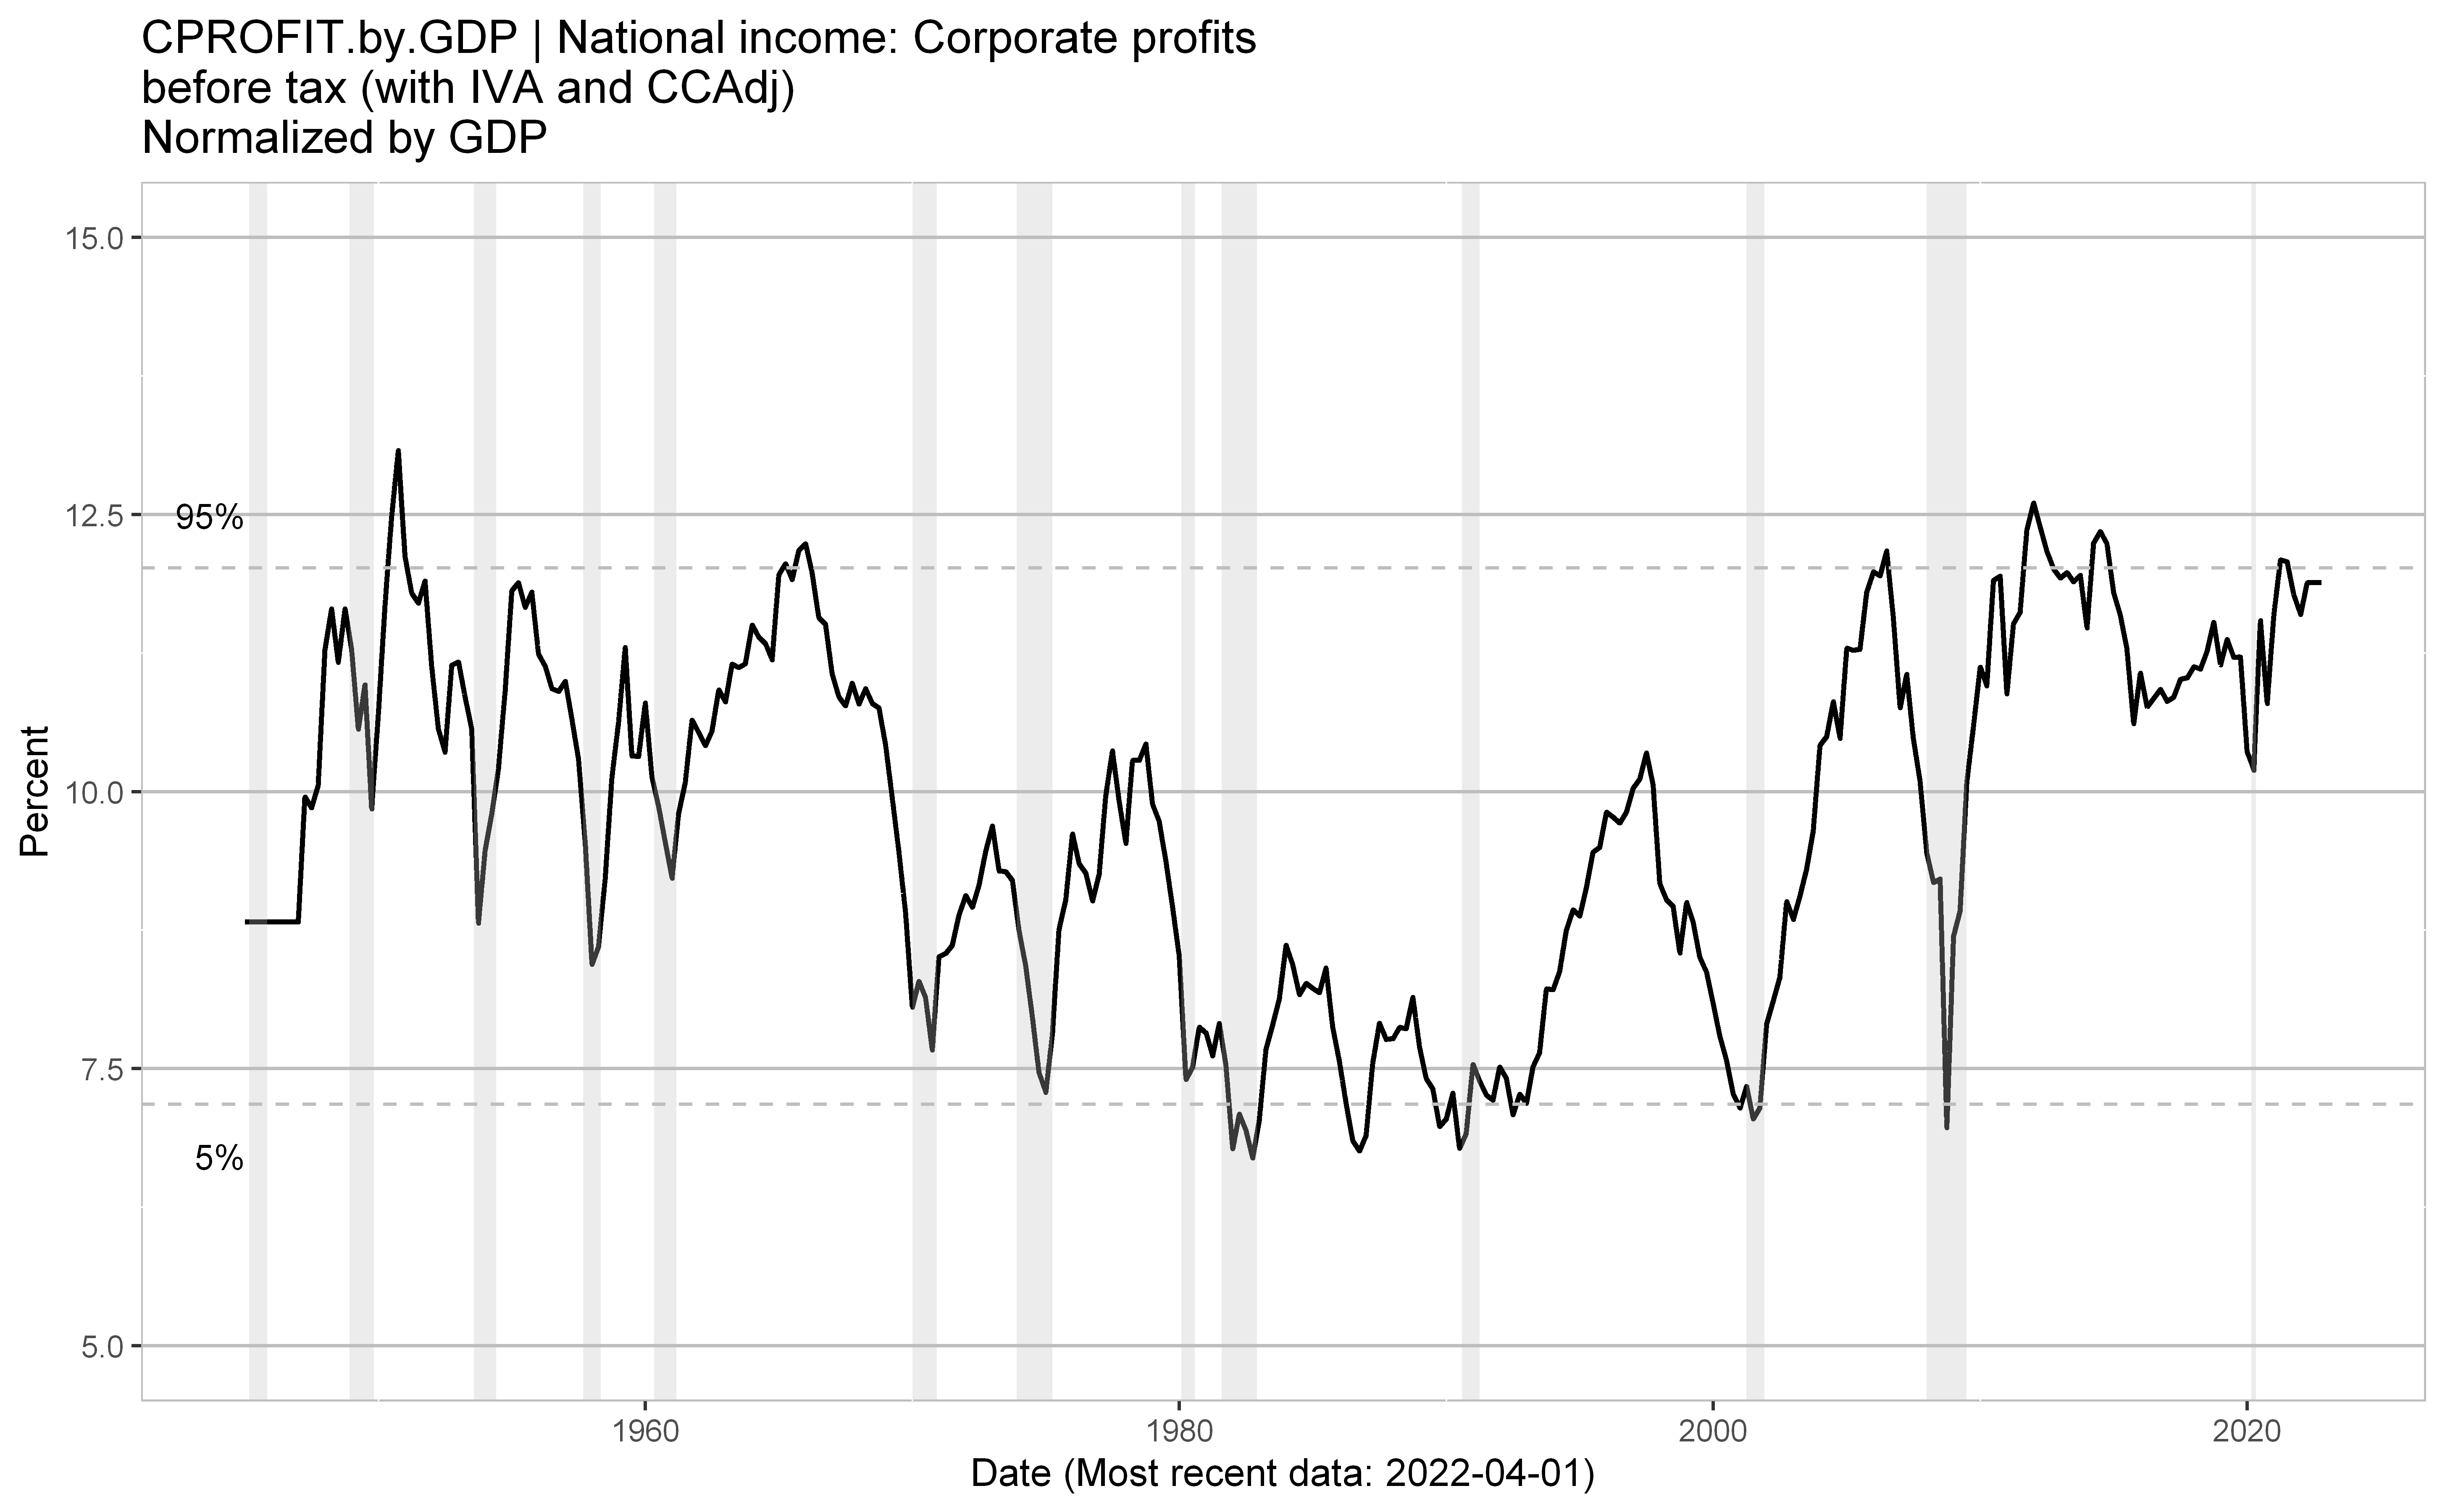

In [17]:
options(repr.plot.width = 9.7, repr.plot.height = 6, repr.plot.res = 600)
datay <- "CPROFIT.by.GDP"
ylim <- c(5, 15)
plotSingleQuick(dfRecession, df.data, datay, ylim, b.percentile = TRUE)

# Recession Initiation (Switch Model)

Plot the initiation period of each recession

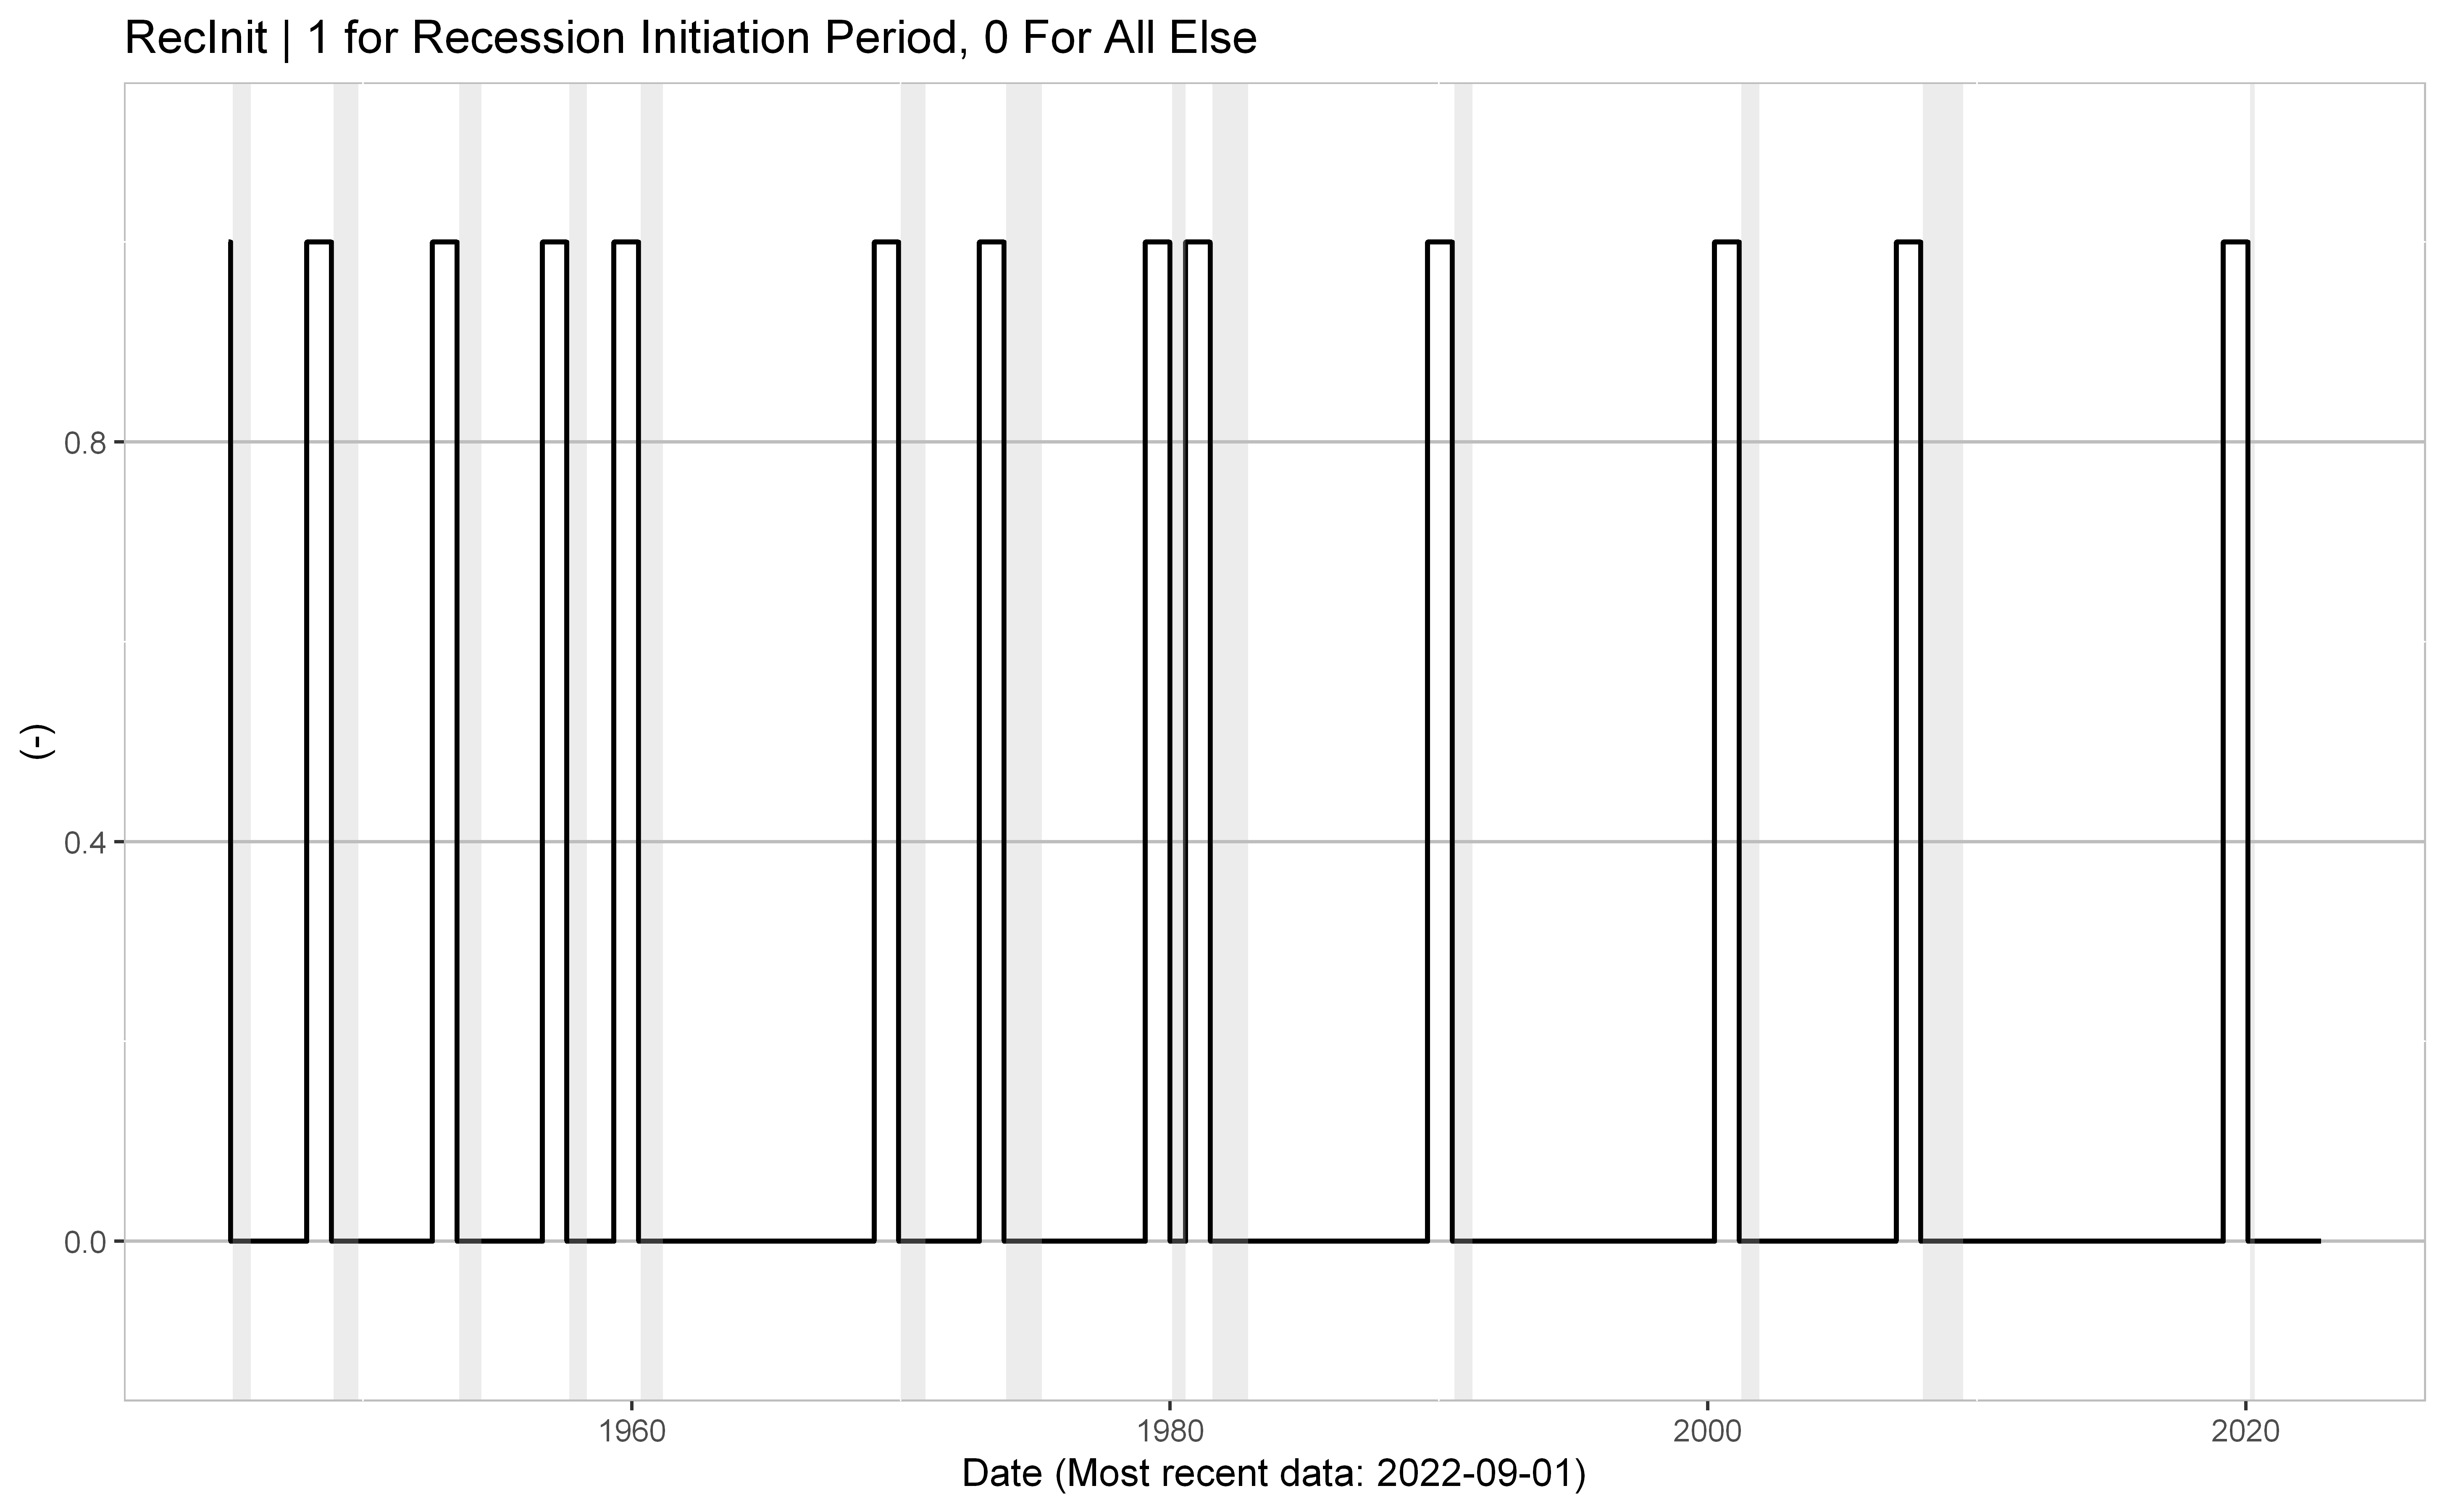

In [18]:
datay <- "RecInit"
ylim <- c(-0.1, 1.1)
plotSingleQuick(dfRecession, df.data, datay, ylim)

# Recession Initiation (Smooth Model)

The previous section used a switched model (Yes/No), but this section uses a smoothed version that is more like a probability value..

Plot the smoothed version of the initiation period of the recession

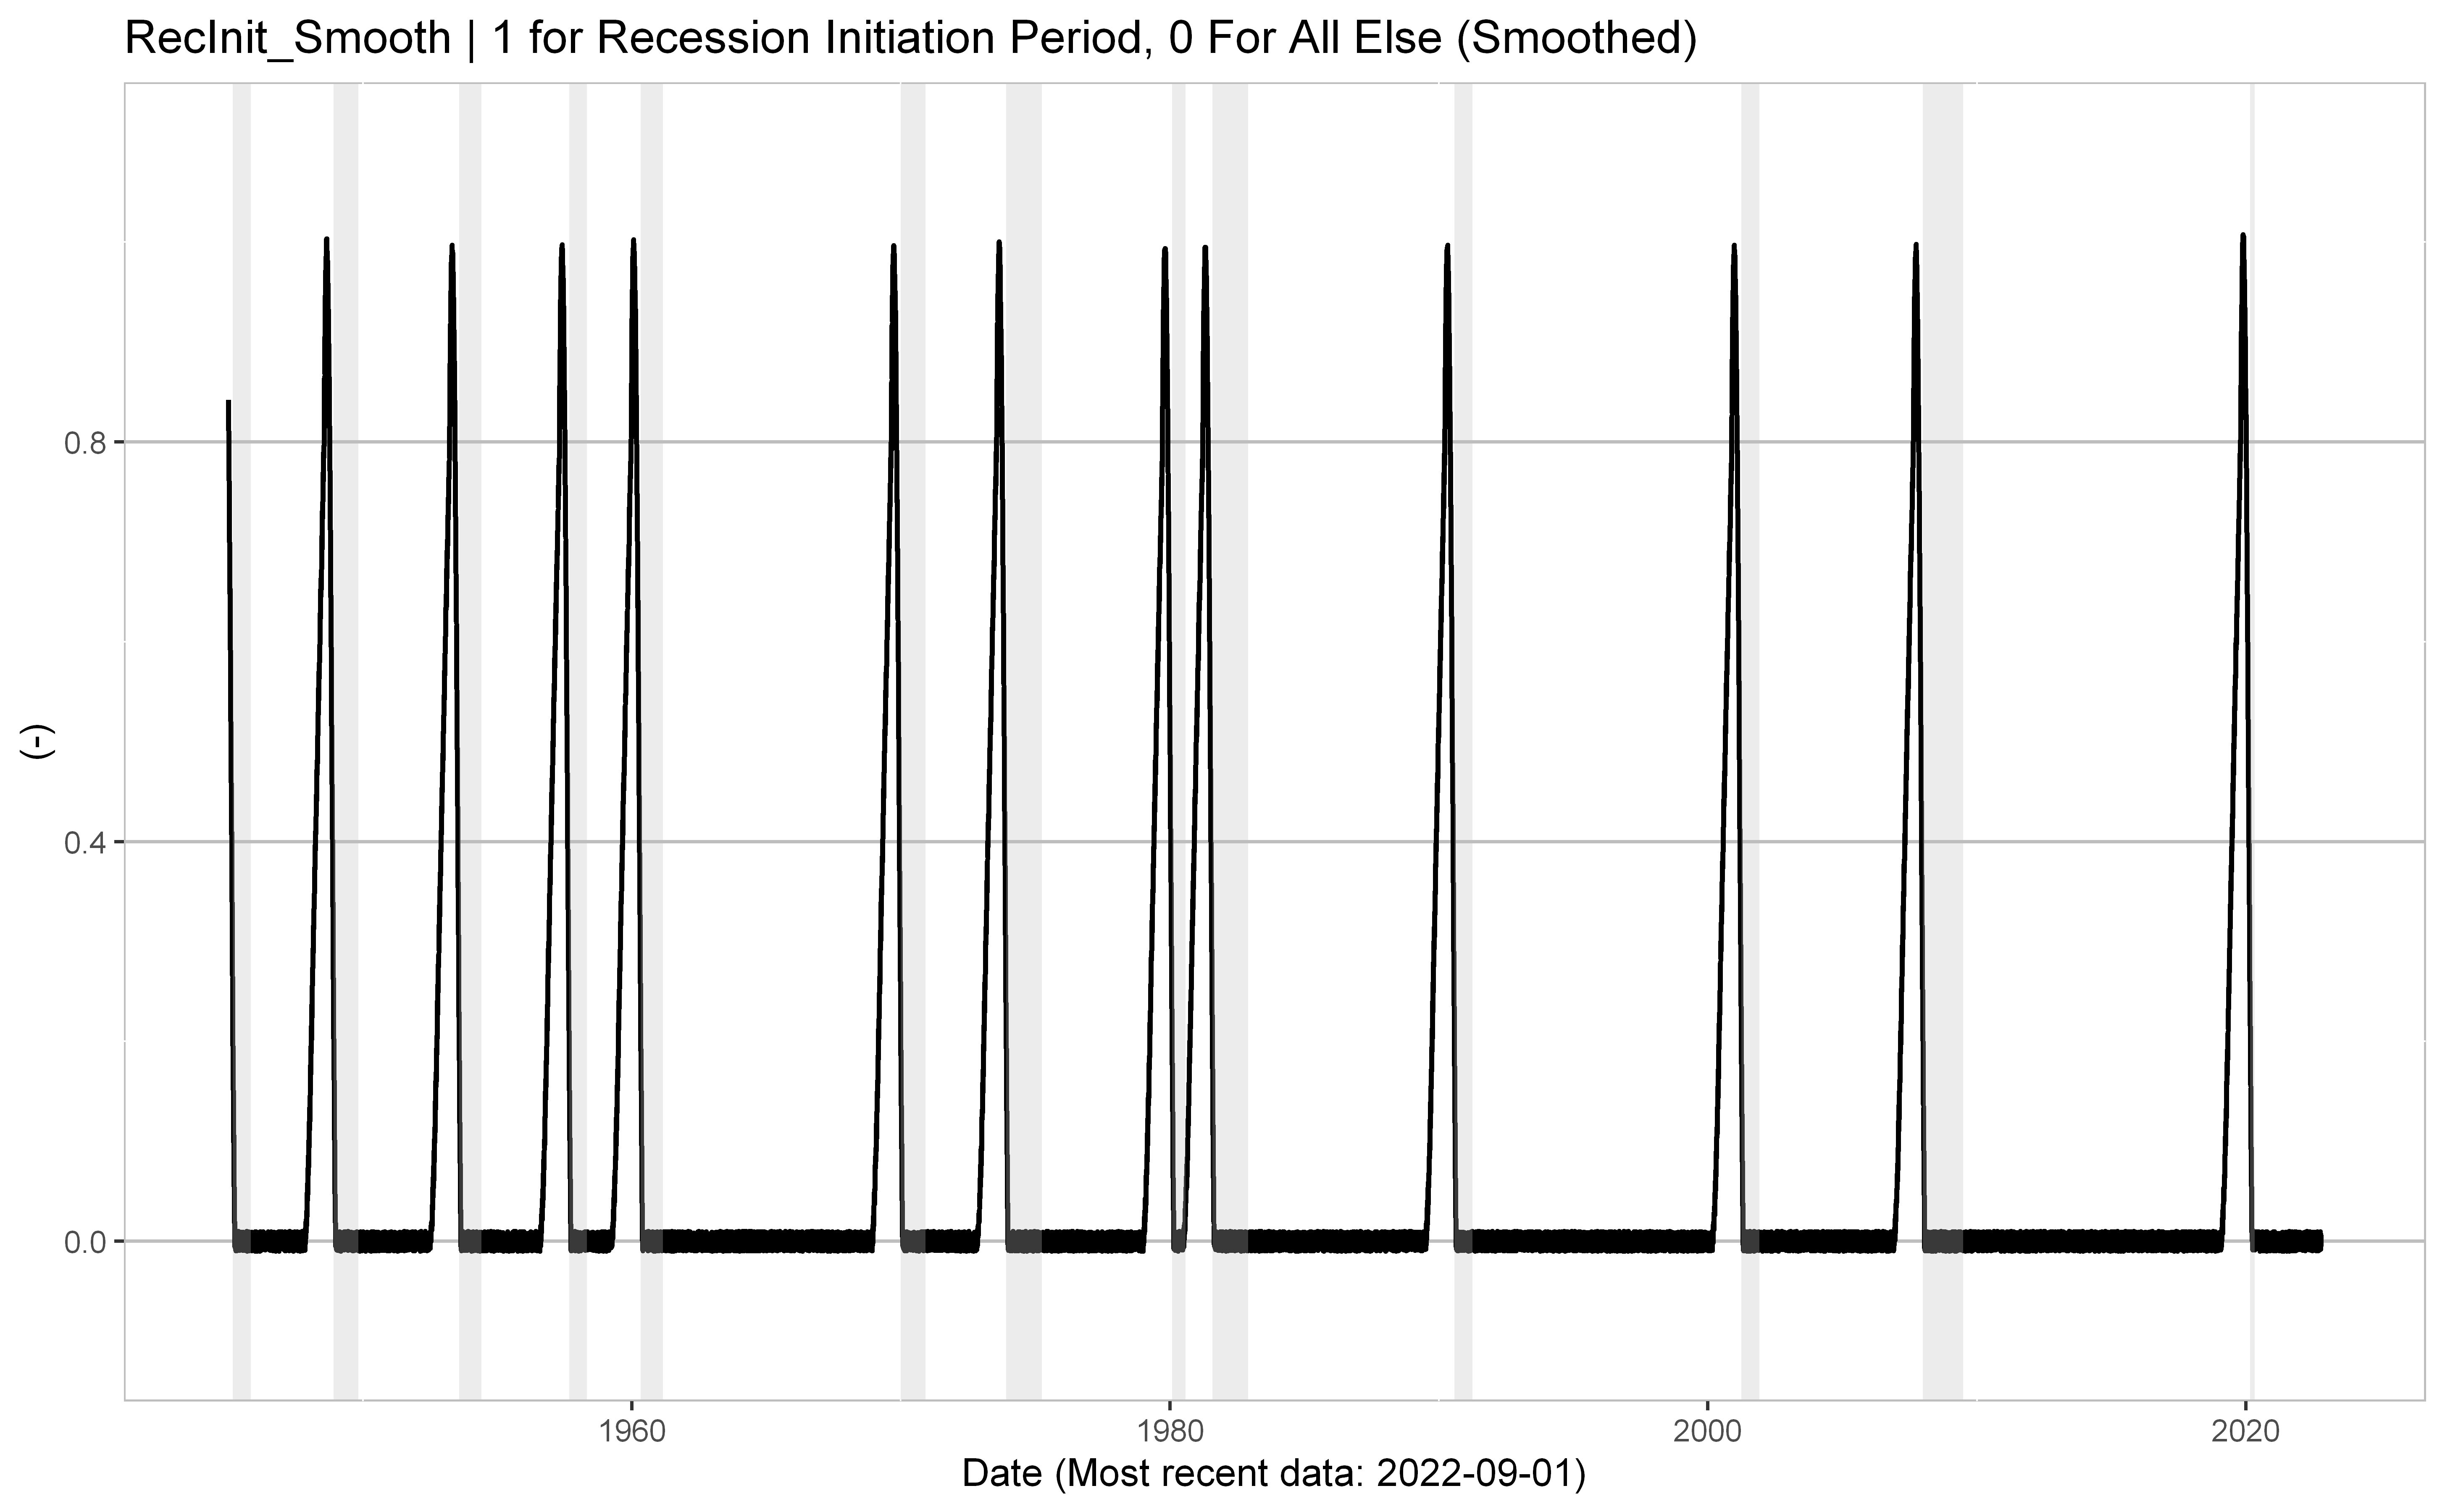

In [19]:
datay <- "RecInit_Smooth"
ylim <- c(-0.1, 1.1)
plotSingleQuick(dfRecession, df.data, datay, ylim)

# Data Exploration

There are some great plotting and visualization tools in the `quantmod` package, but for the prediction work `ggplot` will be used. This section walks through each of the data sets and notes features and relationships that would be helpful in building a trading strategy.

## S&P 500

One place to begin is with the relationship between stock prices and recessions. The predictor needs to be able to identify the onset of recession before the market declines. In theory, this predictor would give enough warning to cycle out of equity and into something more like cash or bonds. The plot below shows the S&P 500 open values in log-linear format. The market reaches a peak before most recessions, typically 6-9 months before the recession, shown by the blue rectangles in the plot below. A good predictor will correlate with the peak prior to an upcoming recession. 

The growth of equities makes it hard to compare peaks. For example, using the GDP deflator the last two decades are an order of mangitude higher than the historical data.


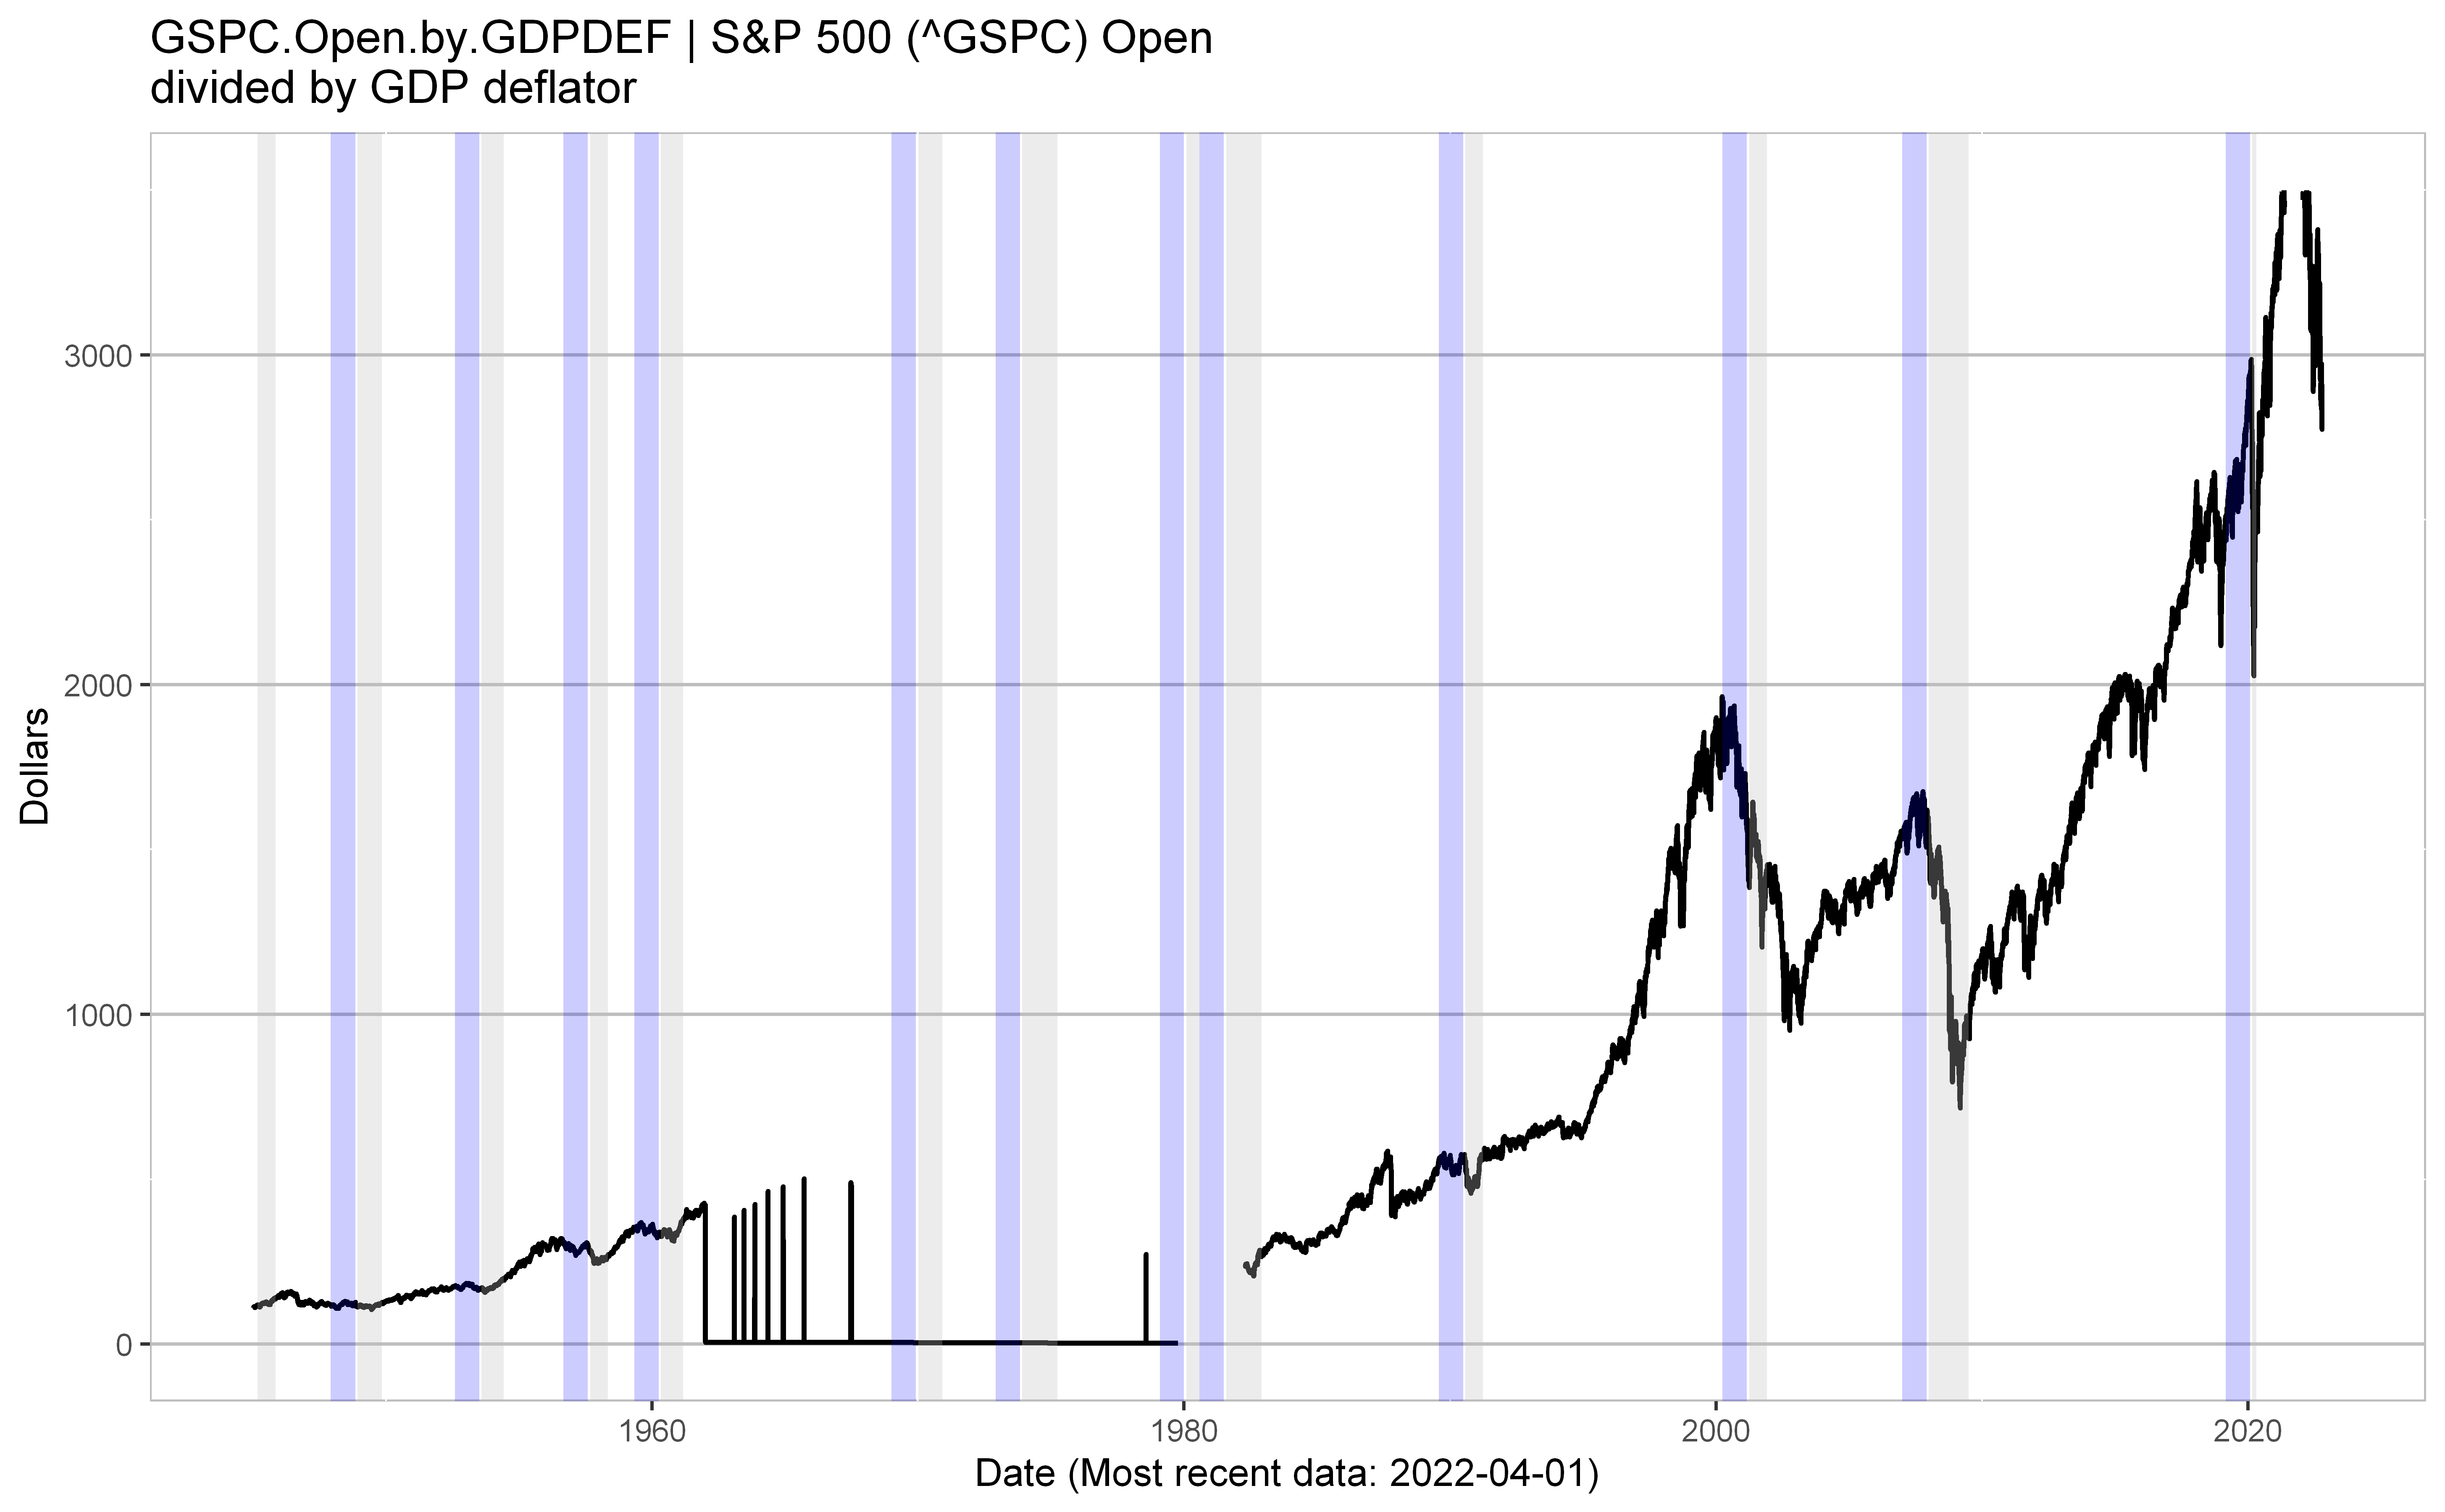

In [20]:
datay <- "GSPC.Open.by.GDPDEF"
ylim <- c(2.5, 3500)
myPlot <- plotSingleQuick(dfRecession, df.data, datay, ylim)
myPlot + geom_rect(
  data = dfRecession,
  aes(
    xmin = initStart,
    xmax = initEnd,
    ymin = -Inf,
    ymax = Inf
  ),
  fill = "blue",
  alpha = 0.2,
  na.rm = TRUE
)

Taking the log of the data results in a series where the peaks in the historical data can be seen and compared to present day pricing.

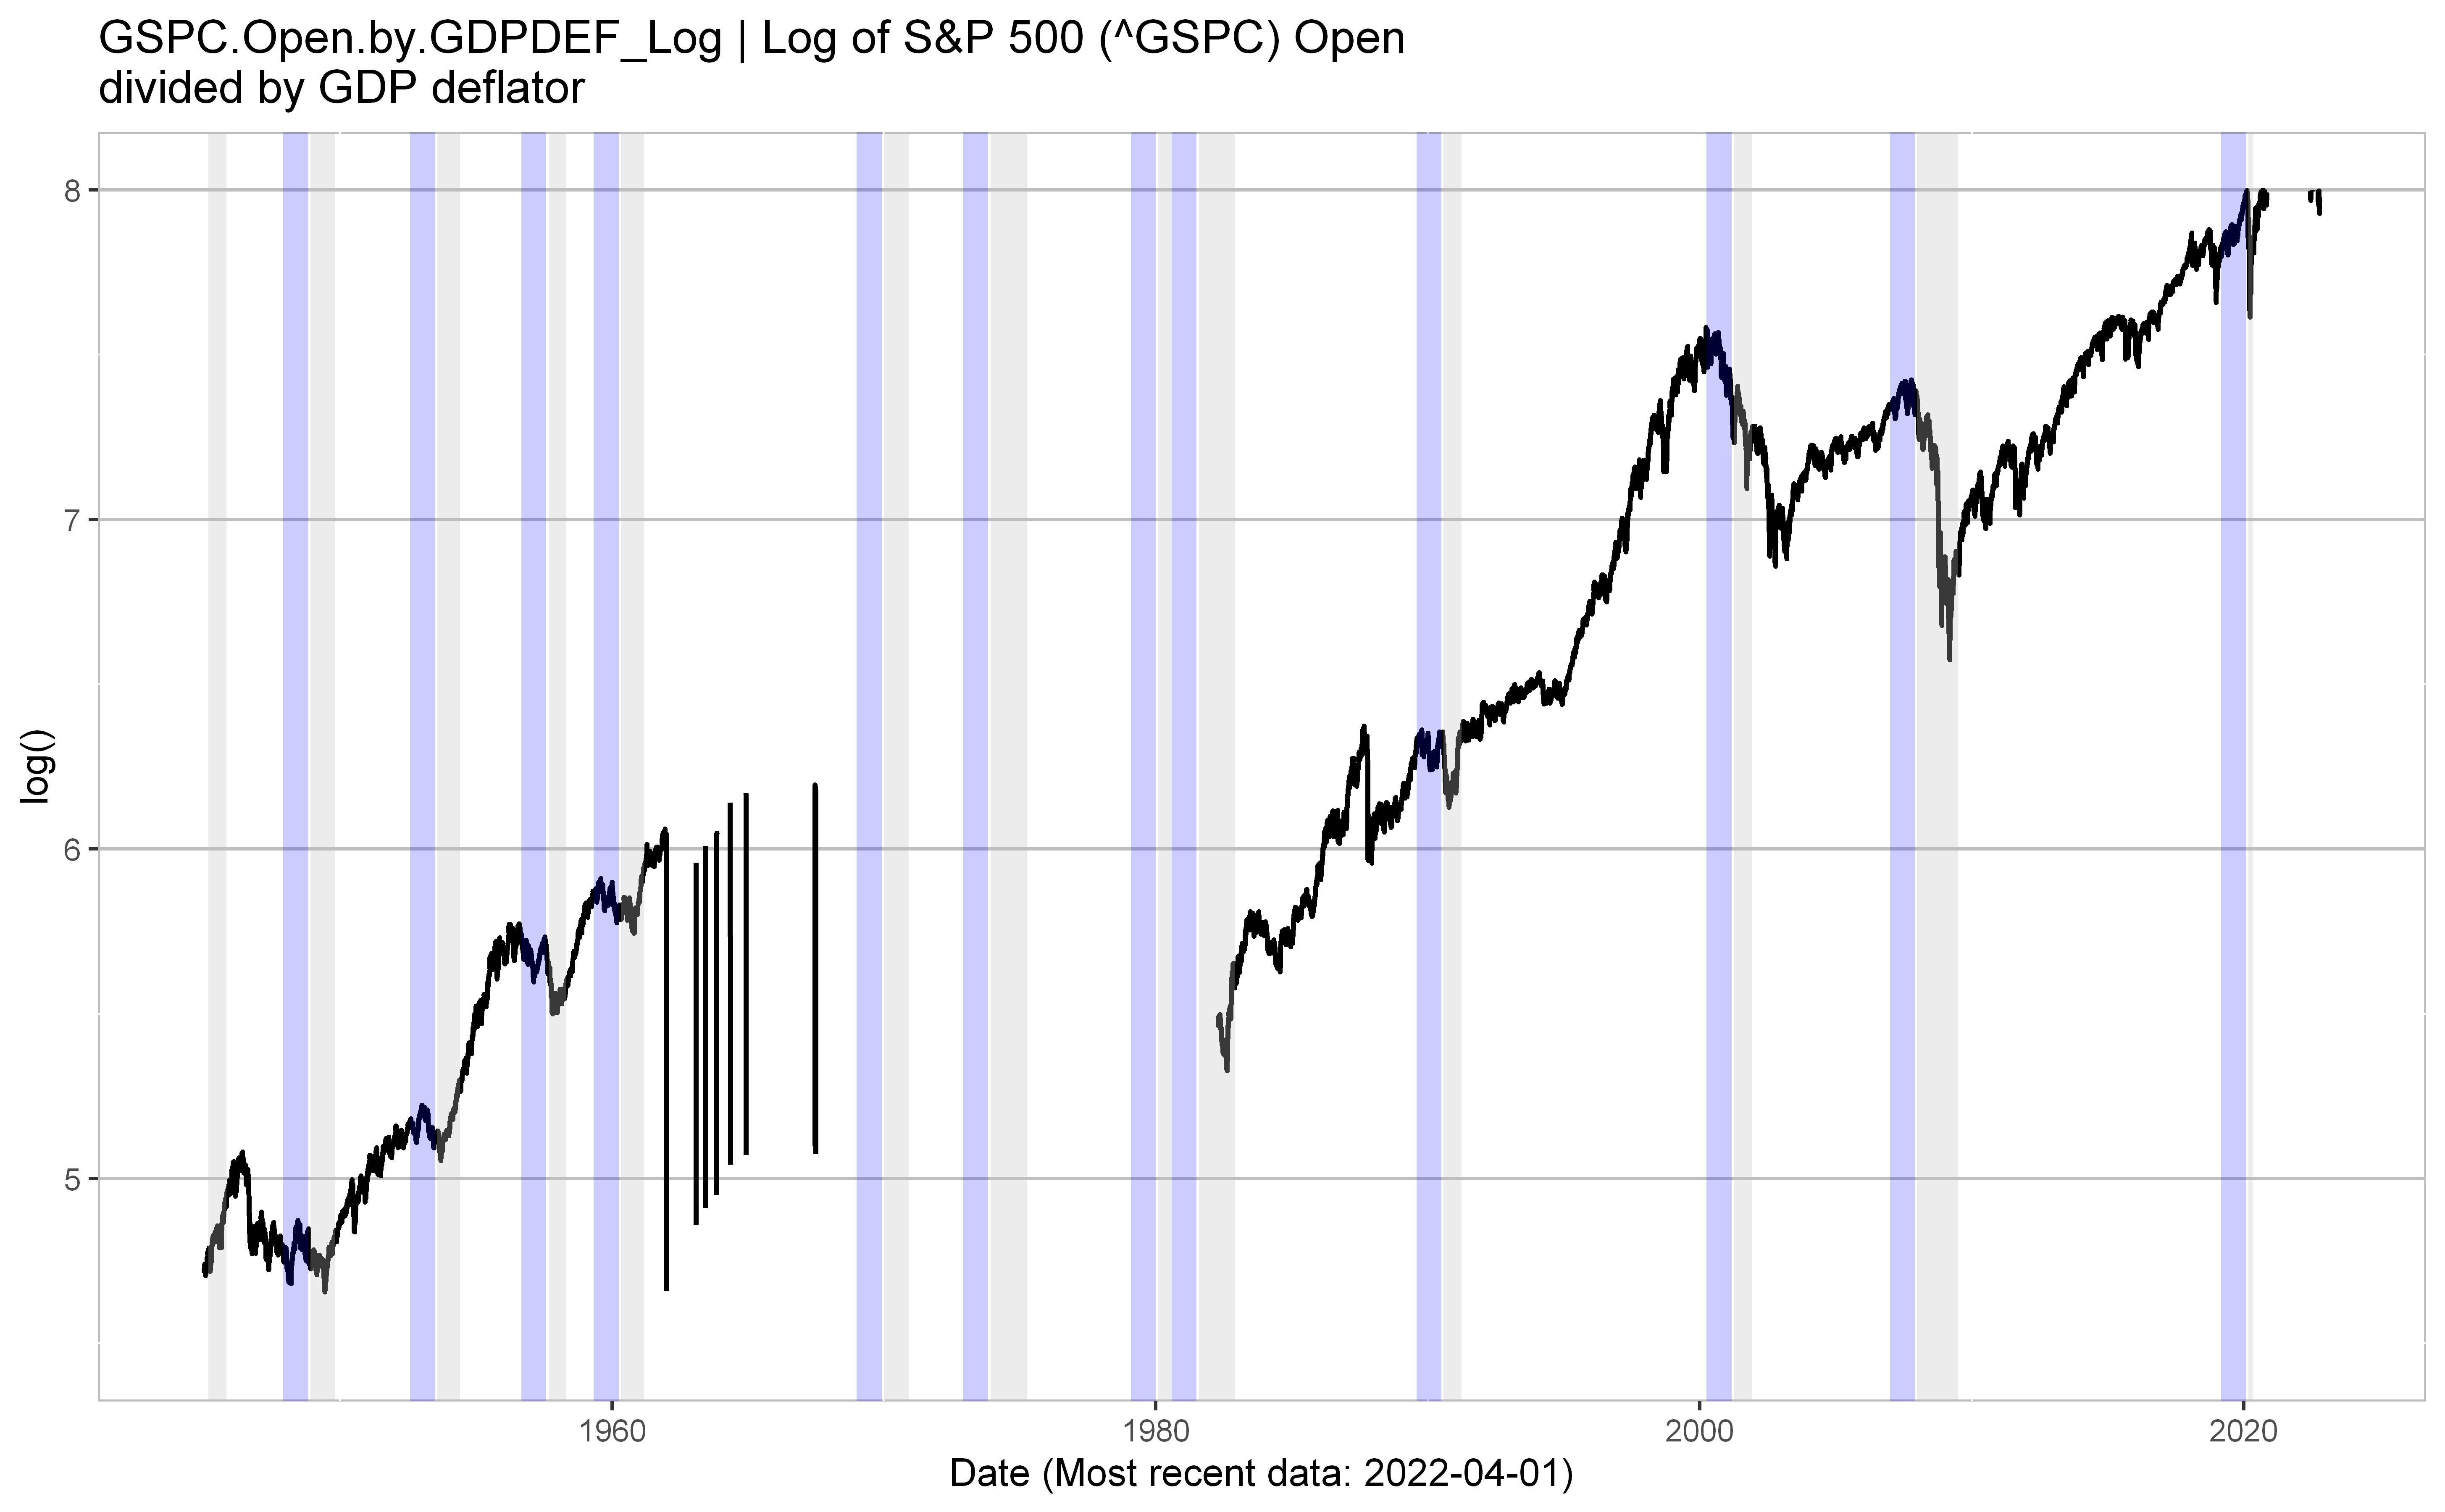

In [21]:
datay <- "GSPC.Open.by.GDPDEF_Log"
ylim <- c(4.5, 8)
myPlot <- plotSingleQuick(dfRecession, df.data, datay, ylim)
myPlot + geom_rect(
  data = dfRecession,
  aes(
    xmin = initStart,
    xmax = initEnd,
    ymin = -Inf,
    ymax = Inf
  ),
  fill = "blue",
  alpha = 0.2,
  na.rm = TRUE
)

The features in the S&P curve that are most interesting are the peaks (sell signal) and the troughs (buy signal). One way to quantify the peaks is look at the derivative and see where it crosses zero. The crossing of interest are positive to negative indicating the market is rolling over. Most of the peaks occur just prior to or during the blue intervals used for training.

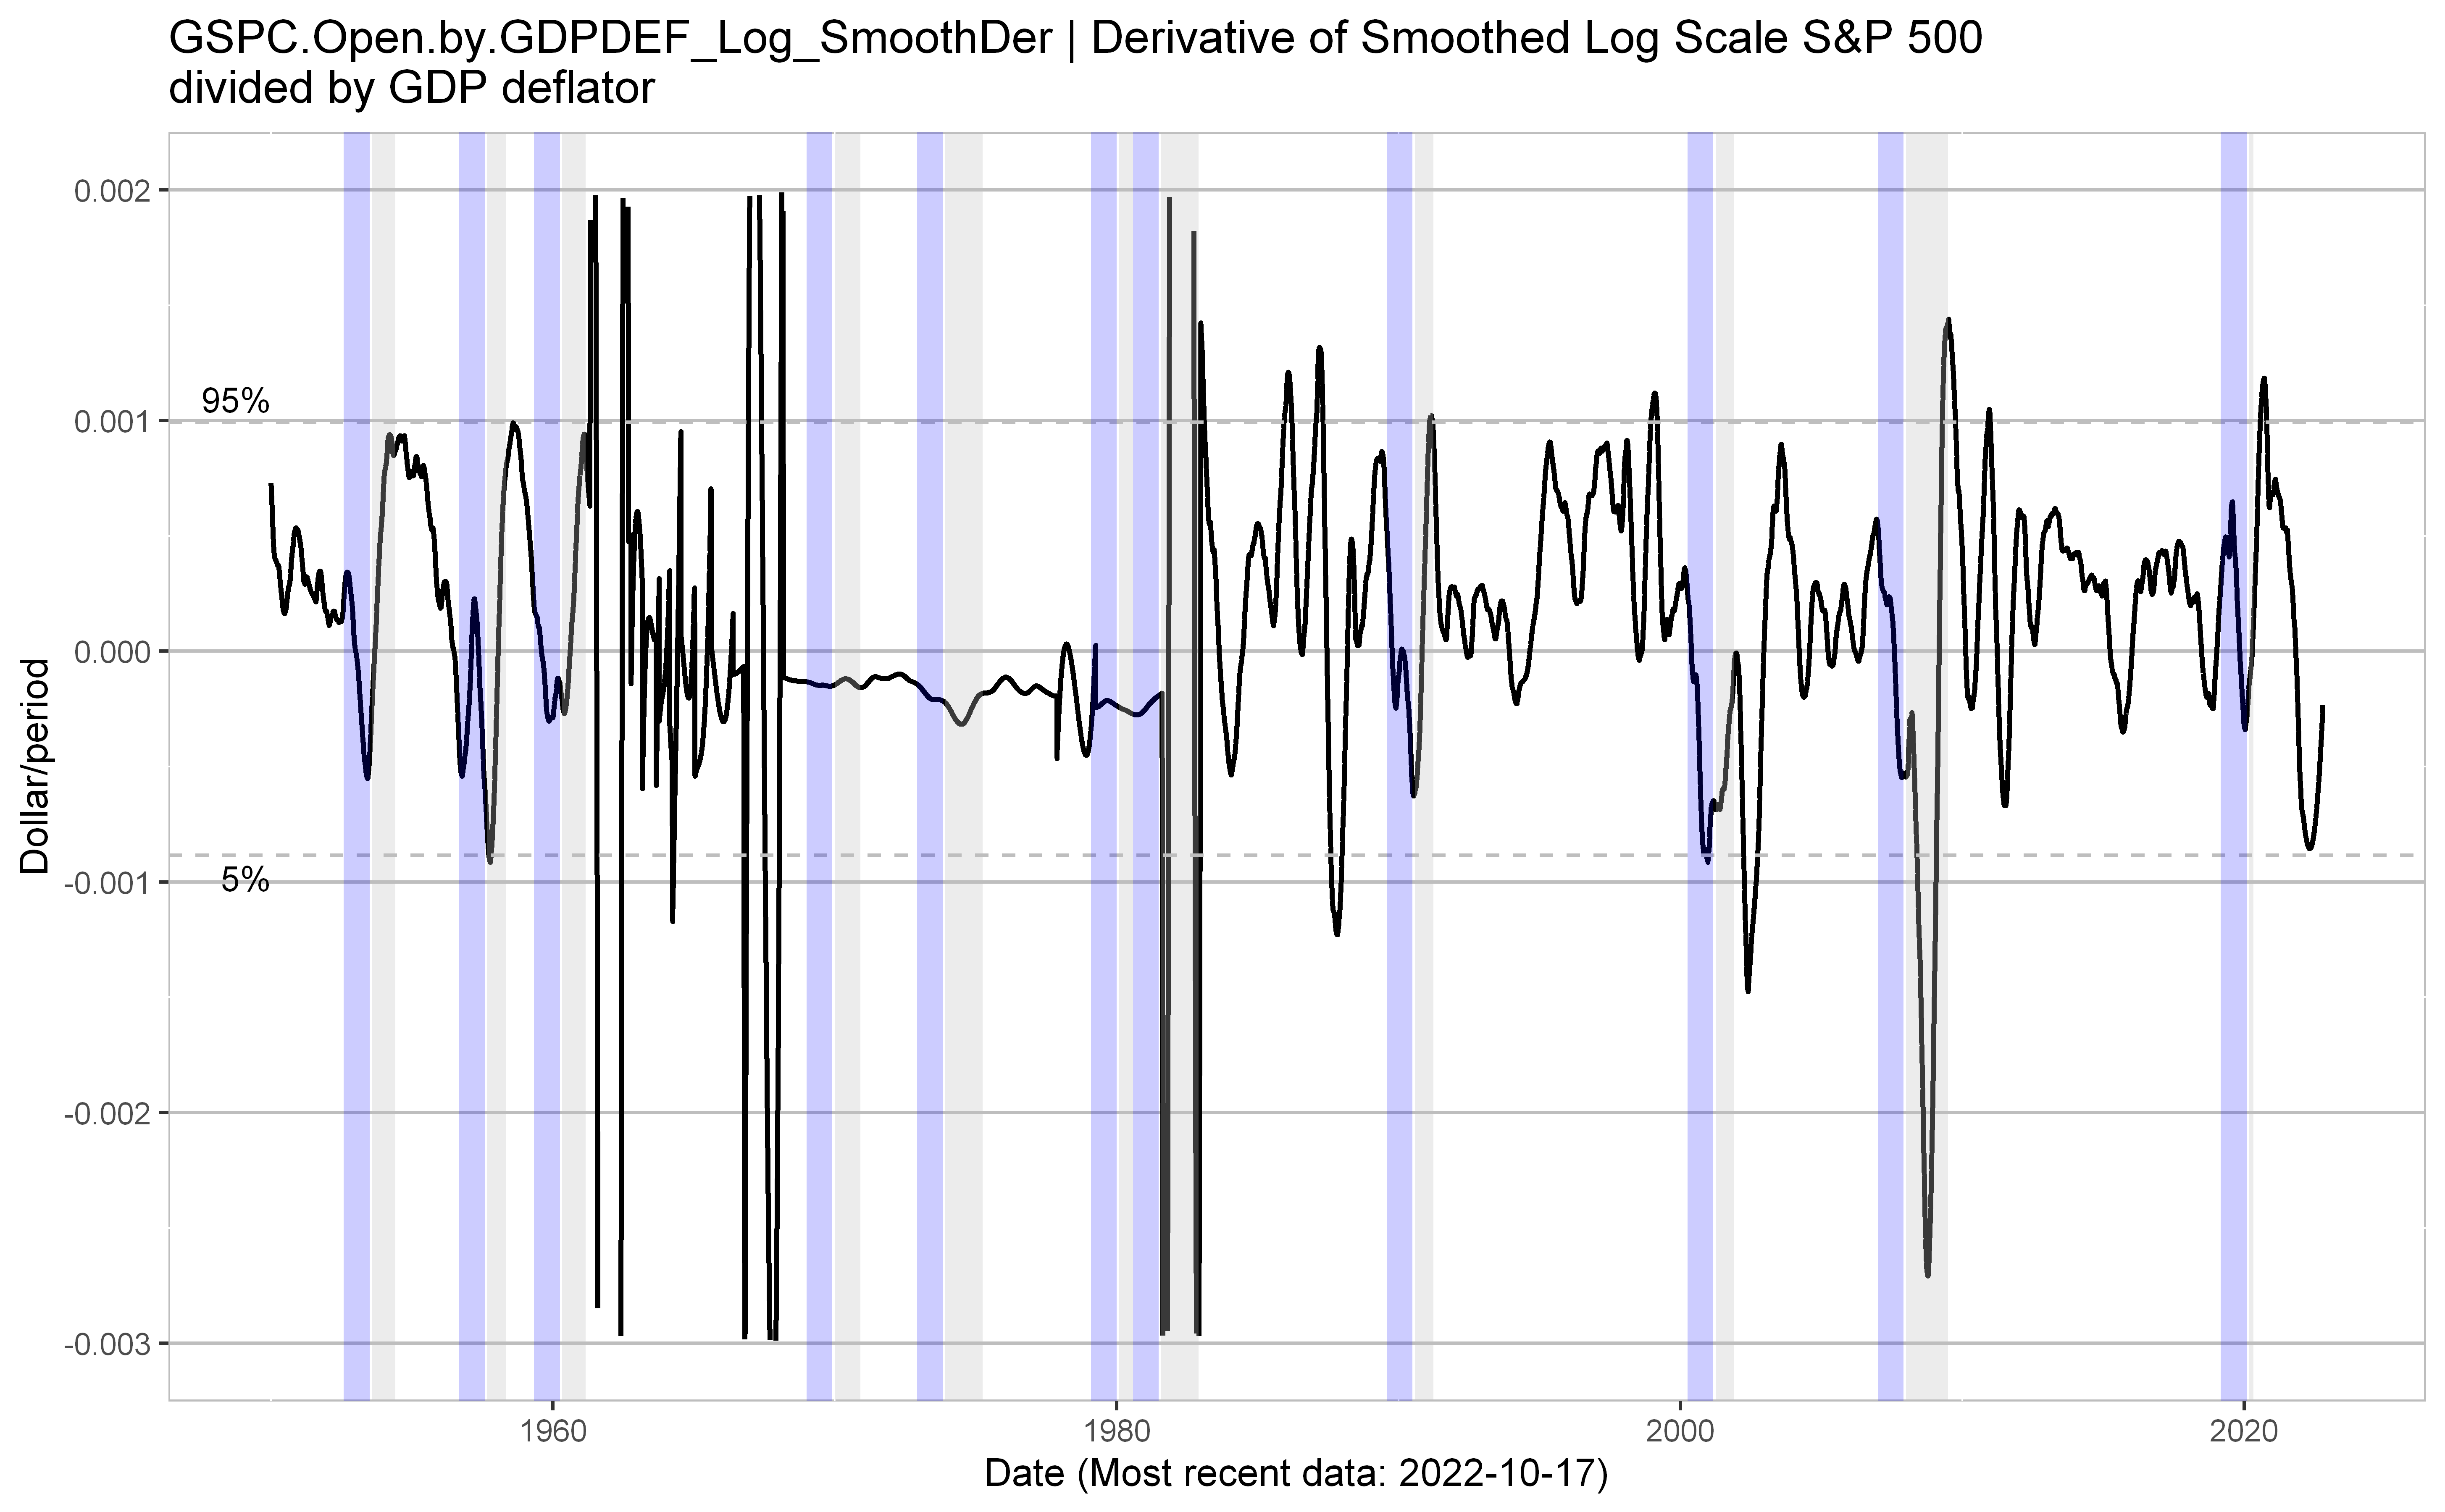

In [22]:
datay <- "GSPC.Open.by.GDPDEF_Log_SmoothDer"
ylim <- c(-0.003, 0.002)
dt.start <- as.Date("1jan1950", "%d%b%Y")
b.legend <- FALSE
b.percentile <- TRUE
my.plot <- plotSingleQuick(dfRecession,
                df.data,
                datay,
                ylim,
                dt.start,
                b.legend,
                b.percentile)
my.plot <-
  my.plot + geom_rect(
    data = dfRecession,
    aes(
      xmin = initStart,
      xmax = initEnd,
      ymin = -Inf,
      ymax = Inf
    ),
    fill = "blue",
    alpha = 0.2,
    na.rm = TRUE
  )

my.plot

The derivative data suggests a way to improve the indicator by adding a single rule: if there is a negative slope zero crossing before the default training period, move the training date to that point. This approach will allow the algorithm to capture more of the gains of the market. It is also going to be a more challenging fit.

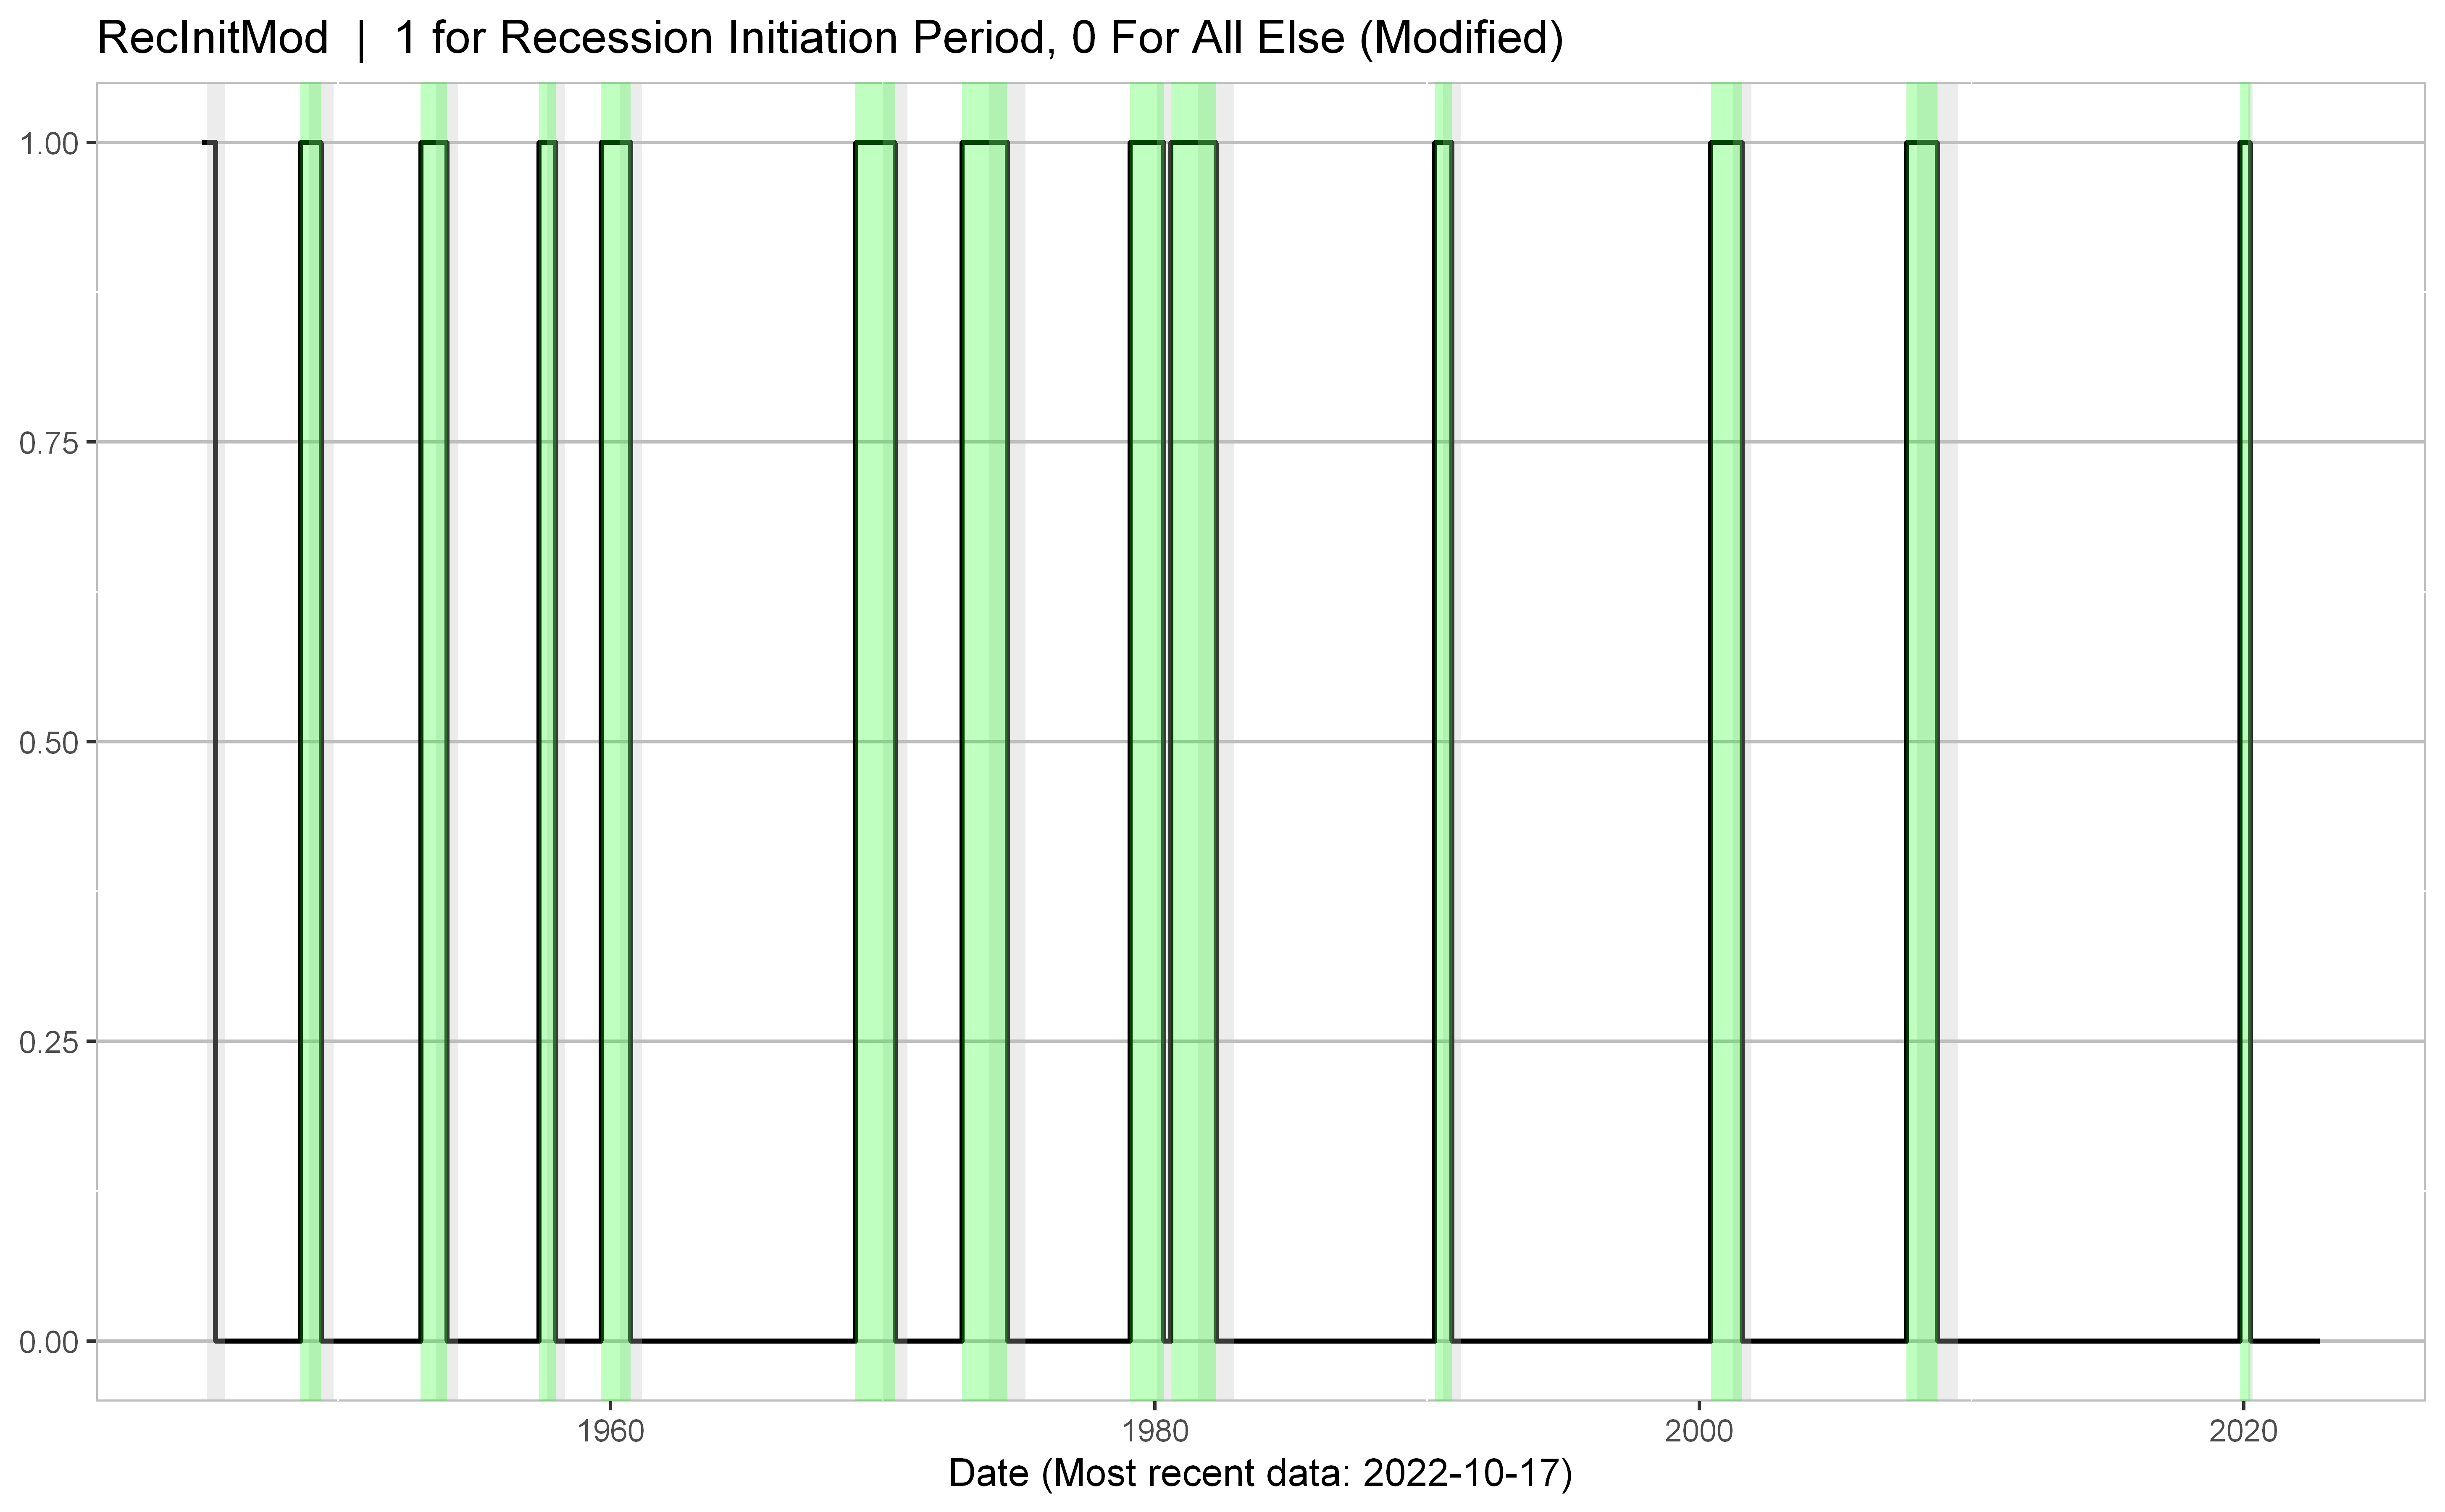

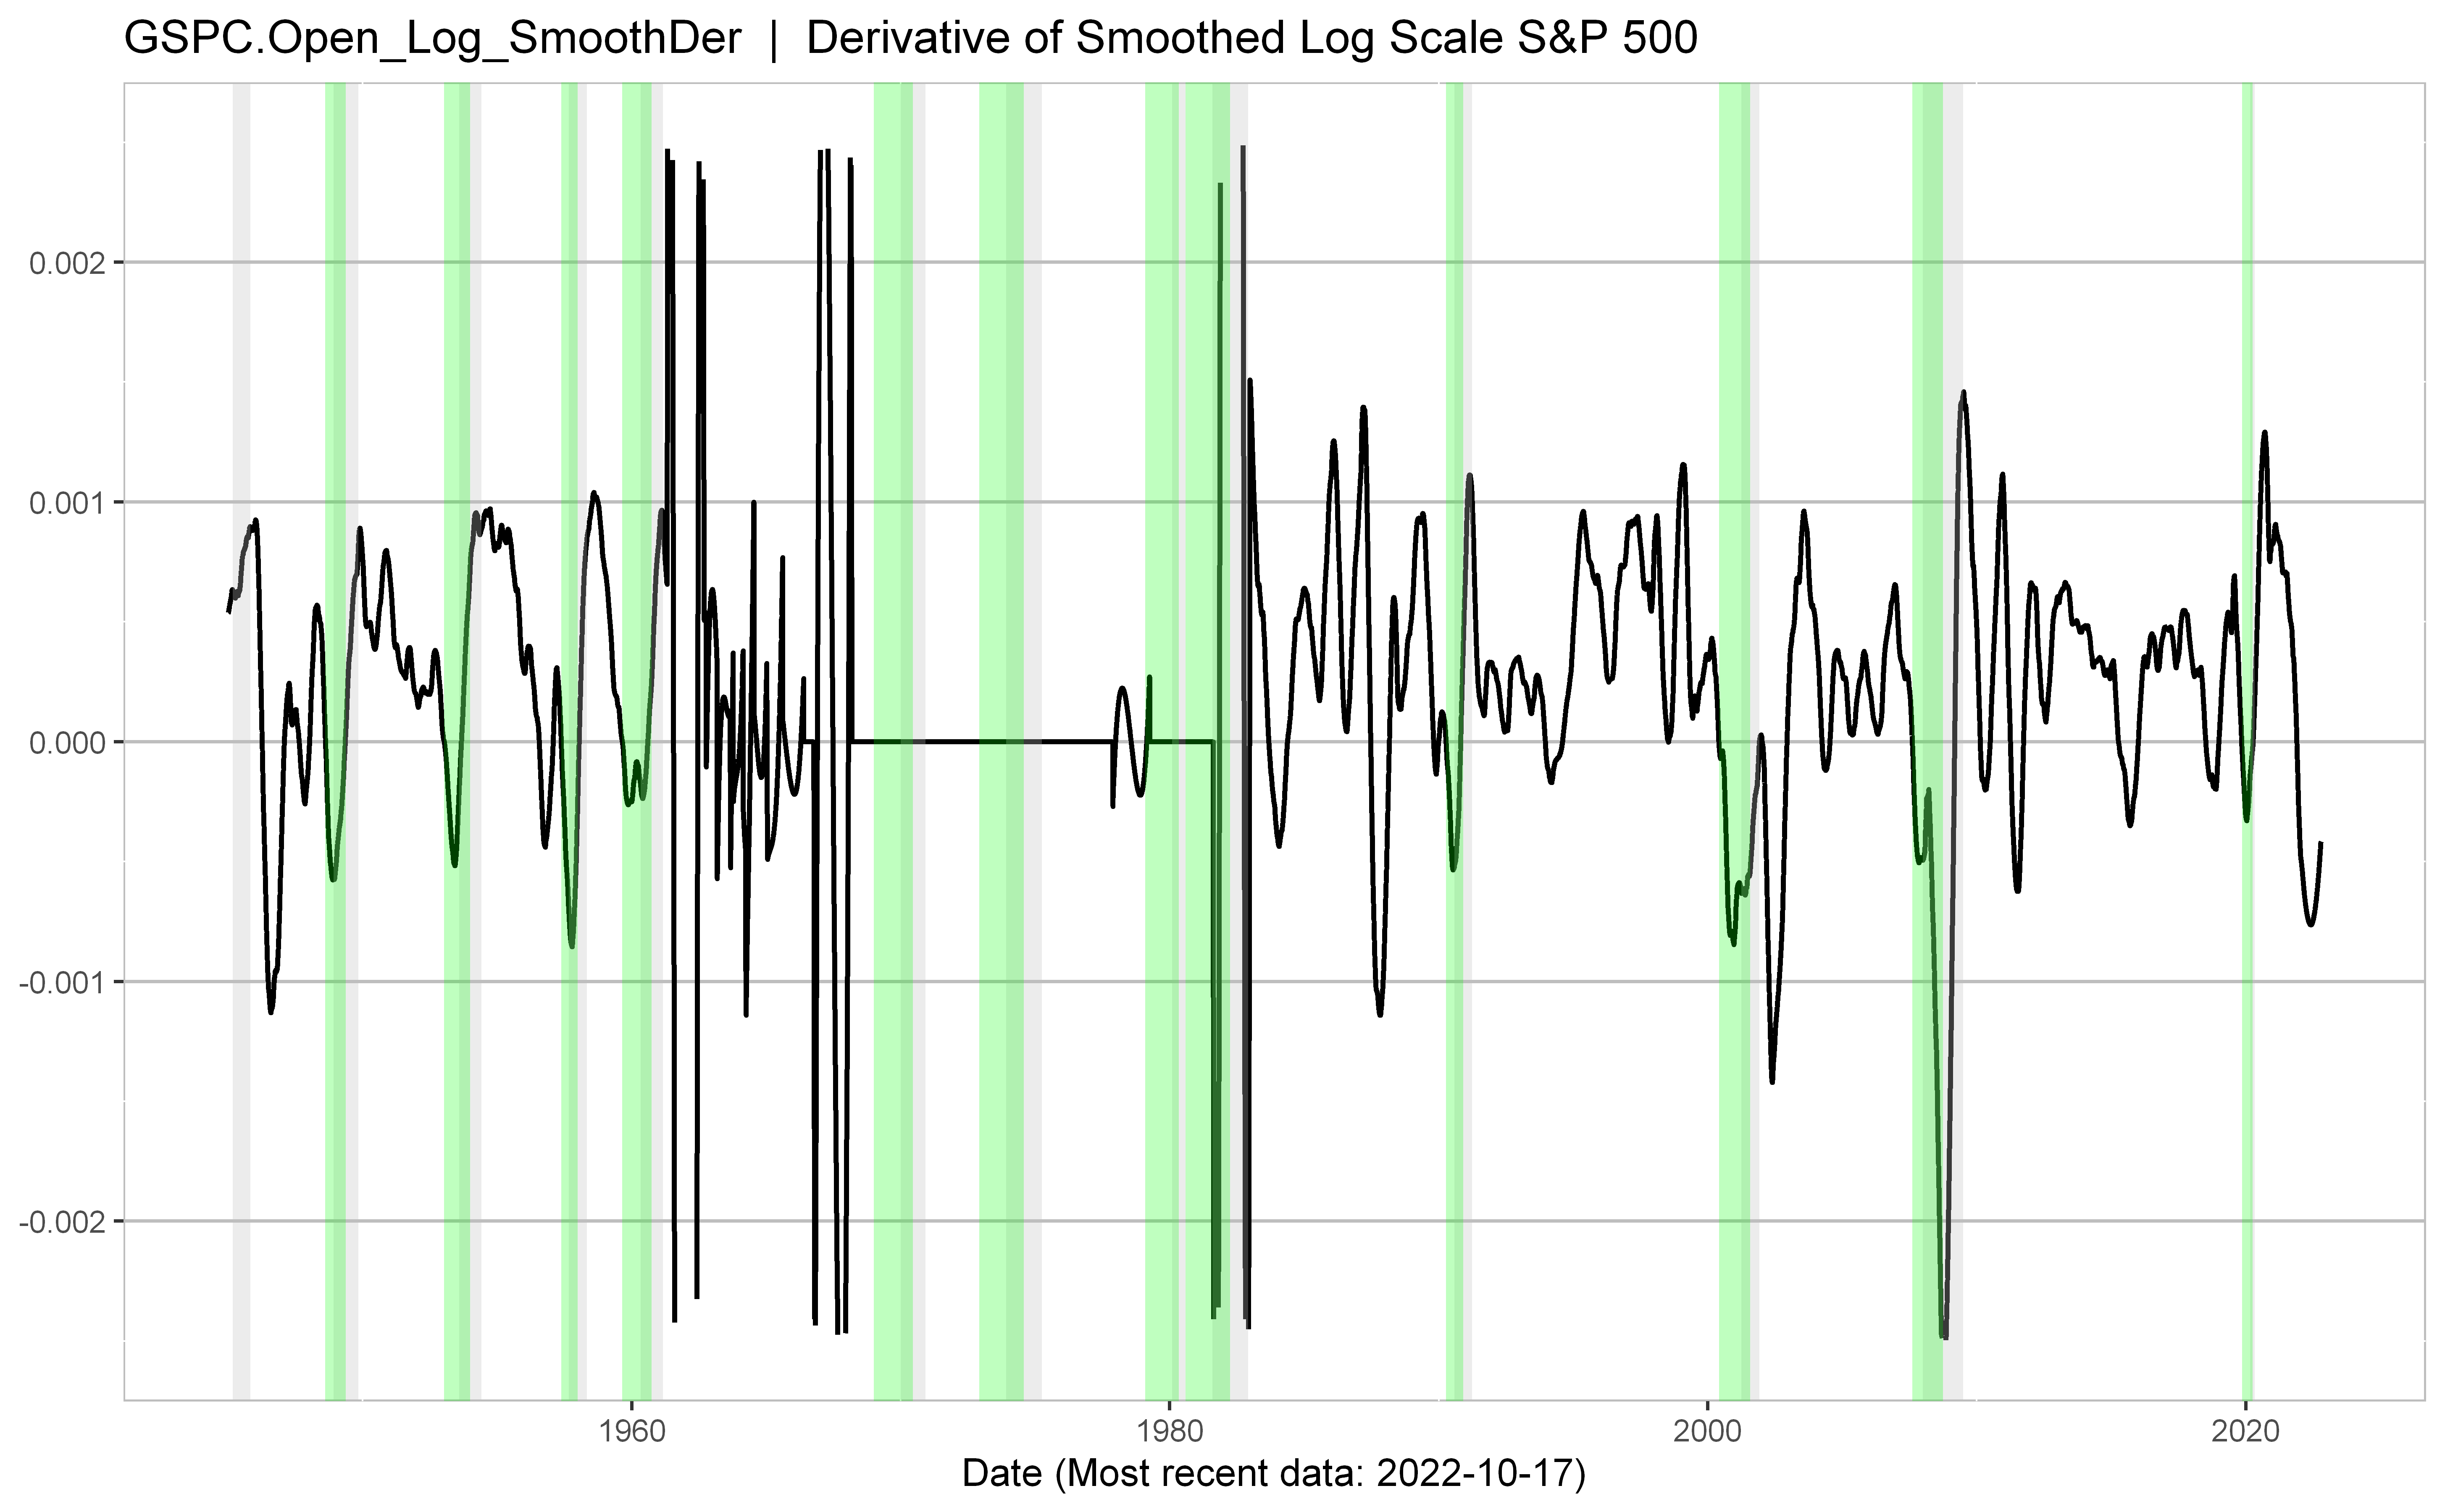

In [23]:
dPeakGSPC <- diff(sign(df.data$GSPC.Open_SmoothDer))
dPeakGSPC <- append(dPeakGSPC, tail(dPeakGSPC,1))
df.data$dPeakGSPC <- dPeakGSPC

# keep only the negative slopes and get rid of any dates
# while the fixed recession indicator is zero
df.data$dPeakGSPC[df.data$dPeakGSPC>0] <- 0
df.data$dPeakGSPC <- (df.data$dPeakGSPC * df.data$RecInit)
dtPeakRec <- df.data$date[which(df.data$dPeakGSPC<0)]

dfRecession$initStartMod <- dfRecession$initStart
for (idxRec in 1: nrow(dfRecession)){
  for( idx in 1:length(dtPeakRec)){
    
    if( dtPeakRec[idx]>dfRecession$initStart[idxRec] & dtPeakRec[idx]<dfRecession$initEnd[idxRec] ){
      
      dfRecession$initStartMod[idxRec] <- dtPeakRec[idx]

    }
    
  }
}

dfRecession$initEndMod <- dfRecession$start + floor((dfRecession$end-dfRecession$start)/2)

# Add the recession initiation date as a time series
df.data$RecInitMod <- rep(0, nrow(df.data))

for (idx in 1:nrow(dfRecession)) {
  df.data$RecInitMod[which(df.data$date > dfRecession$initStartMod[idx] &
                            df.data$date < dfRecession$initEndMod[idx])] = 1
}
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = "RecInitMod",
      string.source = "Calc",
      string.description =  "1 for Recession Initiation Period, 0 For All Else (Modified)",
      string.label.y = "(-)",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = as.Date(df.data$date[1]),
      date.series.end = as.Date(tail(df.data$date, 1))
    )
  )


datay <- "RecInitMod"
ylim <- c(0.00, 1.00)
myPlot <- plotSingle(dfRecession, df.data, "date", 
                     datay, paste(datay, " | ", df.symbols[grep(paste("^",datay,"$", sep=""), df.symbols$string.symbol),]$string.description), 
                     "Date", df.symbols[grep(paste("^",datay,"$", sep=""), df.symbols$string.symbol),]$yLabel, 
                     c(as.Date("1jan1945","%d%b%Y"), Sys.Date()), ylim, FALSE)
myPlot + geom_rect(data=dfRecession,  aes(xmin=initStartMod, xmax=initEndMod, ymin=-Inf, ymax=Inf),
              fill="green", alpha=0.25, na.rm = TRUE)

datay <- "GSPC.Open_Log_SmoothDer"
ylim <- c(-0.0025, 0.0025)
myPlot <- plotSingle(dfRecession, df.data, "date", 
                     datay, paste(datay, " | ", df.symbols[grep(paste("^",datay,"$", sep=""), df.symbols$string.symbol),]$string.description), 
                     "Date", df.symbols[grep(paste("^",datay,"$", sep=""), df.symbols$string.symbol),]$yLabel, 
                     c(as.Date("1jan1945","%d%b%Y"), Sys.Date()), ylim, FALSE)
myPlot + geom_rect(data=dfRecession,  aes(xmin=initStartMod, xmax=initEndMod, ymin=-Inf, ymax=Inf),
              fill="green", alpha=0.25, na.rm = TRUE)

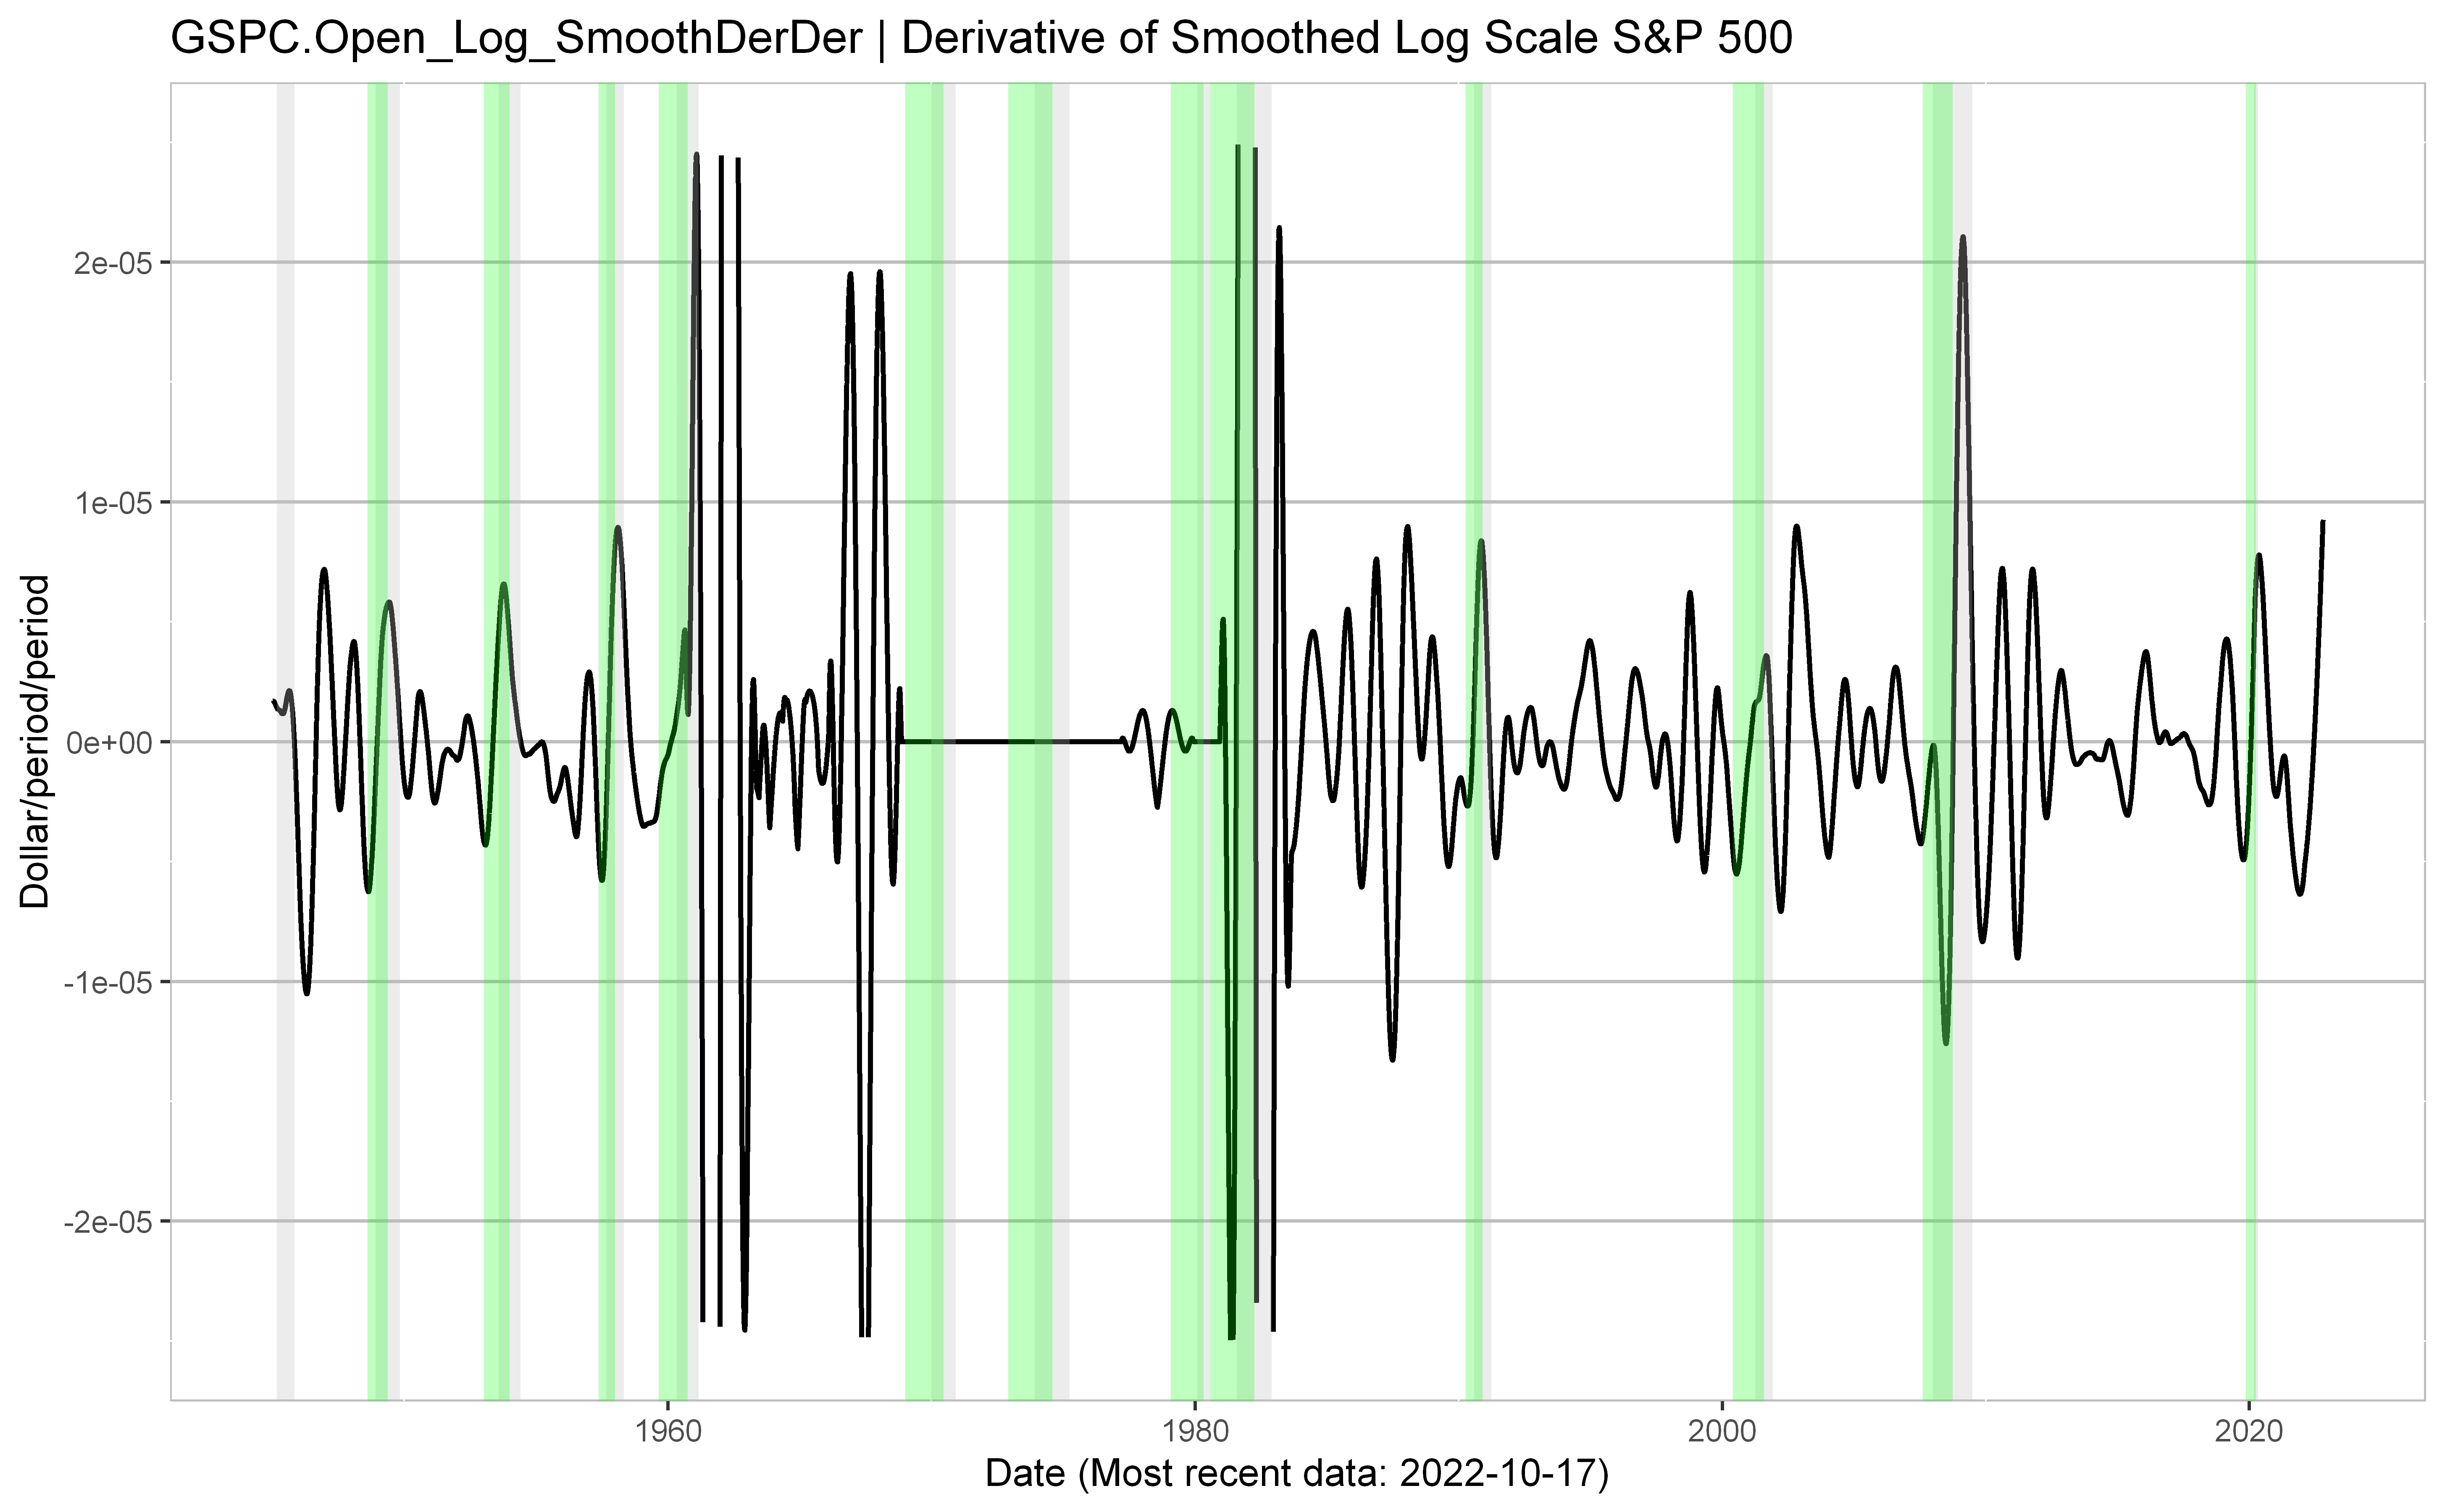

In [24]:
datay <- "GSPC.Open_Log_SmoothDerDer"
ylim <- c(-0.000025, 0.000025)
myPlot <- plotSingleQuick(dfRecession, df.data, datay, ylim)
myPlot + geom_rect(data=dfRecession,  aes(xmin=initStartMod, xmax=initEndMod, ymin=-Inf, ymax=Inf),
              fill="green", alpha=0.25, na.rm = TRUE)

Take a look at year-over-year as related to the recessions

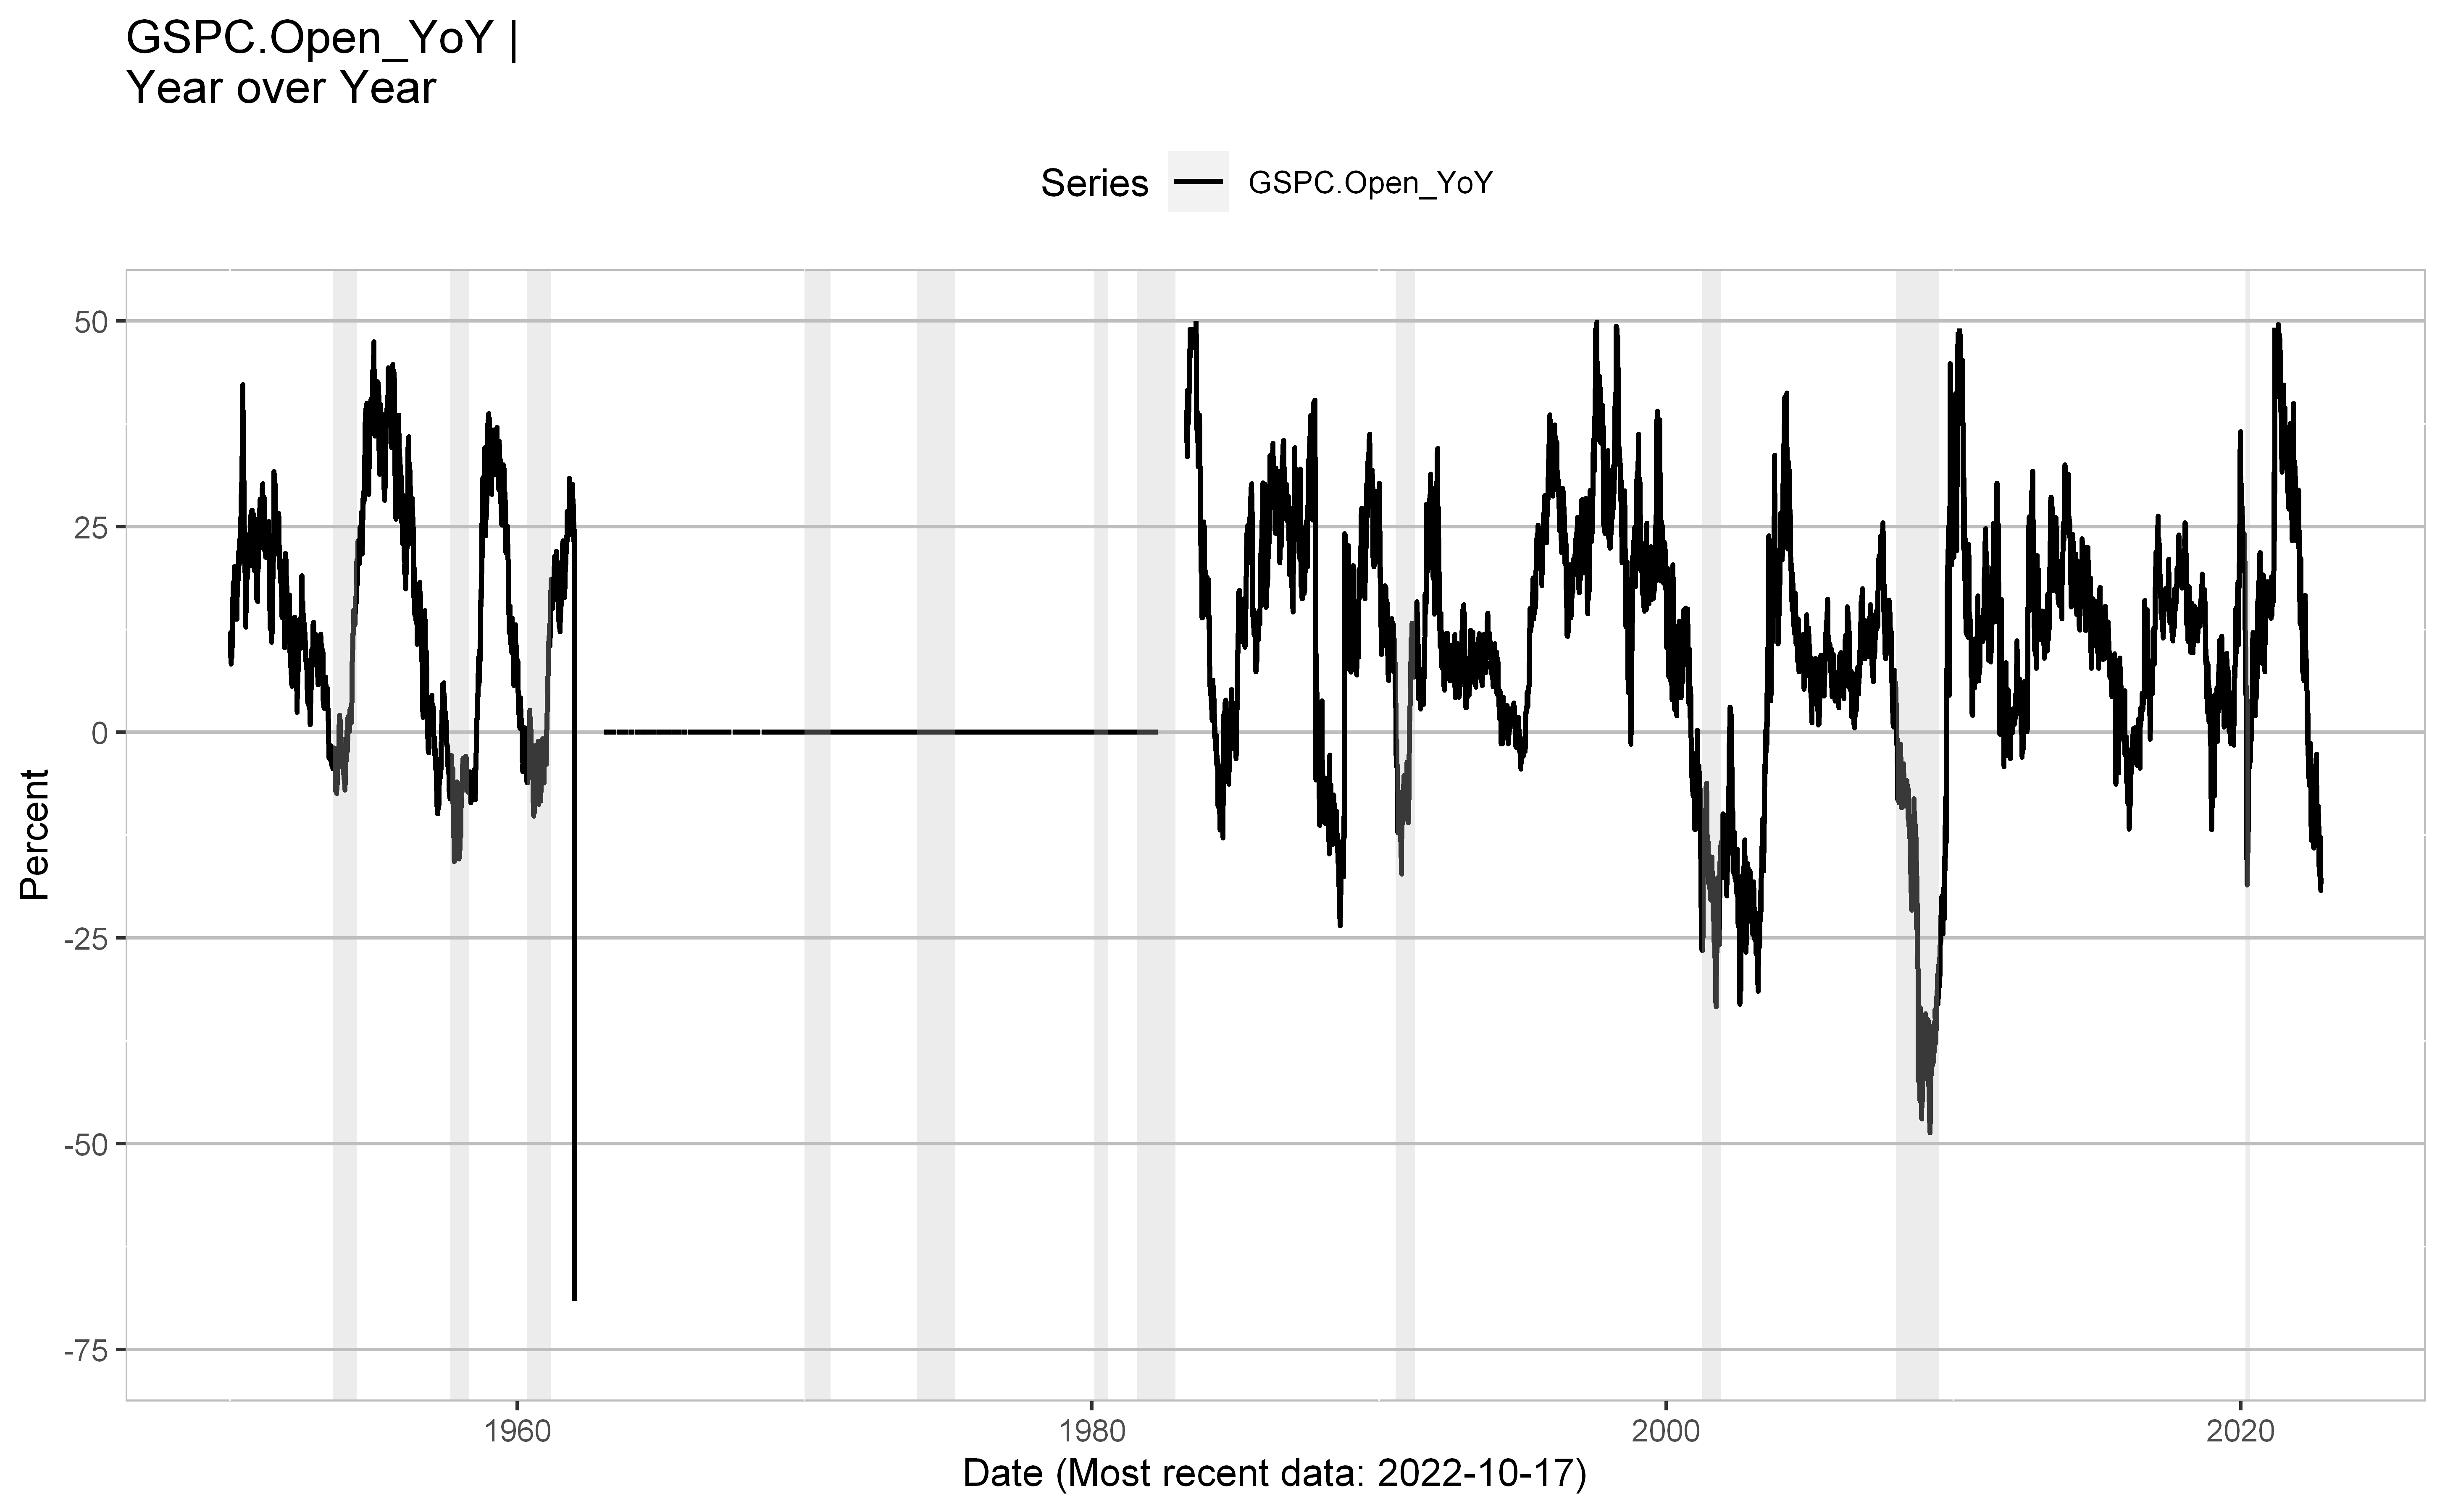

In [25]:
datay <- "GSPC.Open_YoY"
ylim <- c(-75, 50)
dt.start <- as.Date("1jan1950", "%d%b%Y")
b.percentile <- TRUE
plotSingleQuick(dfRecession, df.data, datay, ylim, dt.start, b.percentile)

# Prior art

There are some models out there with claims to predict recessions. This section summarizes some of those.

## NY Federal Reserve

I really like this for the simplicity; howevver it is recently not the best predictor. Refer to the website https://www.newyorkfed.org/research/capital_markets/ycfaq.html for details. I had to read through the reference papers to understand how the alpha and beta factors were used. 

The fed shifts their data so the predictor aligns with the recessions; however I wanted the predictor to appear before the recessions so I do not shift it.

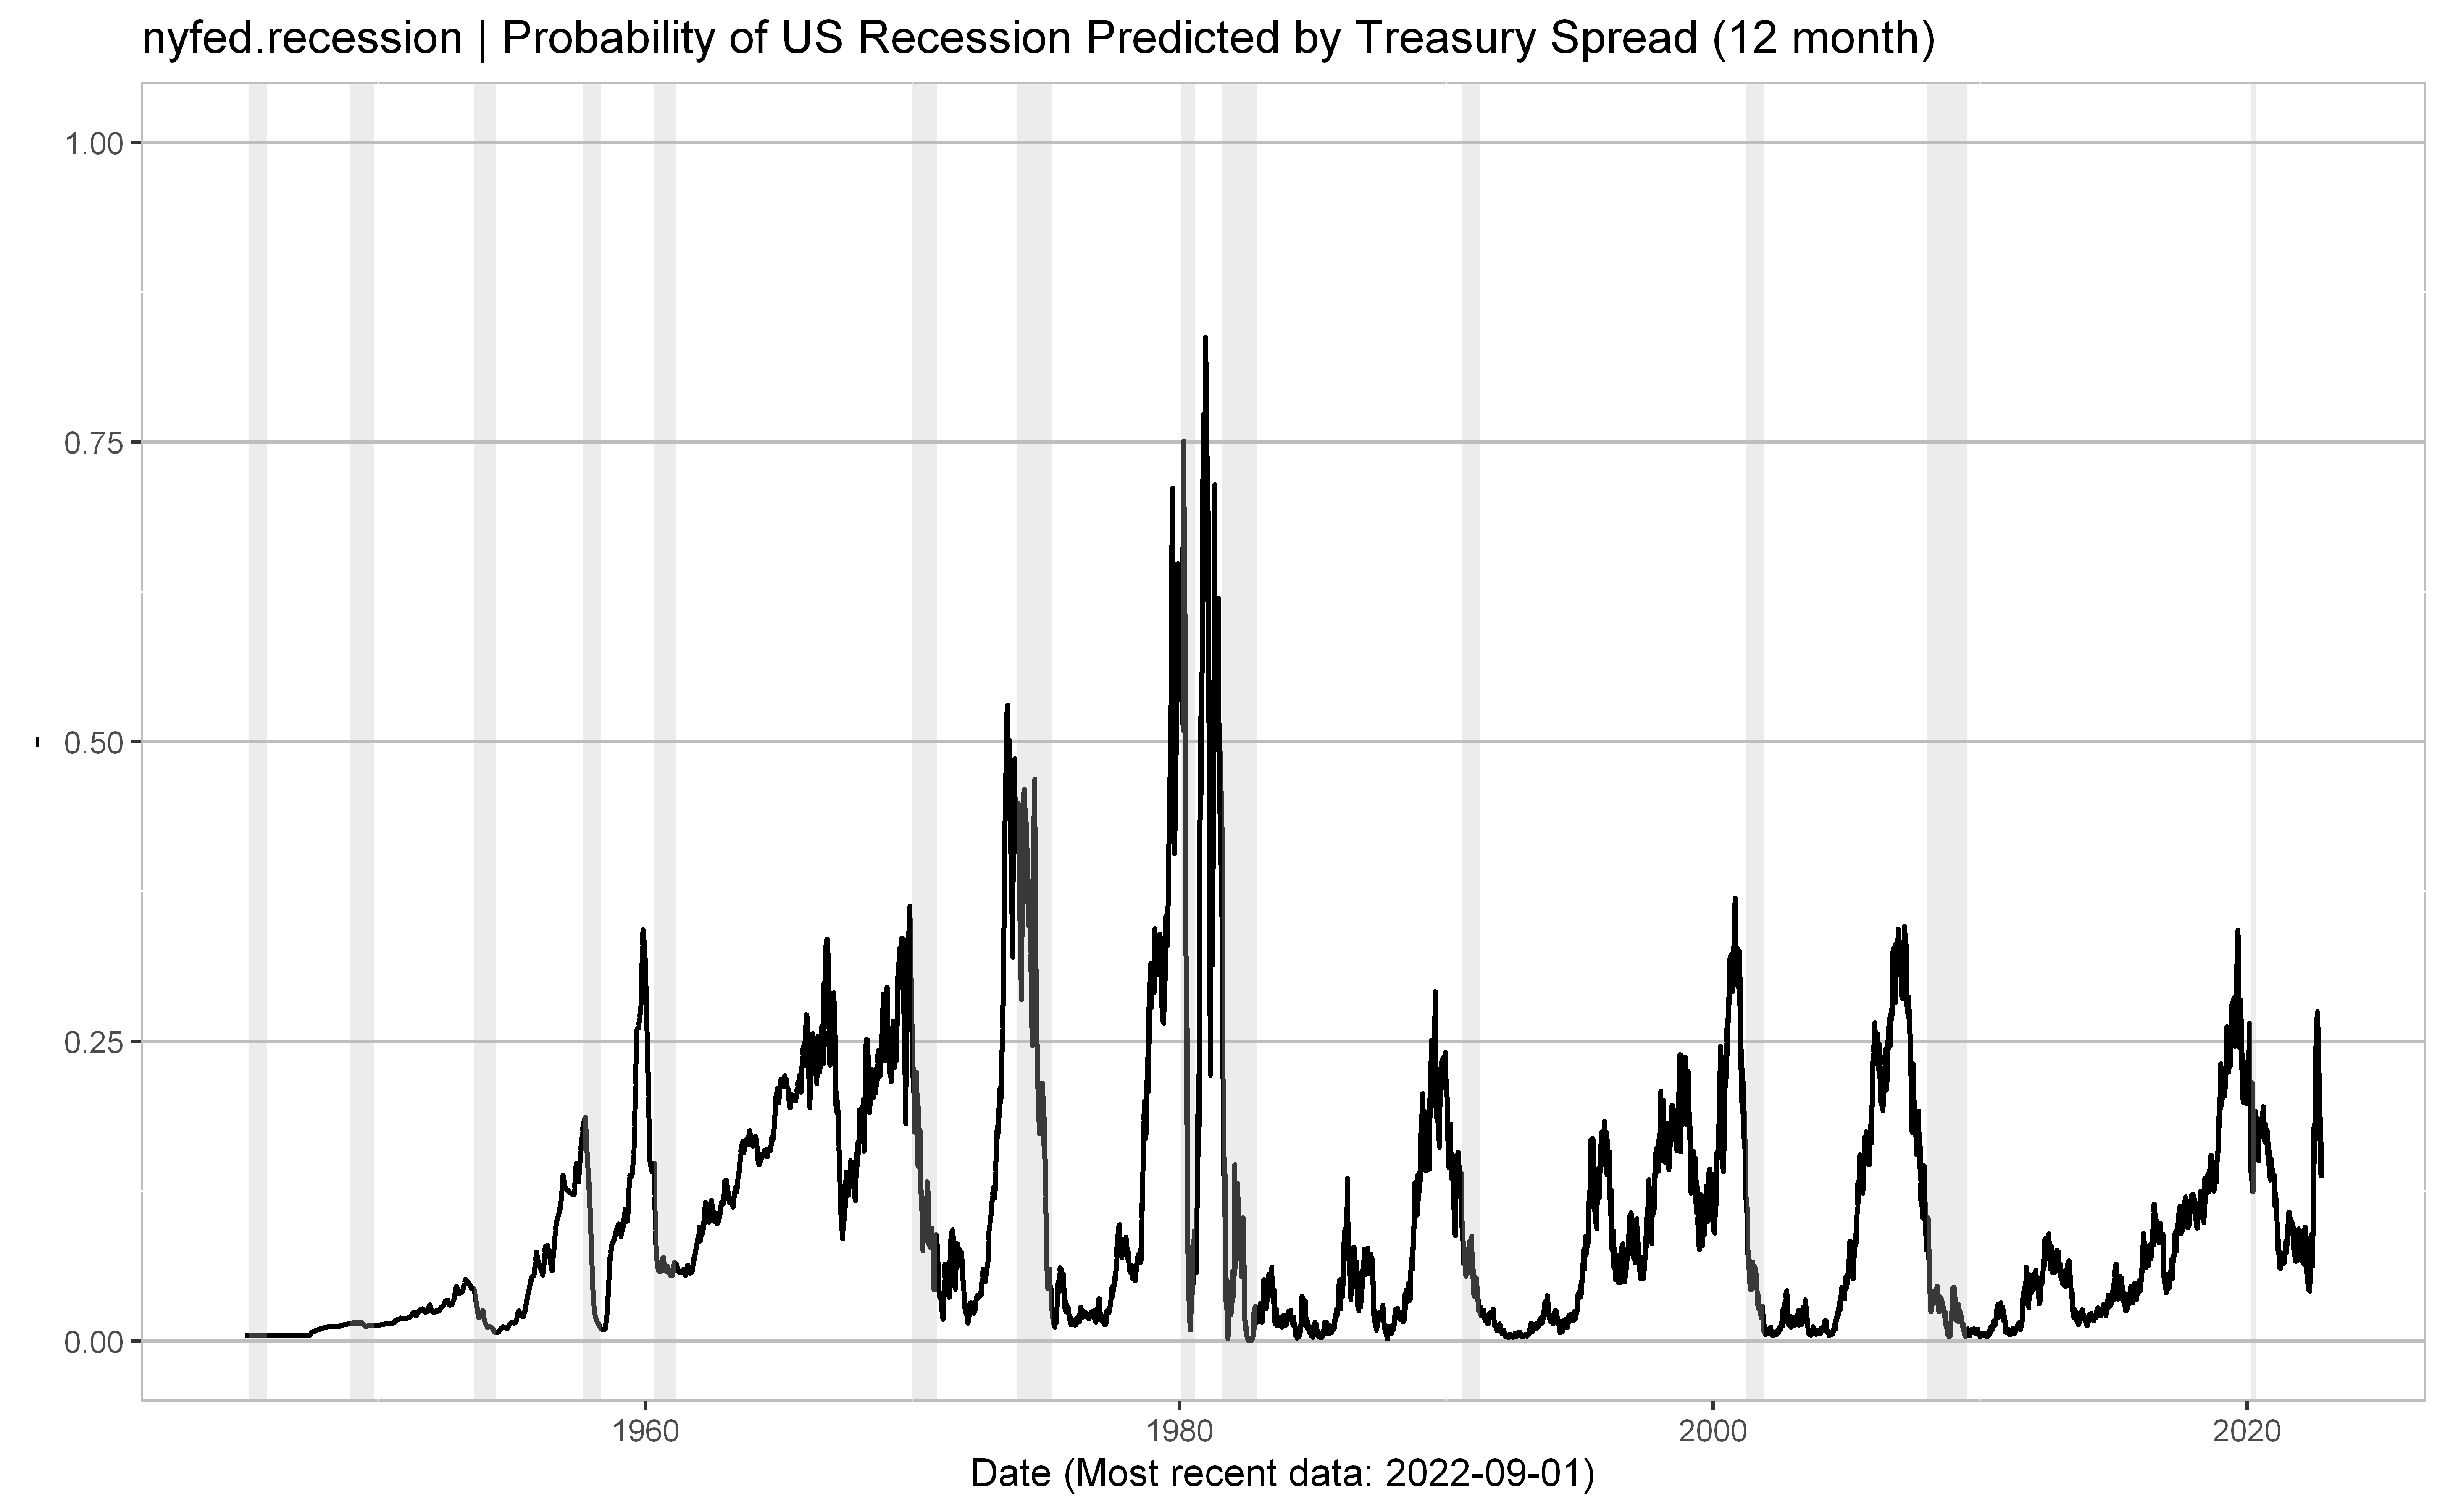

In [26]:
datay <- "nyfed.recession"
ylim <- c(0, 1)
myPlot <- plotSingleQuick(dfRecession, df.data, datay, ylim)
myPlot

# Machine Learning

## Select data and date range for testing

The data series have different start dates and they are not updated at the same time. This bit of code selects a valid data range to develop the model.

In [27]:
model.features <- list(
  c("DGS10TOTB3MS"),
  c("DGS10TOTB3MS", "UNRATE"),
  c("DGS10TOTB3MS", "W875RX1_YoY"),
  c("DGS10TOTB3MS", "ICSA_YoY"),
  c("DGS10TOTB3MS", "GDPBYCPIAUCSLBYPOPTHM_SmoothDer"),
  c("DGS10TOTB3MS", "HSN1FNSA_YoY"),
  c("DGS10TOTB3MS", "UNRATE", "W875RX1_YoY"),
  c("DGS10TOTB3MS", "UNRATE", "ICSA_YoY"),
  c("DGS10TOTB3MS", "W875RX1_YoY", "ICSA_YoY"),
  c(
    "DGS10TOTB3MS",
    "W875RX1_YoY",
    "ICSA_YoY",
    "GDPBYCPIAUCSLBYPOPTHM_SmoothDer"
  ),
  c("DGS10TOTB3MS",
    "UNRATE",
    "W875RX1_YoY",
    "ICSA_YoY"),
  c("DGS10TOTB3MS",
    "UNRATE",
    "W875RX1_YoY",
    "ICSA_YoY",
    "HSN1FNSA_YoY"),
  c("DGS10TODTB3", "UNRATE", "W875RX1_YoY", "ICSA_YoY"),
  c(
    "DGS10TOTB3MS",
    "UNRATE",
    "W875RX1_YoY",
    "ICSA_YoY" ,
    "GDPBYCPIAUCSLBYPOPTHM_SmoothDer"
  ),
  c(
    "DGS10TOTB3MS",
    "UNRATE",
    "W875RX1_YoY",
    "ICSA_YoY" ,
    "GDPBYCPIAUCSLBYPOPTHM_SmoothDer",
    "HSN1FNSA_YoY"
  ))
i.model.count <- length(model.features)

# Pick the most recent data sample. TODO: this is done manually, but needs to be automated
#dt.start.prediction <- index(get(model.features[1])[1])
dt.start.prediction <- as.Date("01/02/1962", "%d/%m/%Y")

# If the series was downloaded as a zoo object, check that the start date is valid
for (strSeries in model.features[-1]){
  result = tryCatch({
    dtThis <- index(get(strSeries)[1])
    if( dtThis > dt.start.prediction){
      dtStart <- dtThis
    }
  }, error = function(e){
    # do nothing for now...TO DO: adjust dates.
  })
}

dt.end.prediction <- as.Date("2018-06-30")
df.dataModel <-
  df.data[df.data$date >= dt.start.prediction &
            df.data$date <= dt.end.prediction, ]
str.training.date.range <-
  paste("Training Date Range: ",
        dt.start.prediction,
        " to ",
        dt.end.prediction,
        sep = "")
print(str.training.date.range)

[1] "Training Date Range: 1962-02-01 to 2018-06-30"


## Partition the data

I break the data into three sets: 50% for training, 25% for testing, and 25% for validation.

In [28]:
set.seed(123456)
inTrain <- createDataPartition(y=df.dataModel$RecInit, p = 0.50, list=FALSE)
dfTrain <- df.dataModel[inTrain,]
df.data.rest <- df.dataModel[-inTrain,]
inVal <- createDataPartition(y = df.data.rest$RecInit, p = 0.50, list = FALSE)
dfVal <- df.data.rest[inVal,]
dfTest <- df.data.rest[-inVal,]
rm(df.data.rest)

## Create the model (Switch, 10 Year to 3 Month)

This section builds the model with just the 10 Year to 3 Month feature.

In [29]:
string.equation.partition <- paste("RecInit ~ ", paste(model.features[[1]], collapse = "+", sep=""))
model.fit <- rpart( string.equation.partition, data=dfTrain)

The plot below summarizes the correlations in a graphical format. The tree itself is a little more complicated than I like.

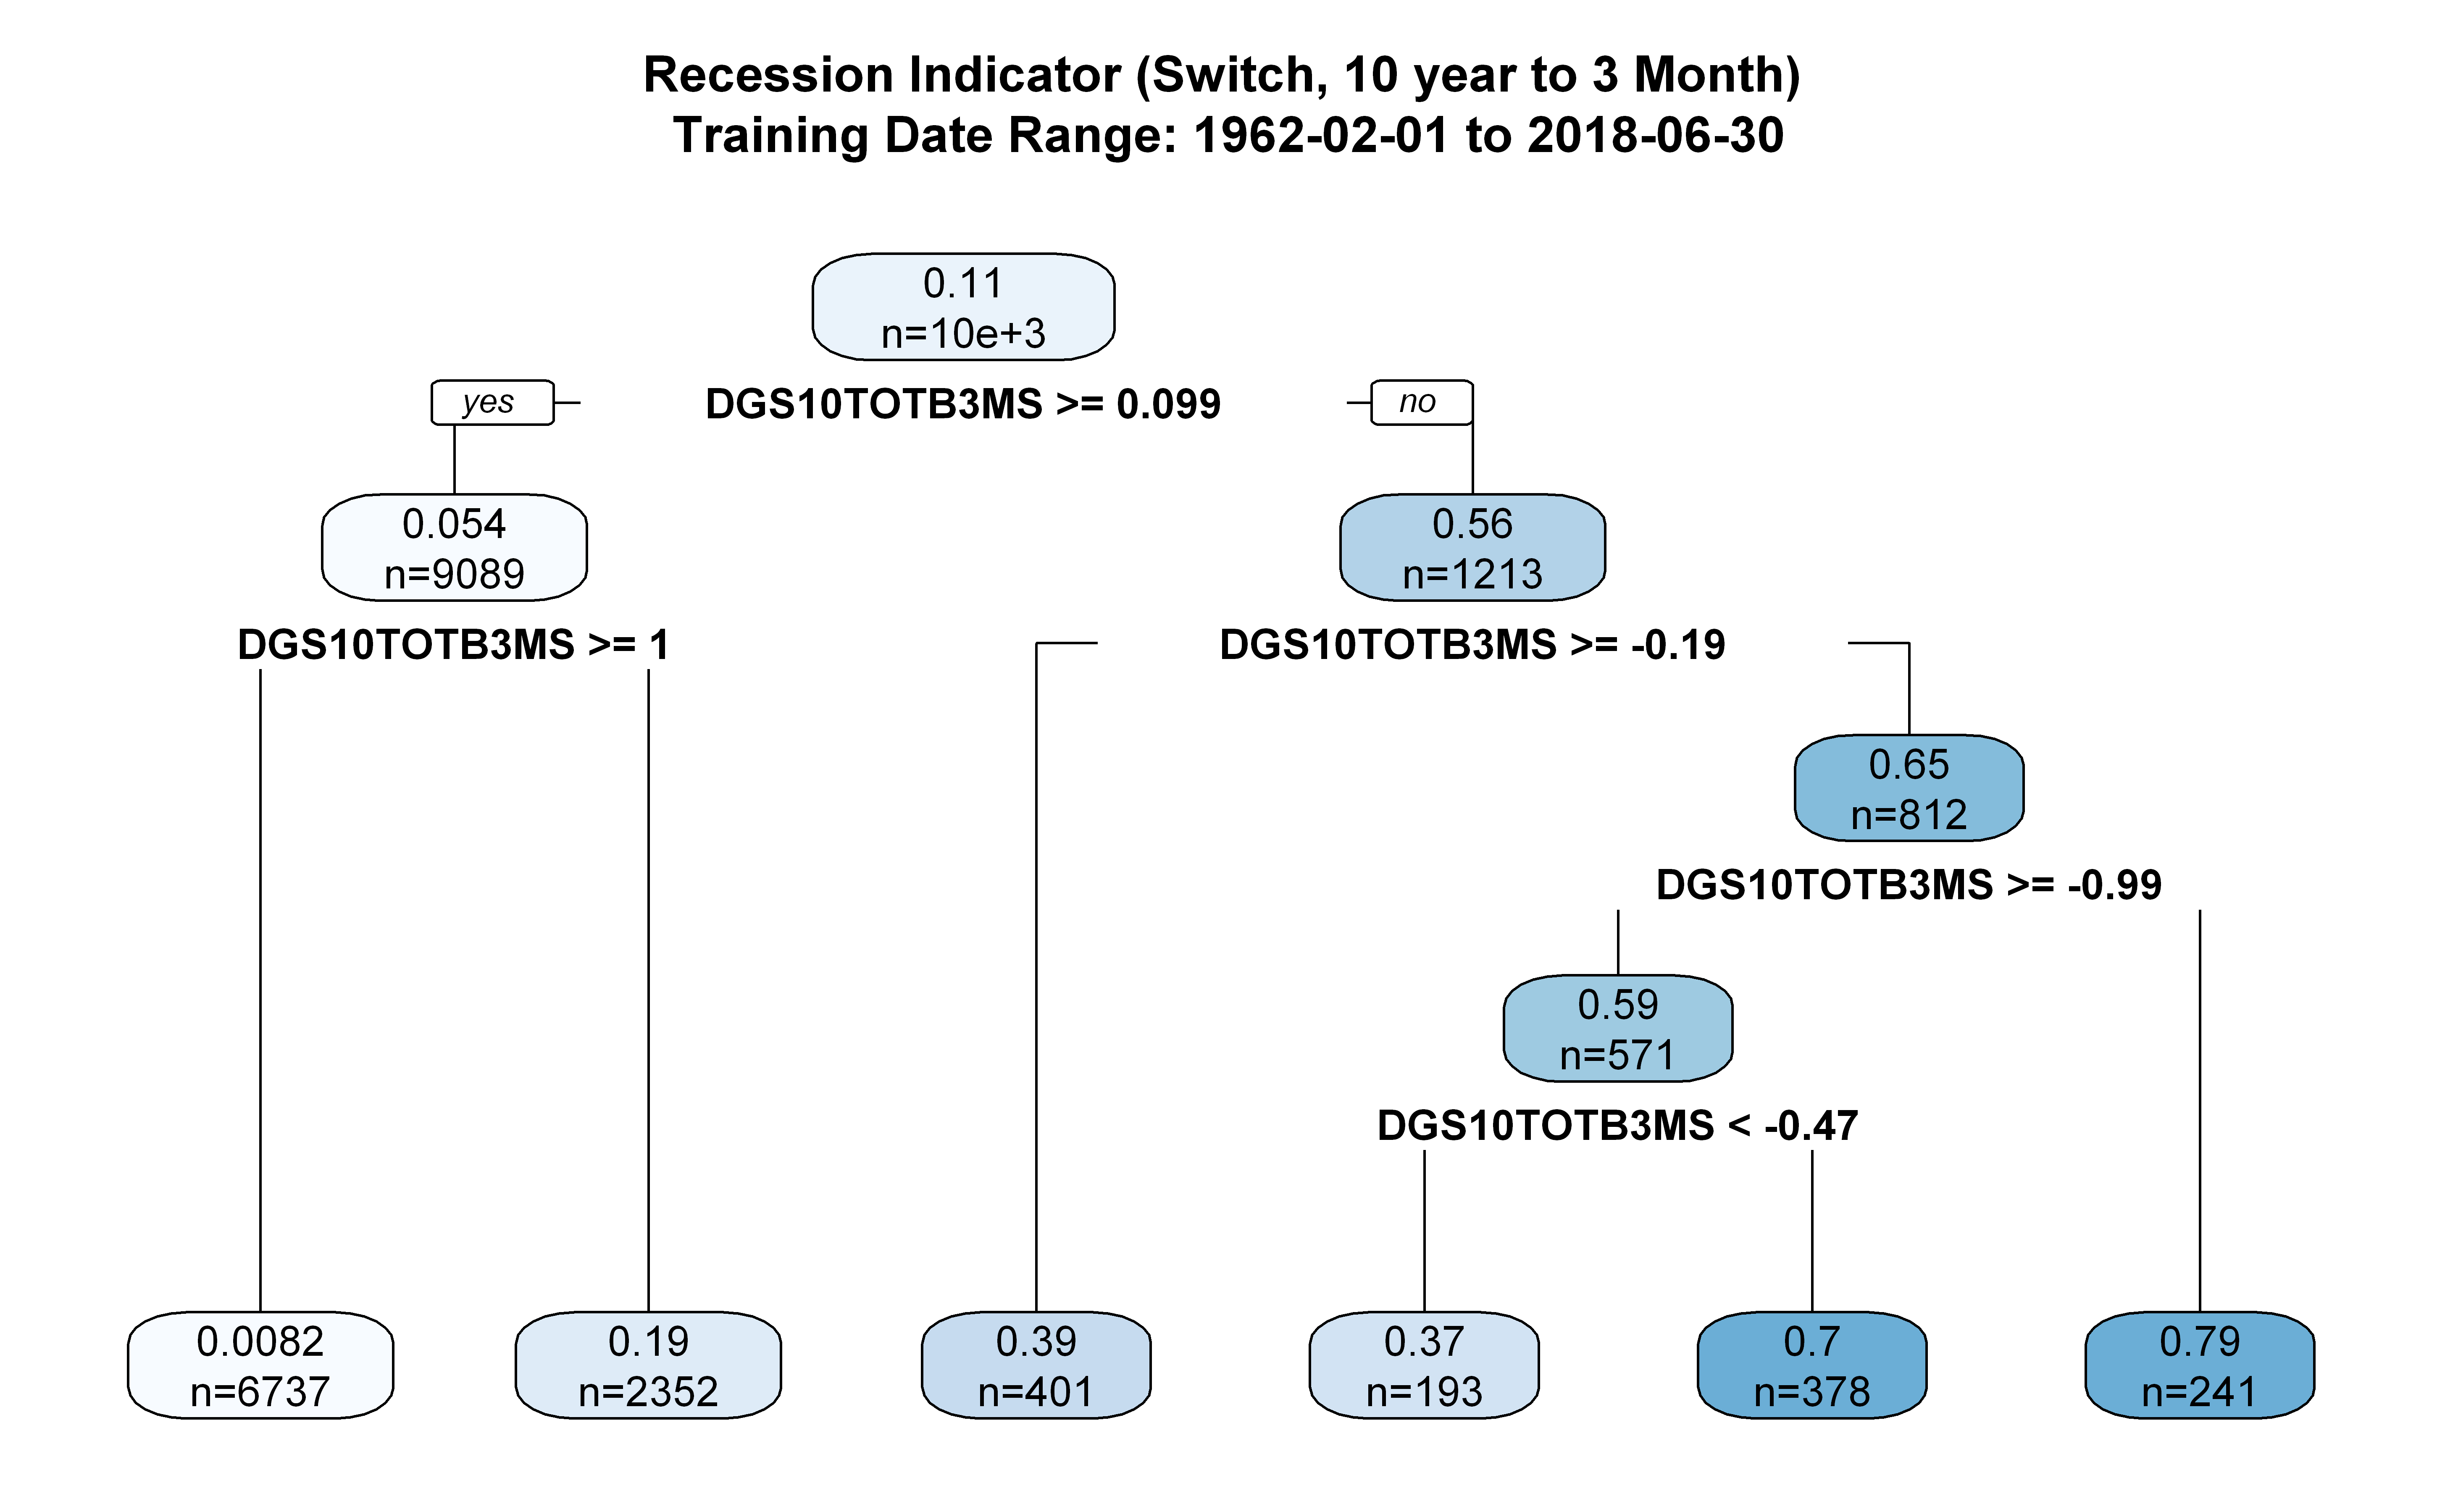

In [30]:
rpart.plot(model.fit, main=paste("Recession Indicator (Switch, 10 year to 3 Month)\n", str.training.date.range), type = 2, extra = 1)

## Validation (Switch, 10 Year to 3 Month)

Plot the data against the NEBR recessions and the recession initiation indicator.

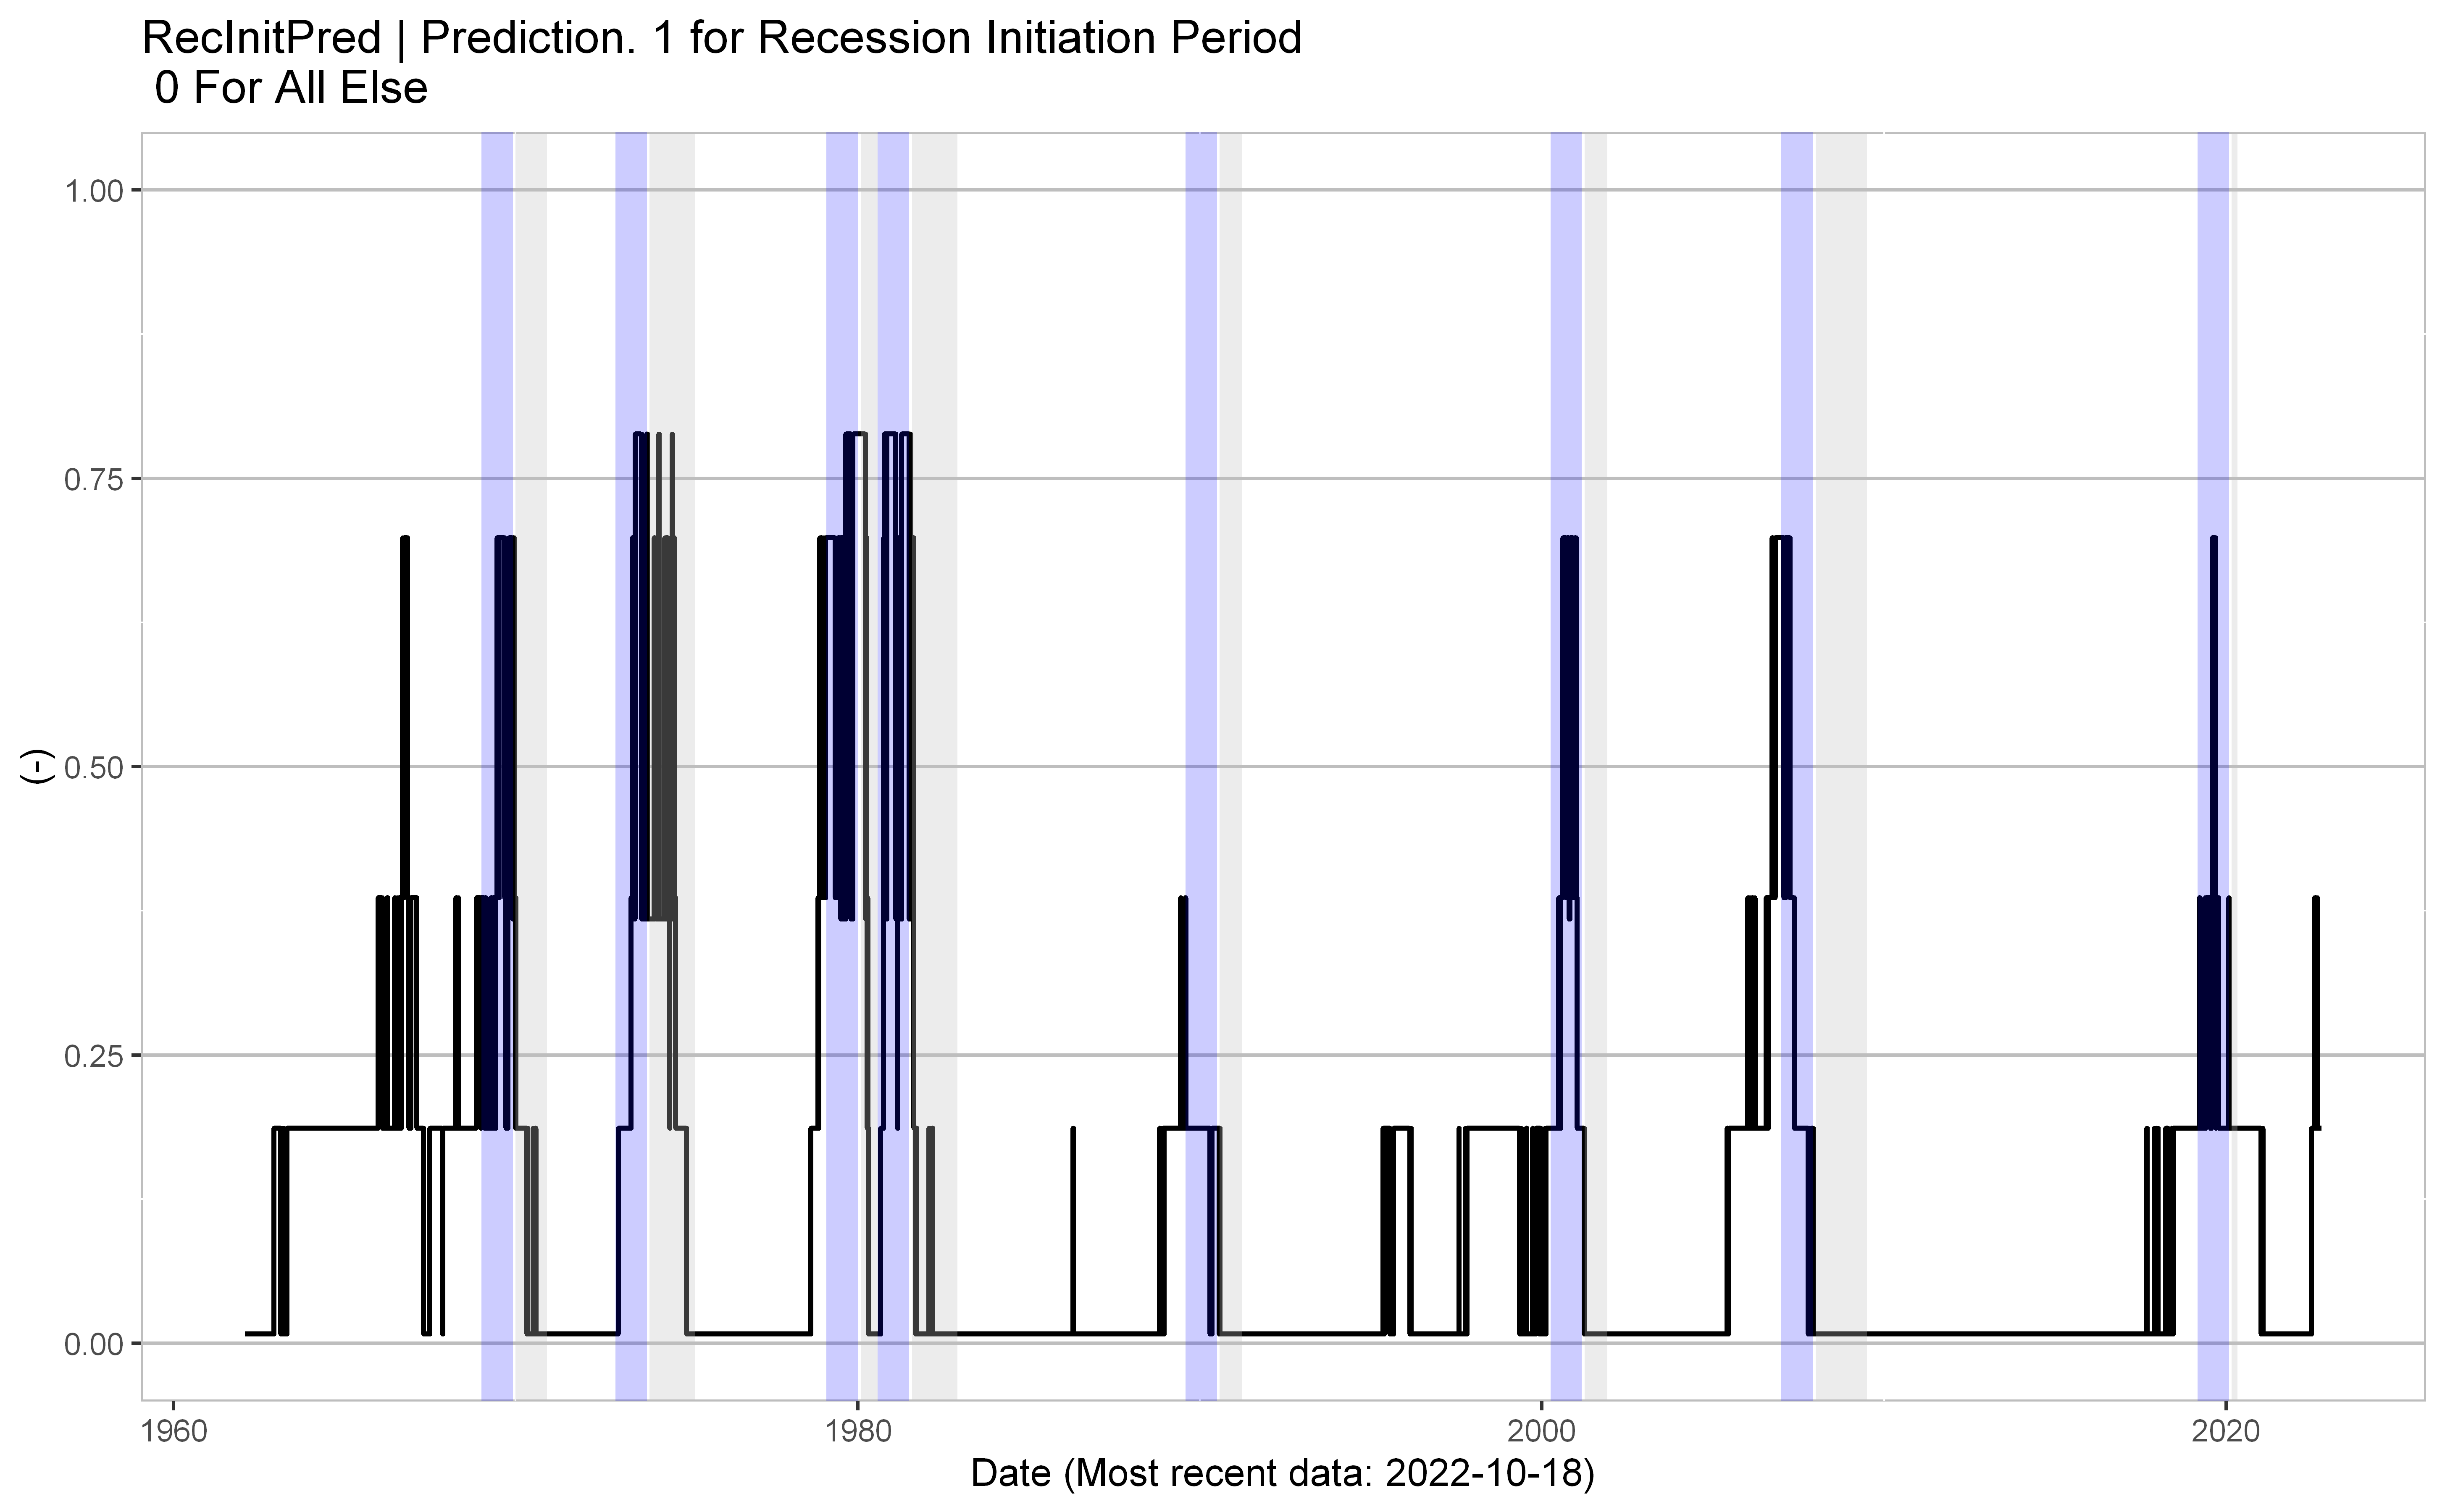

In [31]:
df.data$RecInitPred <- predict(model.fit, newdata = df.data)
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = "RecInitPred",
      string.source = "Calc",
      string.description =  "Prediction. 1 for Recession Initiation Period \n 0 For All Else",
      string.label.y = "(-)",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )


datay <- "RecInitPred"
datay_aux <- "RecInit"
ylim <- c(0, 1)
myPlot <- plotSingleQuick(dfRecession, df.data, datay, ylim, dt.start.prediction)
myPlot + geom_rect(
  data = dfRecession,
  aes(
    xmin = initStart,
    xmax = initEnd,
    ymin = -Inf,
    ymax = Inf
  ),
  fill = "blue",
  alpha = 0.2,
  na.rm = TRUE
)

## Create the model (Switch, all features)

This section builds the model with all features (Unemployment rate, 10 Year to 3 Month, Real personal income excluding current transfer receipts year-over-year, andd Initial jobless claims year over year).

In [32]:
string.equation.partition <- paste("RecInit ~ ", paste(tail(model.features, n=1)[[1]], collapse = "+", sep=""))
model.fit <- rpart( string.equation.partition, data=dfTrain)

The plot below summarizes the correlations in a graphical format. The tree itself is a little more complicated than I like.

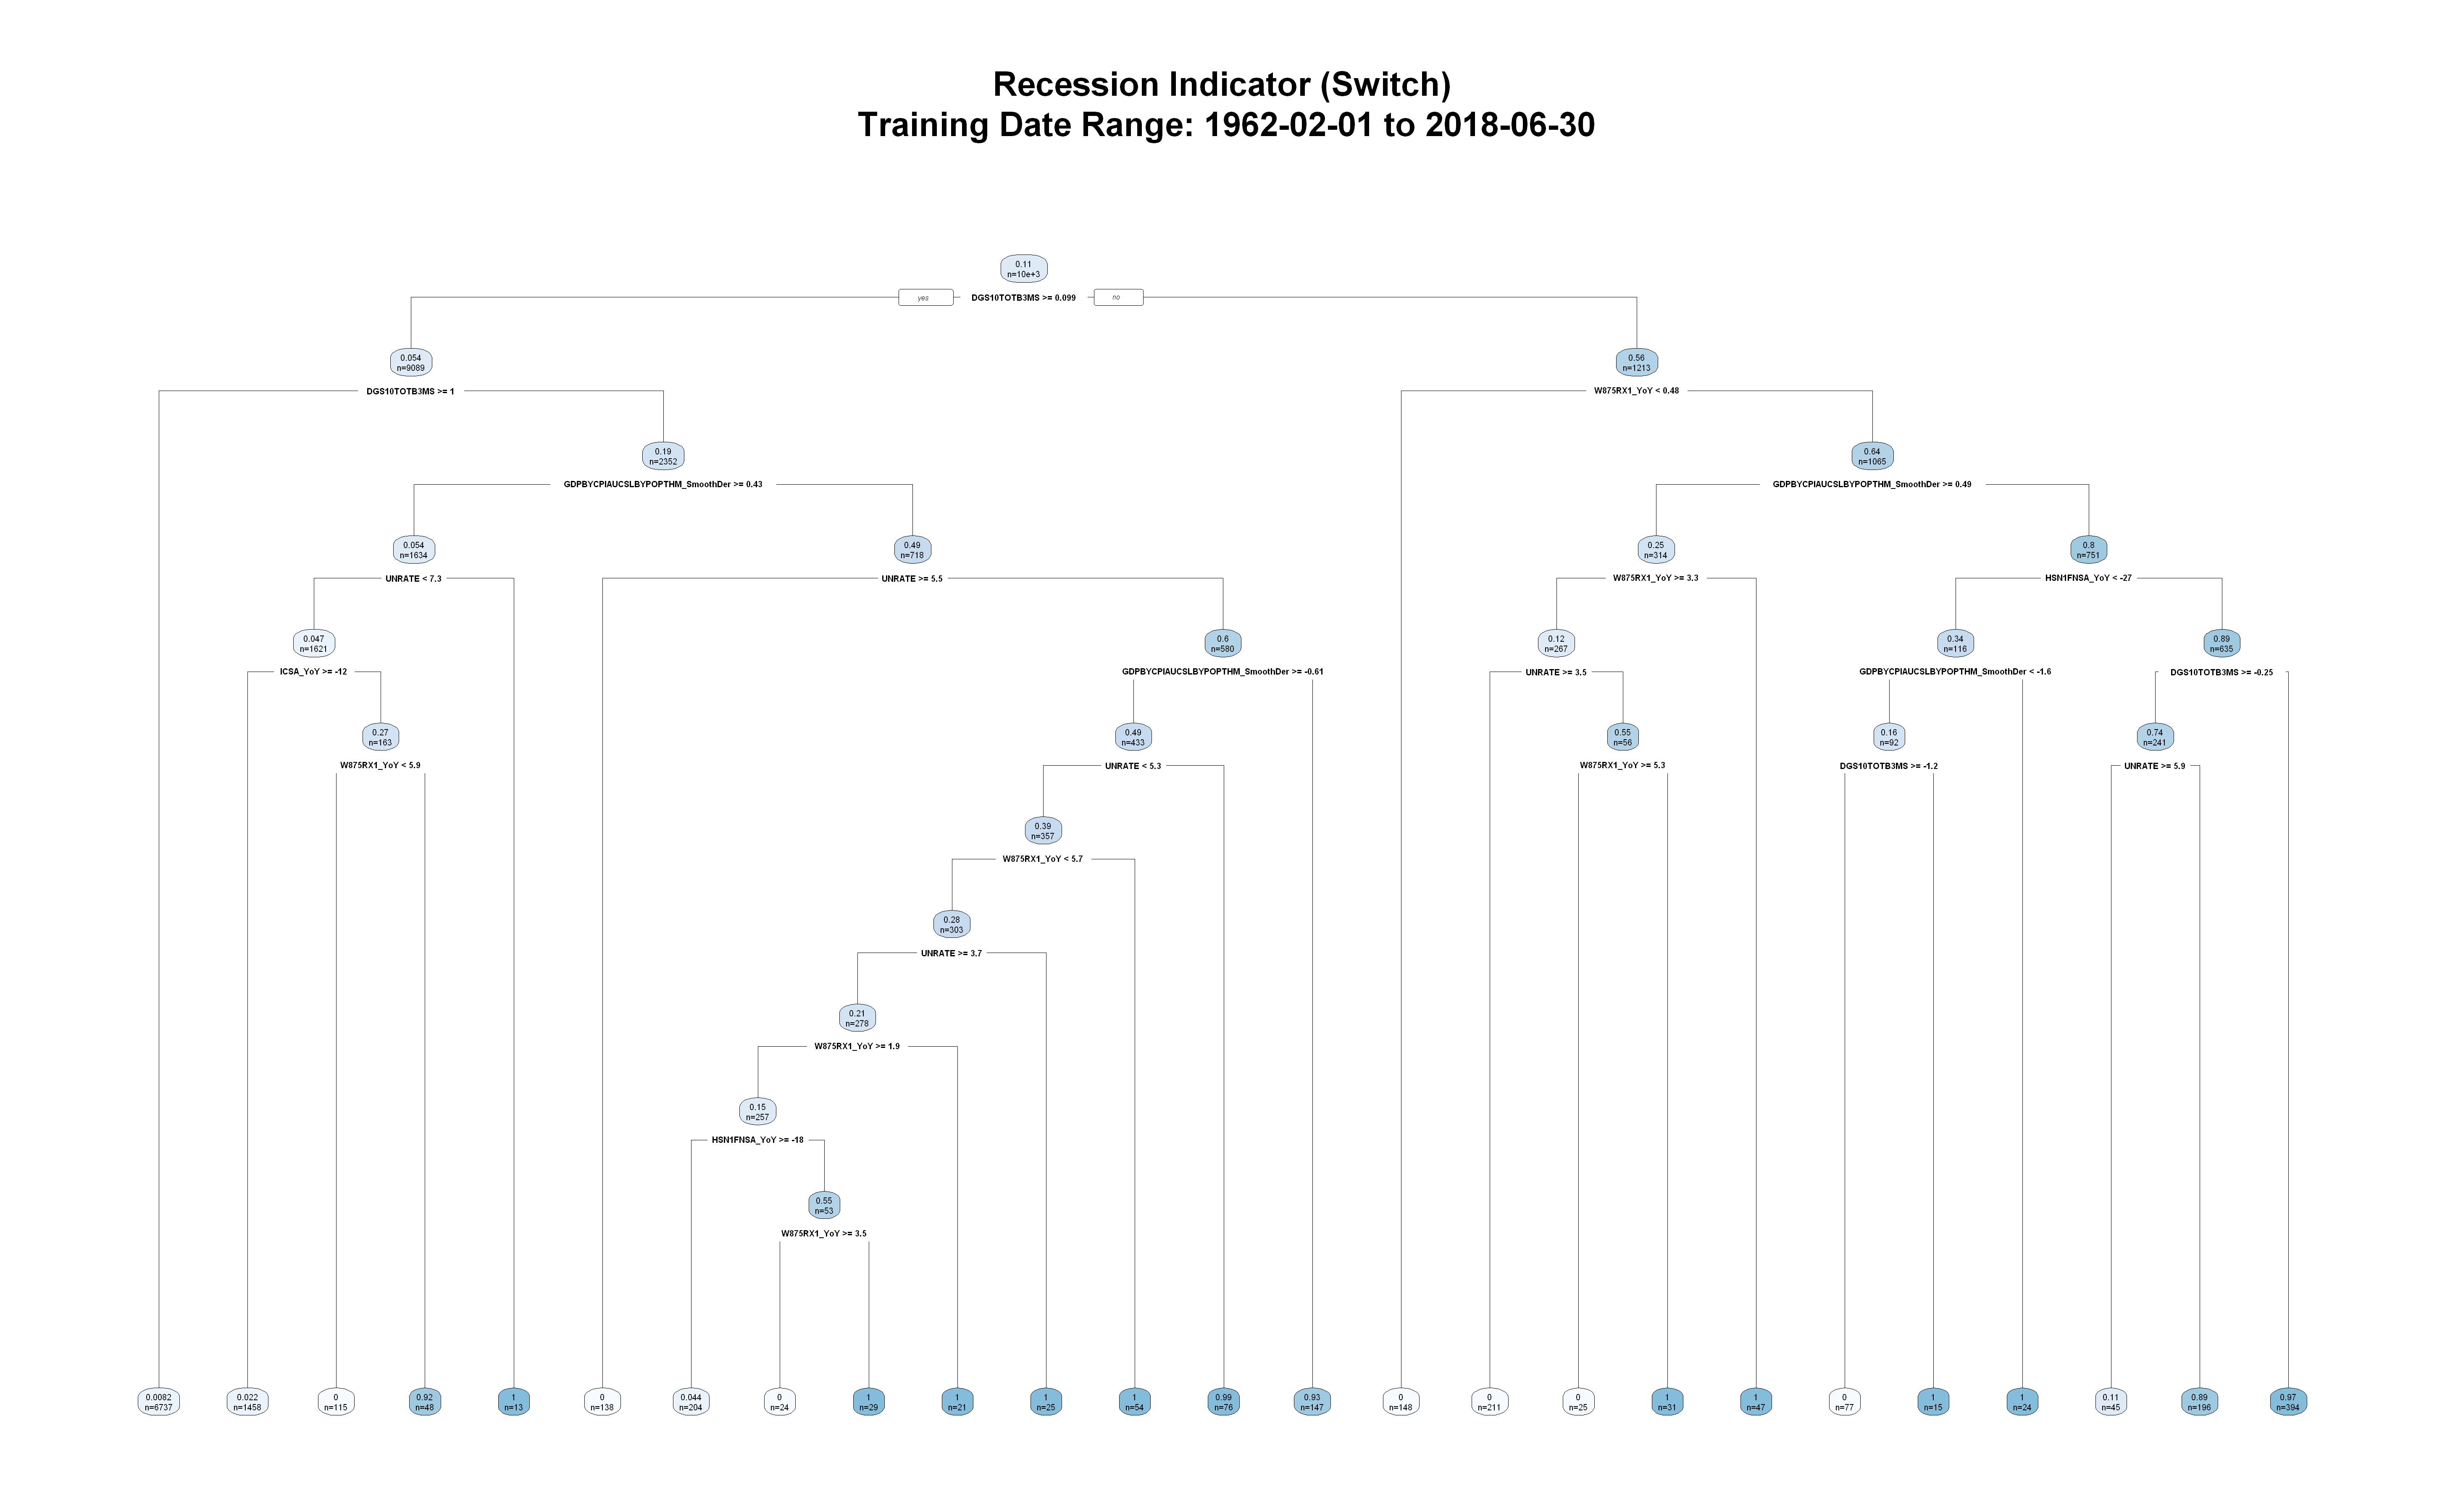

In [33]:
rpart.plot(model.fit, main=paste("Recession Indicator (Switch)\n", str.training.date.range), type = 2, extra = 1)

## Validation (Switch, all features)

Rather than step through a quantitative validation I am going going to plot the data against the NEBR recessions and the recession initiation indicator. There is good agreement between the model and indicator. We can create a buy signal anytime that the indicator is above 0.5

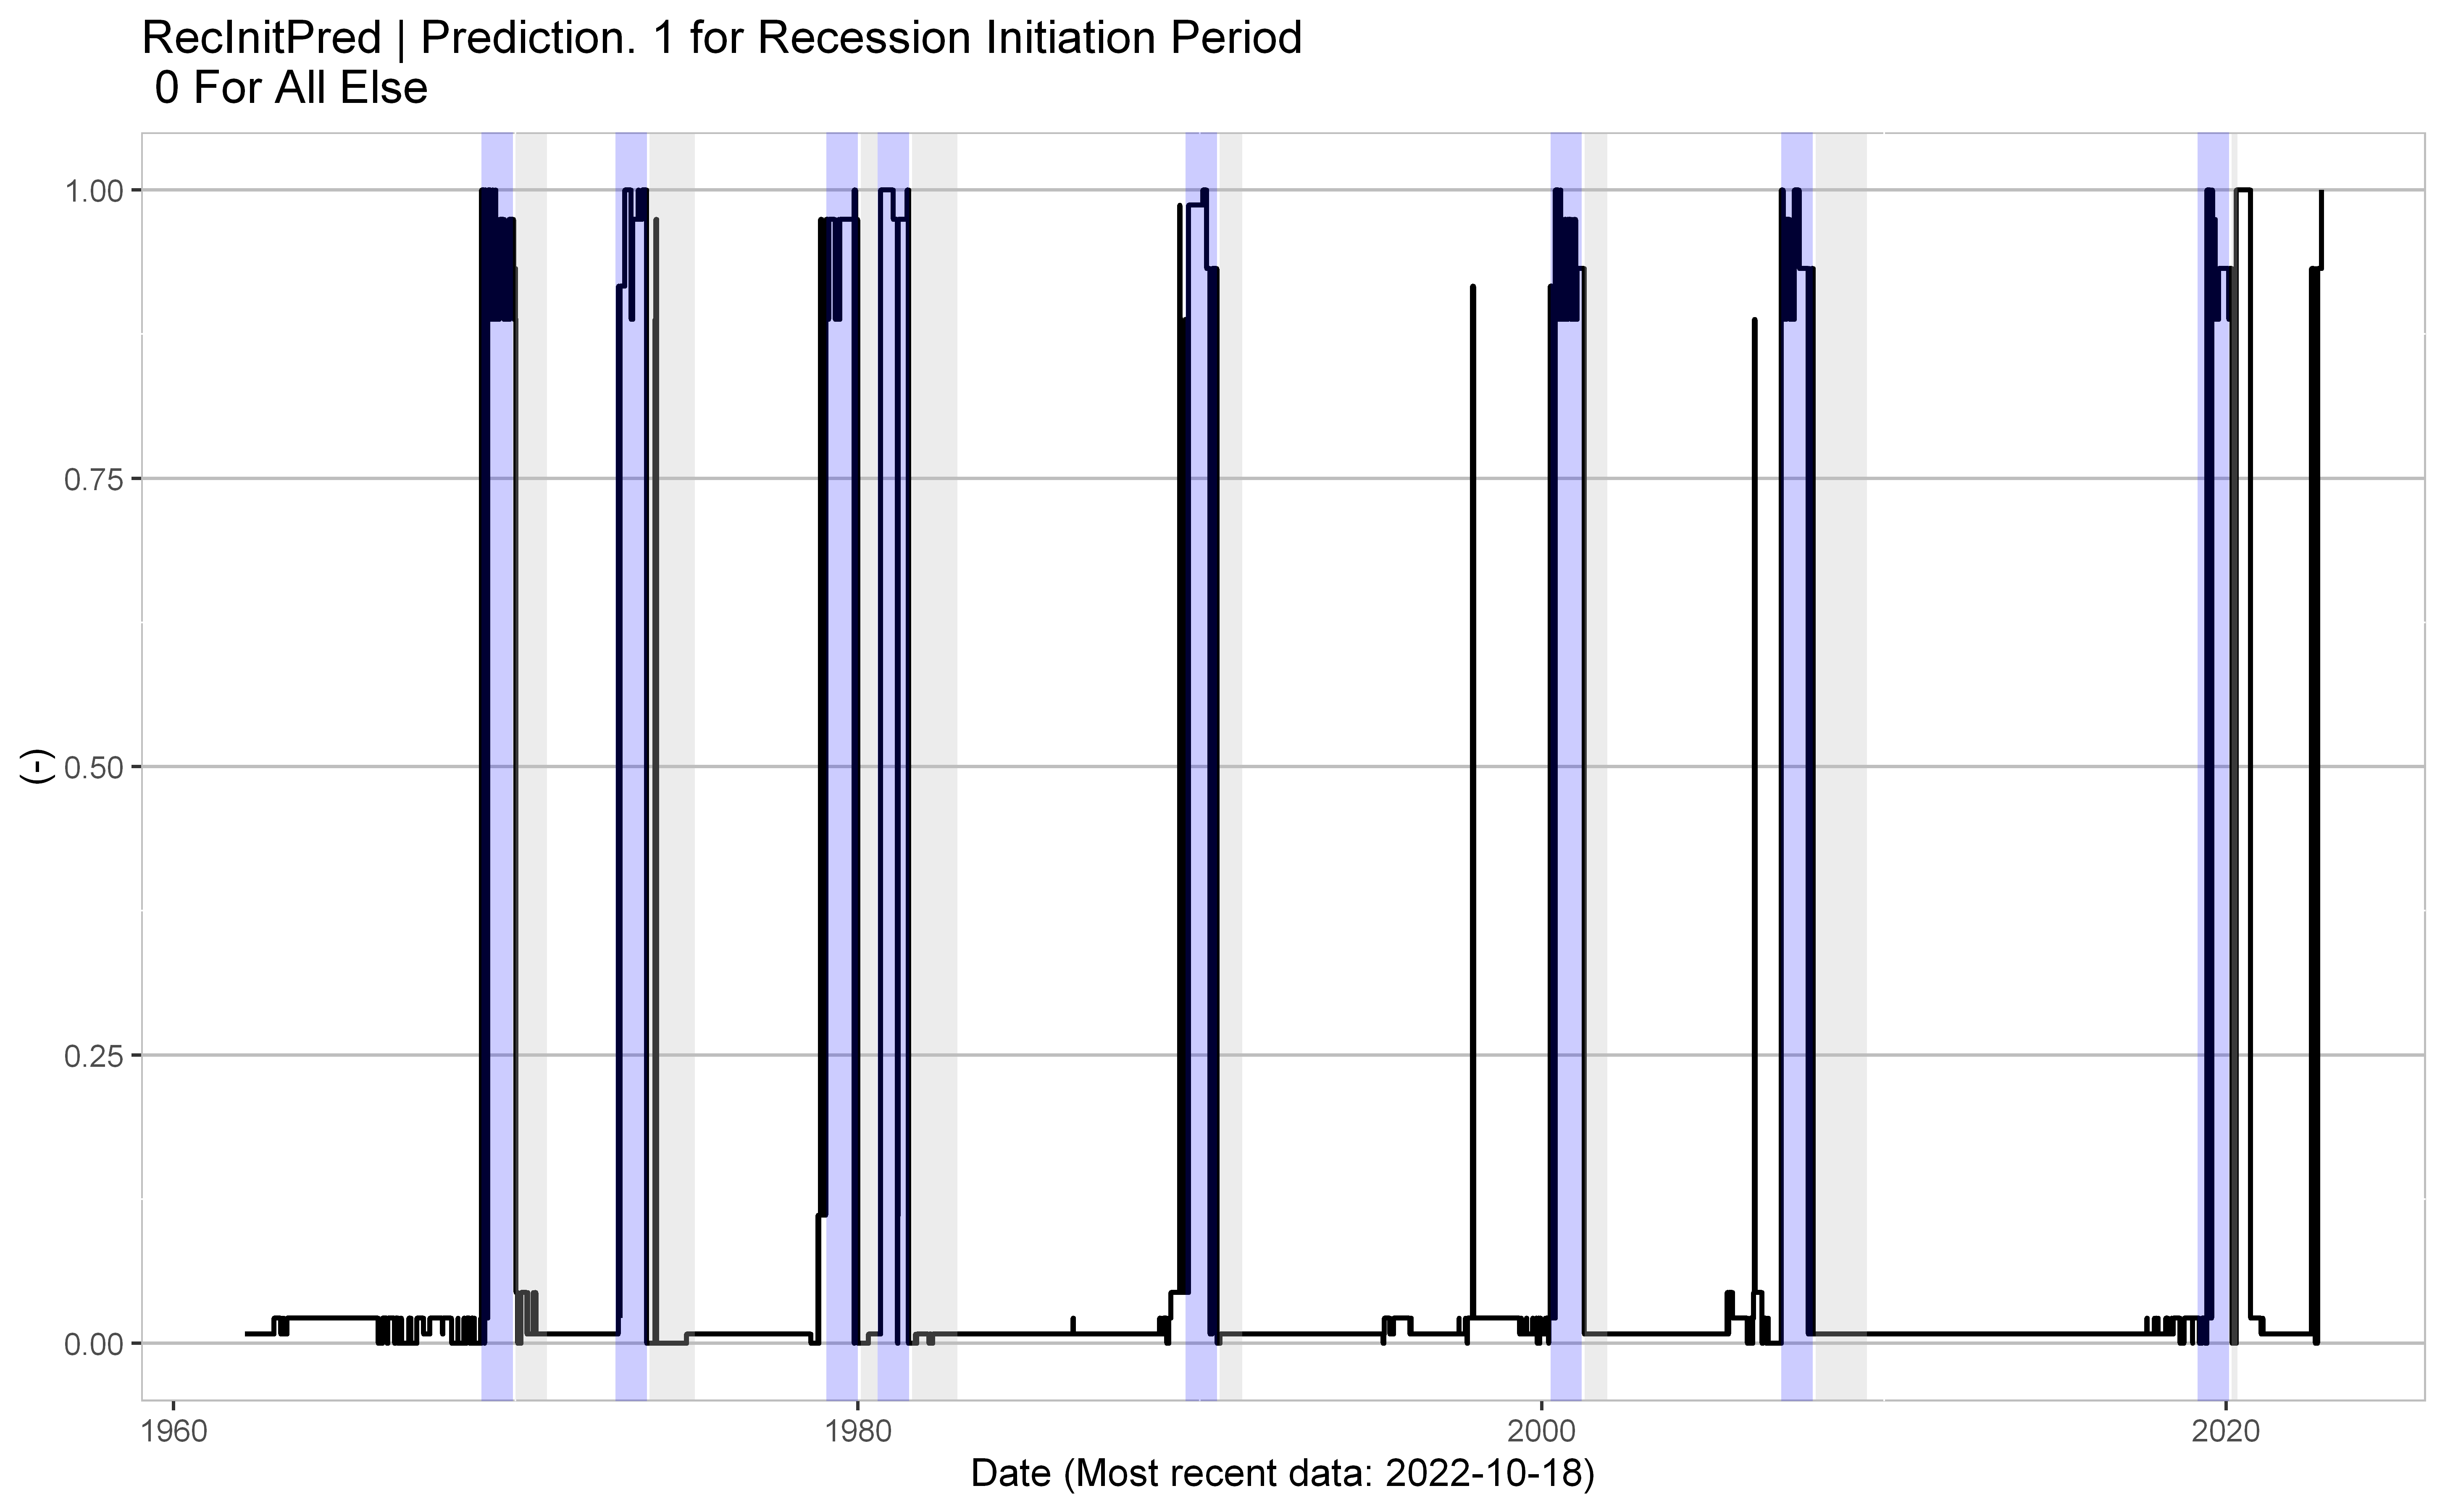

In [34]:
df.data$RecInitPred <- predict(model.fit, newdata = df.data)
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = "RecInitPred",
      string.source = "Calc",
      string.description =  "Prediction 1 for Recession Initiation Period, 0 For All Else",
      string.label.y = "(-)",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction ,
      date.series.end = as.Date(Sys.Date())
    )
  )


datay <- "RecInitPred"
datay_aux <- "RecInit"
ylim <- c(0, 1)
myPlot <- plotSingleQuick(dfRecession, df.data, datay, ylim, dt.start.prediction)
myPlot + geom_rect(
  data = dfRecession,
  aes(
    xmin = initStart,
    xmax = initEnd,
    ymin = -Inf,
    ymax = Inf
  ),
  fill = "blue",
  alpha = 0.2,
  na.rm = TRUE
)

## Explore how the features relate to the smooth model

Some exploration to see how the features relate to the smoothed recesession predictor

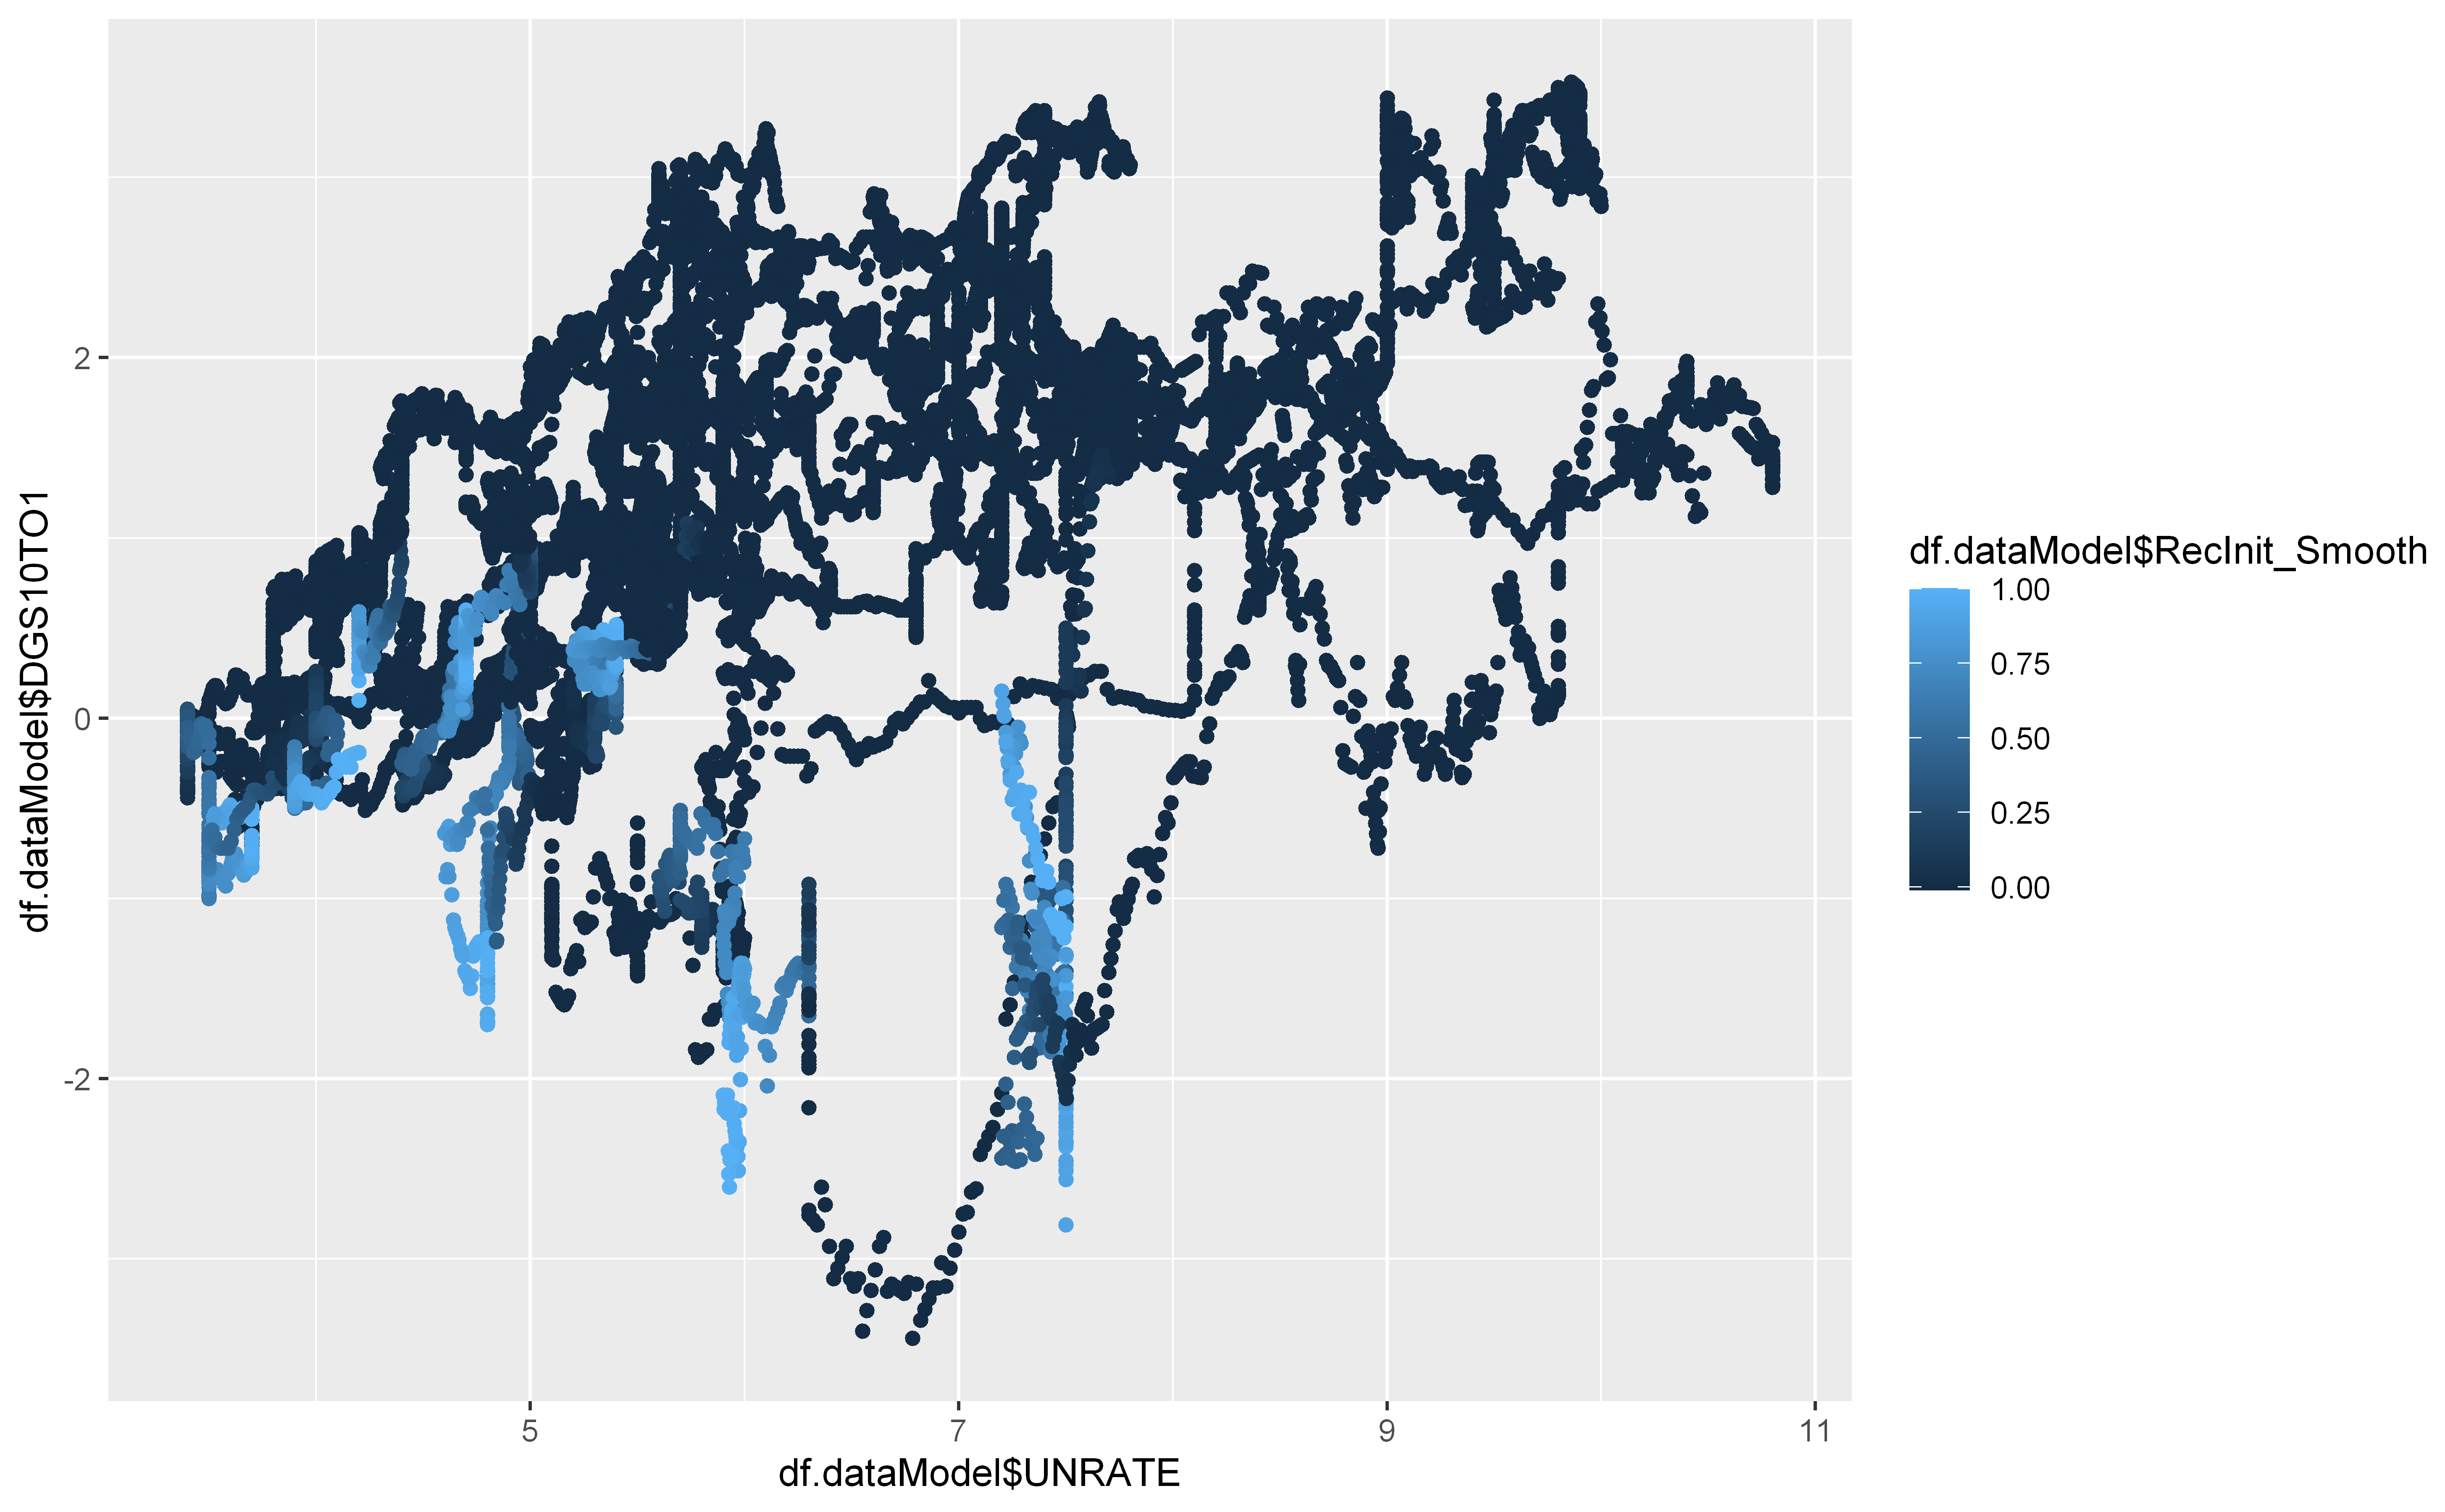

In [35]:
qplot(df.dataModel$UNRATE, df.dataModel$DGS10TO1, colour=df.dataModel$RecInit_Smooth)

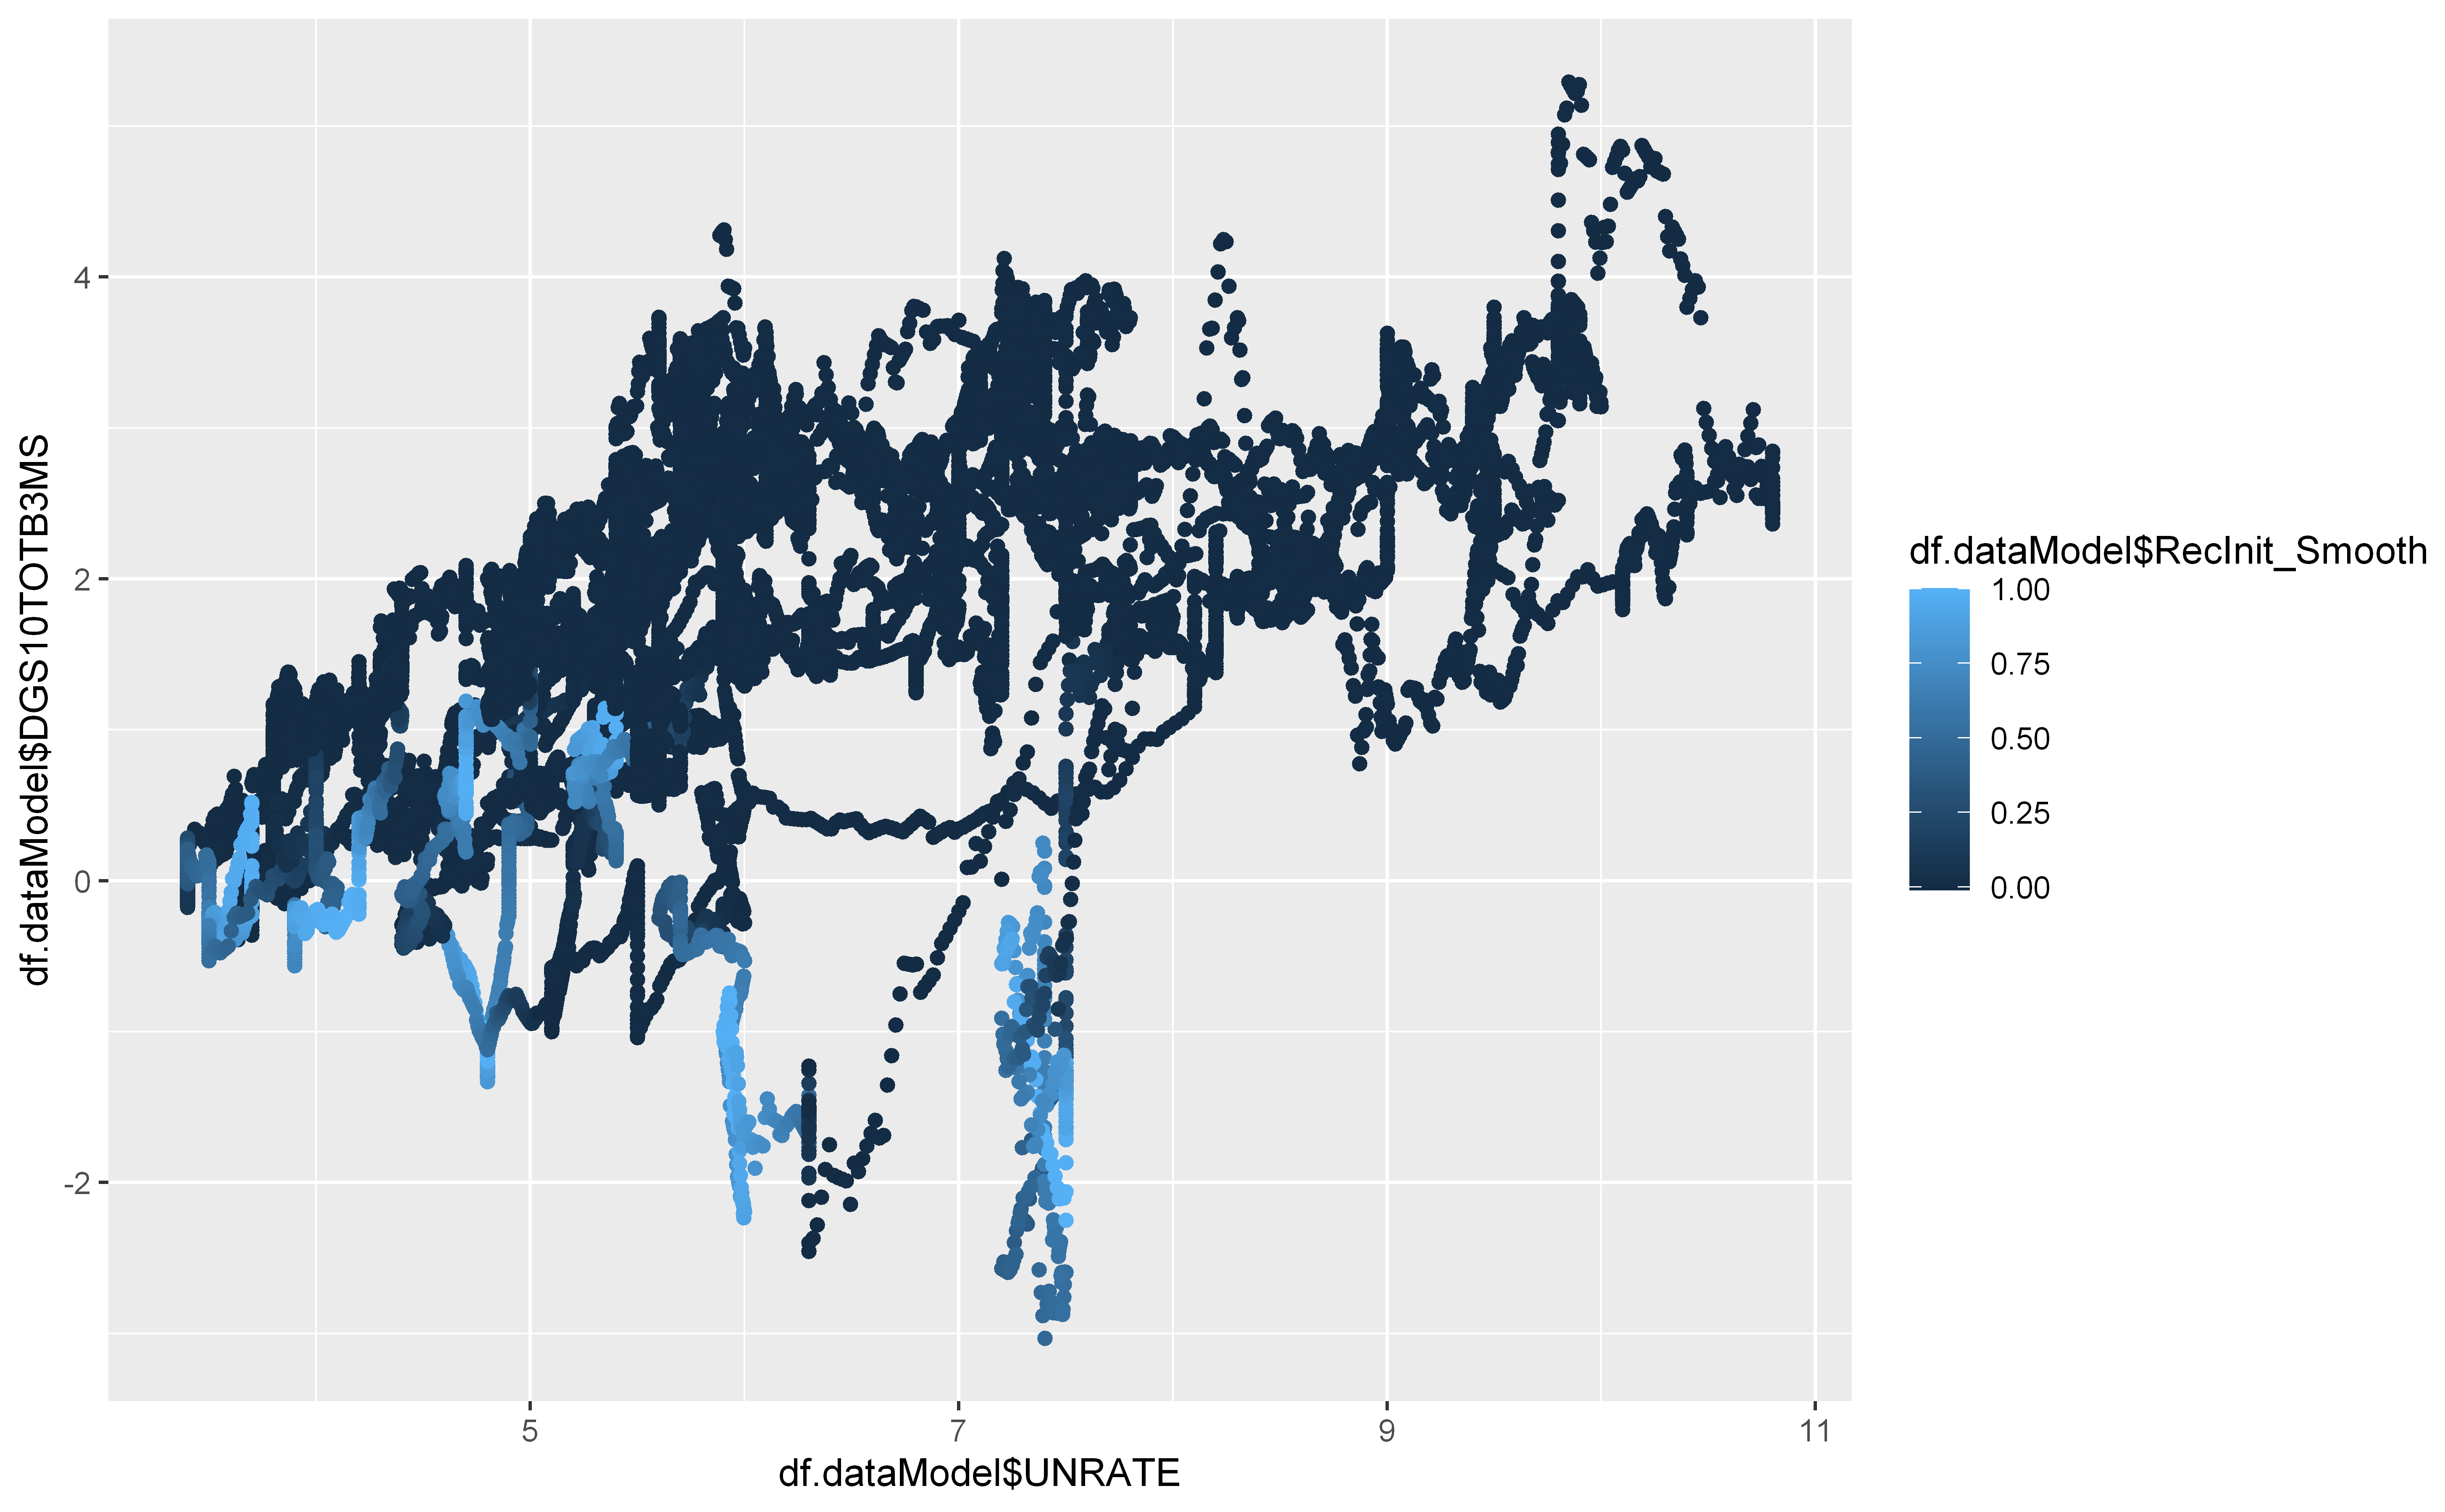

In [36]:
qplot(df.dataModel$UNRATE, df.dataModel$DGS10TOTB3MS, colour=df.dataModel$RecInit_Smooth)

## Create the models (Smooth)

These models take some time to build and, as long as the dates do not change, we can just load them from a local copy rather re-building them.

In [40]:
str.model.file <- "RecessionModels.pkl"

# Either train the models or load them from the local copy
if (b.refresh.models){
  
  list.equations.smooth <- list()
  knn.smooth.list <- list()
  list.column.name <- list()
  list.nn.smooth <- list()
  list.column.name.nn <- list()
  list.lm.smooth <- list()
  list.column.name.lm <- list()
  
  
  # Loop through the features
  for (idx.feature in seq_along(model.features)){
    list.feature <- model.features[[idx.feature]]
    print(list.feature)
    list.equations.smooth[[idx.feature]] <- paste("RecInit_Smooth ~ ", paste(list.feature, collapse = "+", sep=""))
    
    # Train the KNN model
    print("Training KNN")
    knn.smooth.list[[idx.feature]] <- train(as.formula(list.equations.smooth[[idx.feature]]), 
                                            data=dfTrain, method="knn", 
                                            preProcess = c('center', 'scale'), tunelength = 2)
    
    # Train the nueral net.
    print("Training Neural Net")
    #my.grid <- expand.grid(.decay = c(0.01, 0.001), .size = c(5, 6, 7))
    list.nn.smooth[[idx.feature]] <- train(as.formula(list.equations.smooth[[idx.feature]]), data=dfTrain, 
                                           method="nnet", 
                                           preProcess = c('center', 'scale'),
                                           trace = FALSE)
  
  
    # Train the linear model.
    print("Training Linear Model")
    list.lm.smooth[[idx.feature]] <- train(as.formula(list.equations.smooth[[idx.feature]]), data=dfTrain, 
                                           method="lm", 
                                           preProcess = c('center', 'scale'))
  
  }
  
  # Save off the models and features
  vector.save.variables <- c('list.equations.smooth', 'knn.smooth.list','list.column.name',
    'list.nn.smooth', 'list.column.name.nn', 'list.lm.smooth', 'list.column.name.lm',
    'list.equations.smooth')
  save(list=vector.save.variables, file=str.model.file)
  
}else{
  
  # Retrieve the model and features from the local copy
  load(file=str.model.file)
  
}

[1] "DGS10TOTB3MS"
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS" "UNRATE"      
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS" "W875RX1_YoY" 
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS" "ICSA_YoY"    
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS"                    "GDPBYCPIAUCSLBYPOPTHM_SmoothDer"
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS" "HSN1FNSA_YoY"
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS" "UNRATE"       "W875RX1_YoY" 
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS" "UNRATE"       "ICSA_YoY"    
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS" "W875RX1_YoY"  "ICSA_YoY"    
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS"                    "W875RX1_YoY"                    
[3] "ICSA_YoY"                        "GDPBYCPIAUCSLBYPOPTHM_SmoothDer"
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS" "UNRATE"       "W875RX1_YoY"  "ICSA_YoY"    
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS" "UNRATE"       "W875RX1_YoY"  "ICSA_YoY"     "HSN1FNSA_YoY"
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TODTB3" "UNRATE"      "W875RX1_YoY" "ICSA_YoY"   
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS"                    "UNRATE"                         
[3] "W875RX1_YoY"                     "ICSA_YoY"                       
[5] "GDPBYCPIAUCSLBYPOPTHM_SmoothDer"
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"
[1] "DGS10TOTB3MS"                    "UNRATE"                         
[3] "W875RX1_YoY"                     "ICSA_YoY"                       
[5] "GDPBYCPIAUCSLBYPOPTHM_SmoothDer" "HSN1FNSA_YoY"                   
[1] "Training KNN"
[1] "Training Neural Net"


Warning message in nominalTrainWorkflow(x = x, y = y, wts = weights, info = trainInfo, :
"There were missing values in resampled performance measures."


[1] "Training Linear Model"


With the models trained, perform the predictions

In [41]:
# Create the average model column
df.data$recession.initiation.smooth.avg <- df.data$U6RATE * 0
# Add the prediction to the symbols table
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = "recession.initiation.smooth.avg",
      string.source = "Predict",
      string.description =  "Prediction of Recession within 12 Months.\nAll Models Averaged",
      string.label.y = "Probability",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Use the models to calculate the predicted values
for (idx.feature in seq_along(model.features)) {
  # Predict using the KNN model on the entire dataframe using the knn model and normalize to 0 to 1
  list.column.name[[idx.feature]] <-
    paste("recession.initiation.smooth.knn", idx.feature, sep = "")
  df.data[[list.column.name[[idx.feature]]]] <-
    predict(knn.smooth.list[[idx.feature]], newdata = df.data)
  df.data[[list.column.name[[idx.feature]]]] <-
    ((df.data[[list.column.name[[idx.feature]]]] -
        min(df.data[[list.column.name[[idx.feature]]]])) /
       (max(df.data[[list.column.name[[idx.feature]]]]) -
          min(df.data[[list.column.name[[idx.feature]]]])))
  
  # Add the knn model prediction to the symbols table
  df.symbols <-
    rbind(
      df.symbols,
      data.frame(
        string.symbol = list.column.name[[idx.feature]],
        string.source = "Predict",
        string.description = paste(
          "Knn Prediction 1 for Recession\nInitiation Period, 0 For All Else (Smooth)\n",
          get.formula.formatted(list.equations.smooth[[idx.feature]]),
          sep = " "
        ),
        string.label.y = "(-)",
        float.expense.ratio = -1.00,
        Max030 = FALSE,
        Max180 = FALSE,
        date.series.start = dt.start.prediction,
        date.series.end = as.Date(Sys.Date())
      )
    )
  
  # Add it to the knn average column
  df.data$recession.initiation.smooth.avg <-
    (df.data$recession.initiation.smooth.avg +
       df.data[[list.column.name[[idx.feature]]]])
  
  
  
  # Predict on the entire dataframe using the nn model, normalized on 0 to 1
  list.column.name.nn[[idx.feature]] <-
    paste("recession.initiation.smooth.nn", idx.feature, sep = "")
  df.data[[list.column.name.nn[[idx.feature]]]] <-
    predict(list.nn.smooth[[idx.feature]], newdata = df.data)
  df.data[[list.column.name.nn[[idx.feature]]]] <-
    ((df.data[[list.column.name.nn[[idx.feature]]]] -
        min(df.data[[list.column.name.nn[[idx.feature]]]])) /
       (max(df.data[[list.column.name.nn[[idx.feature]]]]) -
          min(df.data[[list.column.name.nn[[idx.feature]]]])))
  
  
  # Add the neural net model prediction to the symbols table
  df.symbols <-
    rbind(
      df.symbols,
      data.frame(
        string.symbol = list.column.name.nn[[idx.feature]],
        string.source = "Predict",
        string.description = paste(
          "Neural Net Prediction 1 for Recession\nInitiation Period, 0 For All Else (Smooth)\n",
          list.equations.smooth[[idx.feature]],
          sep = " "
        ),
        string.label.y = "(-)",
        float.expense.ratio = -1.00,
        Max030 = FALSE,
        Max180 = FALSE,
        date.series.start = dt.start.prediction,
        date.series.end = as.Date(Sys.Date())
      )
    )
  
  # Add it to the average column
  df.data$recession.initiation.smooth.avg <-
    (df.data$recession.initiation.smooth.avg +
       df.data[[list.column.name.nn[[idx.feature]]]])
  
  
  
  # Predict on the entire dataframe using the lm model, normalized on 0 to 1
  list.column.name.lm[[idx.feature]] <-
    paste("recession.initiation.smooth.lm", idx.feature, sep = "")
  df.data[[list.column.name.lm[[idx.feature]]]] <-
    predict(list.lm.smooth[[idx.feature]], newdata = df.data)
  df.data[[list.column.name.lm[[idx.feature]]]] <-
    ((df.data[[list.column.name.lm[[idx.feature]]]] -
        min(df.data[[list.column.name.lm[[idx.feature]]]])) /
       (max(df.data[[list.column.name.lm[[idx.feature]]]]) -
          min(df.data[[list.column.name.lm[[idx.feature]]]])))
  
  
  # Add the linear model model prediction to the symbols table
  df.symbols <-
    rbind(
      df.symbols,
      data.frame(
        string.symbol = list.column.name.lm[[idx.feature]],
        string.source = "Predict",
        string.description = paste(
          "Linear Model Prediction 1 for Recession\nInitiation Period, 0 For All Else (Smooth)\n",
          list.equations.smooth[[idx.feature]],
          sep = " "
        ),
        string.label.y = "(-)",
        float.expense.ratio = -1.00,
        Max030 = FALSE,
        Max180 = FALSE,
        date.series.start = dt.start.prediction,
        date.series.end = as.Date(Sys.Date())
      )
    )
  
  # The linear model performance is not great so I am not adding it to the average
  #  df.data$recession.initiation.smooth.avg <- (df.data$recession.initiation.smooth.avg +
  #                                                   df.data[[list.column.name.lm[[idx.feature]]]])
  
  
  
}
  
# Divide by the number of models to get the average
df.data$recession.initiation.smooth.avg <- (df.data$recession.initiation.smooth.avg / (2 * i.model.count))


Print out the model results.

In [ ]:
ylim <- c(0, 1)
for (idx.feature in seq_along(model.features)){
  
  # KNN Data
  datay <- list.column.name[[idx.feature]]
  myPlot <- plotSingle(dfRecession, df.data, "date", datay, getPlotTitle(df.symbols, datay), "Date", 
              getPlotYLabel(df.symbols, datay), c(dt.start.prediction, Sys.Date()), ylim, TRUE)
  print(myPlot)
  myPlot <- plotSingle(dfRecession, df.data, "date", datay, getPlotTitle(df.symbols, datay), "Date", 
              getPlotYLabel(df.symbols, datay), c(dt.recent, Sys.Date()), ylim, TRUE)
  print(myPlot)
  
  # Neural Net Data
  datay <- list.column.name.nn[[idx.feature]]
  myPlot <- plotSingle(dfRecession, df.data, "date", datay, getPlotTitle(df.symbols, datay), "Date", 
              getPlotYLabel(df.symbols, datay), c(dt.start.prediction, Sys.Date()), ylim, TRUE)
  print(myPlot)
  myPlot <- plotSingle(dfRecession, df.data, "date", datay, getPlotTitle(df.symbols, datay), "Date", 
              getPlotYLabel(df.symbols, datay), c(dt.recent, Sys.Date()), ylim, TRUE)
  print(myPlot)

  # Linear Model Data
  datay <- list.column.name.lm[[idx.feature]]
  myPlot <- plotSingle(dfRecession, df.data, "date", datay, getPlotTitle(df.symbols, datay), "Date", 
              getPlotYLabel(df.symbols, datay), c(dt.start.prediction, Sys.Date()), ylim, TRUE)
  print(myPlot)
  myPlot <- plotSingle(dfRecession, df.data, "date", datay, getPlotTitle(df.symbols, datay), "Date", 
              getPlotYLabel(df.symbols, datay), c(dt.recent, Sys.Date()), ylim, TRUE)
  print(myPlot)

}

datay <- "recession.initiation.smooth.avg"
myPlot <- plotSingle(dfRecession, df.data, "date", datay, getPlotTitle(df.symbols, datay), "Date", 
            getPlotYLabel(df.symbols, datay), c(dt.start.prediction, Sys.Date()), ylim, TRUE)
print(myPlot)

## Average Model (Smooth)

Zoom into the last couple of years and compare the FED benchmark series. Both are stongly dependant on the 10 year to 3 month inversion so behavior is similar.

In [ ]:
datay <- "recession.initiation.smooth.avg"
datay.aux <- "nyfed.recession"
myPlot <-
  plotSingle(
    dfRecession,
    df.data,
    "date",
    datay,
    getPlotTitle(df.symbols, datay),
    "Date",
    getPlotYLabel(df.symbols, datay),
    c(dt.recent, Sys.Date()),
    ylim = c(0, 1.0),
    b.legend = TRUE
  )

myPlot <-
  myPlot + geom_line(
    data = df.data,
    aes_string(
      x = "date",
      y = datay.aux,
      colour = shQuote(datay.aux)
    ),
    na.rm = TRUE
  )

myPlot



Much like the previous section, create the tree model for the smooth recessesion indicator.

In [ ]:
model.fitSmooth <- rpart( tail(list.equations.smooth, n=1)[[1]], data=dfTrain)

Add the prediction to the dataframe

In [ ]:
df.data$RecInitPredSmooth <-
  predict(model.fitSmooth, newdata = df.data)
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = "RecInitPredSmooth",
      string.source = "Calc",
      string.description =  "Prediction 1 for Recession Initiation Period, 0 For All Else (Smooth)",
      string.label.y = "(-)",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction ,
      date.series.end = as.Date(Sys.Date())
    )
  )

The plot below summarizes the correlations in a graphical format. The tree itself is a little more complicated than I like.

In [ ]:
rpart.plot(
  model.fitSmooth,
  main = paste("Recession Indicator (Smooth)\n", str.training.date.range),
  type = 2,
  extra = 1
)

## Validation (Smooth, all features)

A qualitative evaluation

In [ ]:
datay <- "RecInitPredSmooth"
datay.knn <- "recession.initiation.smooth.knn3"
datay.aux<- "RecInit_Smooth"
ylim <- c(0, 1)
myPlot <- plotSingle(dfRecession, df.data, "date", datay, getPlotTitle(df.symbols, datay), "Date", 
            getPlotYLabel(df.symbols, datay), c(dt.start.prediction, Sys.Date()), ylim, TRUE)
myPlot <- myPlot + geom_line(data=df.data, aes_string(x="date", y=datay.aux, colour=shQuote(datay.aux)), na.rm = TRUE)
myPlot <- myPlot + geom_line(data=df.data, aes_string(x="date", y=datay.knn, colour=shQuote(datay.knn)), na.rm = TRUE)
myPlot

# Creating the Trading Rules 

The strategy here will be to go long when the recesion initiation signal is below 0.5. When it crosses 0.5 I will exit the market. I need a signal that will tell me when to get back in. From the data exploration section I noted that the second derivative of the unemployment rate crosses zero right in the middle of most recessions That zero crossing will serve as the buy signal to get back in the market.

## Create the trade rule for recession initiation

In [ ]:
dt.end.predictionPred[39]

In [ ]:
dt.end.predictionCand 

In [ ]:
idx

In [ ]:
min(which(dt.end.predictionCand > dt.end.predictionPred[33]))

In [ ]:
length(dtStartPred)

In [ ]:
# Round off the prediction
df.data$RecInitPredRd <- round(df.data$RecInitPred, digits = 0)
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = "RecInitPredRd",
      string.source = "Calc",
      string.description =  "Rounded Prediction 1 for Recession Initiation\n Period, 0 For All Else",
      string.label.y = "(-)",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

# Extract the dates from the prediction
dtStartPred <- df.data$date[which(diff(df.data$RecInitPredRd)==1)+1]
dtStartPred <- dtStartPred+30
dt.end.predictionPred <- df.data$date[which(diff(df.data$RecInitPredRd)==-1)]

# Zero crossings of the 2nd derivative of the unemployment rate
dZeroUNRATE <- diff(sign(df.data$UNRATE_SmoothDer2))
dZeroUNRATE <- append(dZeroUNRATE, tail(dZeroUNRATE,1))
df.data$dZeroUNRATE <- dZeroUNRATE

# keep only the negative slopes and get rid of any dates
# while the indicator is high
df.data$dZeroUNRATE[df.data$dZeroUNRATE>0] <- 0
df.data$dZeroUNRATE <- -1 * (df.data$dZeroUNRATE * (df.data$RecInitPredRd - 1))


# Find the first negative slope after the recession indicator triggers
dt.end.predictionCand <- df.data$date[which(df.data$dZeroUNRATE<0)]
dtBuyPred <- dtStartPred
for (idx in 1:length(dtStartPred)){
  dtBuyPred[idx] <- dt.end.predictionCand[min(which(dt.end.predictionCand > dt.end.predictionPred[idx]))]
}
dfPred <- data.frame(predStart = dtStartPred, predEnd = dtBuyPred)

# Create the trade rule, 1 is long, 0 is not invested
df.data$RecInitTrade <- rep(1, nrow(df.data))

for(idx in 1:nrow(dfPred)) {
  df.data$RecInitTrade[which(df.data$date > dfPred$predStart[idx] &
                              df.data$date < dfPred$predEnd[idx])] = 0
}
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = "RecInitTrade",
      string.source = "Calc",
      string.description =  "Recession Initiation Trade Rule",
      string.label.y = "(-)",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

In [ ]:











```{r backval, include=FALSE}
# Create a data series and validate that our back testing function works correctly.
# Create a 12-month series with 10% annual interest compounded annually
dTest <- UNRATE['1999/2001']
dRate <- 0.1
dTest[,'UNRATE'] = ((1+dRate/12.0) ^ (12.0*seq(1:nrow(dTest))/12))
dMonths <- 24

# Test case 1, 100% in for the whole time
dEqAn <- (1+dRate/12.0)^(12.0*(dMonths/12.0))
ret <- ROC(dTest)
ret <- ret['2000/2001']
dEq1Nm <- exp(cumsum(ret))
dEq1Nm <- as.numeric(tail(dEq1Nm,1)$UNRATE)

dfTestResults <- data.frame(c("100%"), c(dEqAn), c(dEq1Nm))
colnames(dfTestResults) <- c("Test","Analytical", "Numerical")
dfTestResults

```

## Plot the Backtesting Results

### Create the Baseline Data Series

The trading strategy will be compared to the S&P 500, shown below. We use this to create an S&P 500 rate of change series. The trading rule will move in and out of this series.

```{r plotbackbase, echo=FALSE, fig.width=7, fig.height=10}

dtStartBackTest = as.Date('1960-01-01')
ylimBackTest <- c(0, 60)




datay <- "eqBase"
p1 <- plotSingleQuick(dfRecession, df.data, datay, ylimBackTest, dtStartBackTest)

datay <- "retBase"
ylim <- c(-0.1, 0.1)
p2 <- plotSingleQuick(dfRecession, df.data, datay, ylim, dtStartBackTest)

datay <- "eqBaseShort_TB3MS"
p3 <- plotSingleQuick(dfRecession, df.data, datay, ylimBackTest, dtStartBackTest)

datay <- "retBaseShort_TB3MS"
ylim <- c(-0.1, 0.1)
p4 <- plotSingleQuick(dfRecession, df.data, datay, ylim, dtStartBackTest)

grid.arrange(p1, p2, p3, p4, ncol = 1, top = paste("Base Case (100% long) | Growth = ", sprintf('%0.2f', tail(df.data$eqBase,1)), sep=""))

```

### Perform the Backtesting and Plot the Results

In this final analysis step the trading rule is plotted along with the indicator in the top pane. The middle pane shows how the trading rule modified the rate of change series. The bottom plots shows how the investment performed, compared to the S&P 500. 

```{r plotbackrecInit,echo=FALSE, fig.width=7,fig.height=10}

df.data$retRec <- df.data$retBase * df.data$RecInitTrade
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = "retRec",
      string.source = "Calc",
      string.description =  "Rate of Change, Recession Initiation Rule",
      string.label.y = "Percent",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

df.data$eqRec <- exp(cumsum(df.data$retRec))
df.data$eqRec <- df.data$eqRec/df.data[min(which(df.data$date>dtStartBackTest)),"eqRec"]
df.symbols <-
  rbind(
    df.symbols,
    data.frame(
      string.symbol = "eqRec",
      string.source = "Calc",
      string.description =  "Equity Return, Recession Initiation Rule",
      string.label.y = "$1 Invested",
      float.expense.ratio = -1.00,
      Max030 = FALSE,
      Max180 = FALSE,
      date.series.start = dt.start.prediction,
      date.series.end = as.Date(Sys.Date())
    )
  )

dataTrade <- "RecInitTrade"
dataRet <- "retRec"
dataEq <- "eqRec"

ylimBackTest = c(0, 250)
p1 <-
  plotBack(
    dfRecession,
    df.data,
    dataTrade,
    dataRet,
    dataEq,
    dfPred,
    bOverlay = TRUE,
    dtStartBackTest,
    ylimBackTest
  )

```

The trading strategy resulted in an improved return, although most of this comes after the 2007-2008 recession. In that recession the trading rules return to the long position at the exact market bottom. This is in contrast to the 1999-2000 recession where the trading rule returns to long before the market bottoms.